In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
import os
import shutil

def empty_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"⚠️ Could not delete {file_path}: {e}")

In [2]:
import os

DATASET_PATH = "/content/drive/My Drive/big_dataset/videos"
OUTPUT_PATH_DRIVE = "/content/drive/My Drive/big_dataset/extracted_features_dataset"
OUTPUT_PATH_LOCAL = "content/extracted_features_dataset"
#empty_folder(OUTPUT_PATH)
#os.makedirs(OUTPUT_PATH, exist_ok=True)

In [3]:
# System packages
#!apt-get install -y ffmpeg

# Python packages
!pip install opencv-python-headless scikit-image scipy tqdm librosa

# ✅ Imports
import cv2
import numpy as np
import scipy
import skimage
from tqdm import tqdm  # ✅ Import tqdm function, not the module
import librosa

print("✅ All dependencies installed successfully!")

✅ All dependencies installed successfully!


In [4]:
import cv2
import numpy as np
from tqdm import tqdm
from enum import Enum
import os
from skimage.feature import local_binary_pattern

# Enum for resolution options
class Resolution(Enum):
    LOW = (160, 120)
    MEDIUM = (320, 240)
    HIGH = (640, 480)
    ULTRA = (1280, 720)

selected_resolution = Resolution.HIGH.value

# Base class for feature extractors
class FeatureExtractor:
    def __init__(self):
        self.results = []

    def reset(self):
        self.results = []

    def update(self, frame):
        pass  # To be overridden in subclasses

    def get_result(self):
        return np.array(self.results)

# Optical Flow Extractor (needs prev_frame)
class OpticalFlowExtractor(FeatureExtractor):
    def __init__(self):
        super().__init__()
        self.prev_frame = None

    def update(self, frame):
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.resize(gray_frame, selected_resolution)

        if self.prev_frame is not None:
            flow = cv2.calcOpticalFlowFarneback(self.prev_frame, gray_frame, None, pyr_scale=0.6, levels=3,
                                                winsize=15, iterations=3, poly_n=5, poly_sigma=1.1, flags=0)
            optical_flow = np.mean(np.linalg.norm(flow, axis=2))
            self.results.append(optical_flow)

        self.prev_frame = gray_frame  # Store the current frame as prev_frame for next update


# Frame Difference Extractor (needs prev_frame)
class FrameDifferenceExtractor(FeatureExtractor):
    def __init__(self):
        super().__init__()
        self.prev_frame = None

    def update(self, frame):
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.resize(gray_frame, selected_resolution)

        if self.prev_frame is not None:
            frame_diff = cv2.absdiff(self.prev_frame, gray_frame)
            diff_value = np.mean(frame_diff)
            self.results.append(diff_value)

        self.prev_frame = gray_frame

# FFT Extractor
class FFTExtractor(FeatureExtractor):
    def __init__(self):
        super().__init__()

    def update(self, frame):
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.resize(gray_frame, selected_resolution)

        fft_result = np.fft.fft2(gray_frame)
        fft_magnitude = np.abs(fft_result)
        fft_mean = np.mean(fft_magnitude)
        self.results.append(fft_mean)

# DCT Extractor
class DCTExtractor(FeatureExtractor):
    def __init__(self):
        super().__init__()

    def update(self, frame):
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.resize(gray_frame, selected_resolution)

        dct_result = cv2.dct(np.float32(gray_frame))
        dct_magnitude = np.abs(dct_result)
        dct_mean = np.mean(dct_magnitude)
        self.results.append(dct_mean)

# MHI Extractor (needs prev_frame)
class MHIExtractor(FeatureExtractor):
    def __init__(self, max_time=30, decay_rate=0.05):
        super().__init__()
        self.prev_frame = None
        self.mhi = None
        self.max_time = max_time
        self.decay_rate = decay_rate
        self.timestamp = 0

    def update(self, frame):
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.resize(gray_frame, selected_resolution)

        if self.prev_frame is not None:
            frame_diff = cv2.absdiff(self.prev_frame, gray_frame)
            motion = np.float32(frame_diff)

            if self.mhi is None:
                self.mhi = np.zeros_like(motion)

            self.mhi = self.mhi * (1 - self.decay_rate) + motion
            self.timestamp += 1

            _, mhi_thresholded = cv2.threshold(self.mhi, 25, 255, cv2.THRESH_BINARY)
            self.results.append(np.mean(mhi_thresholded))

        self.prev_frame = gray_frame

class LBPExtractor(FeatureExtractor):
    def __init__(self, radius=1, n_points=8, skip_frames=5):
        super().__init__()
        self.radius = radius
        self.n_points = n_points
        self.skip_frames = skip_frames  # How many frames to skip (every N-th frame)
        self.frame_counter = 0  # Counter to track which frame we're on

    def update(self, frame):
        # Increment the frame counter
        self.frame_counter += 1

        # Only process every N-th frame
        if self.frame_counter % self.skip_frames == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            lbp = local_binary_pattern(gray, self.n_points, self.radius, method="uniform")

            lbp_hist, _ = np.histogram(
                lbp.ravel(),
                bins=np.arange(0, self.n_points + 3),
                range=(0, self.n_points + 2)
            )

            lbp_hist = lbp_hist.astype('float32')
            lbp_hist /= (lbp_hist.sum() + 1e-6)

            self.results.append(lbp_hist)

    def get_result(self):
        if not self.results:
            return np.zeros(self.n_points + 2, dtype='float32')

        stacked = np.stack(self.results, axis=0)
        mean_hist = np.mean(stacked, axis=0)
        return mean_hist

def process_video_with_features(video_path, feature_extractors, output_dir, existing_features=None, existing_labels=None, video_name=None, save_interval=100):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: Couldn't open video {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if video_name is None:
        video_name = os.path.basename(video_path).split('.')[0]

    with tqdm(total=total_frames, desc=f"Processing {video_path}", ncols=100, dynamic_ncols=True, position=0) as pbar:
        for extractor in feature_extractors:
            extractor.reset()  # Reset the extractor before processing

        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            for extractor in feature_extractors:
                extractor.update(frame)

            pbar.update(1)
            frame_count += 1

            # Save progress after every `save_interval` frames processed (default 100 frames)
            if frame_count % save_interval == 0:
                save_features(existing_features, existing_labels, output_dir)

        cap.release()

    # After processing all frames, save the extracted features
    save_features(existing_features, existing_labels, output_dir)

    # Return a dictionary with the feature names and their extracted results
    features_dict = {
        type(extractor).__name__: extractor.get_result()
        for extractor in feature_extractors
    }

    return features_dict

# Function to save features to disk (to prevent data loss on interruption)
def save_features(features_list, labels_list, output_dir, checkpoint_filename="features_final.npz"):
    temp_filename = os.path.join(output_dir, "features_temp.npz")

    np.savez_compressed(temp_filename, features=features_list, labels=labels_list)

    try:
        os.rename(temp_filename, os.path.join(output_dir, checkpoint_filename))
        print(f"Saved {len(features_list)} features to {checkpoint_filename}")
    except Exception as e:
        print(f"Error saving the temp file: {e}")

In [5]:
import os
import re
import numpy as np
from tqdm import tqdm

# --- Load checkpoint ---
def load_features(output_dir, checkpoint_filename="features_final.npz"):
    checkpoint_path = os.path.join(output_dir, checkpoint_filename)
    if os.path.exists(checkpoint_path):
        data = np.load(checkpoint_path, allow_pickle=True)
        features = list(data["features"])  # Convert to list
        labels = list(data["labels"])      # Convert to list
        print(f"✅ Loaded checkpoint with {len(features)} features")
        return features, labels
    else:
        print("🆕 No checkpoint found, starting fresh.")
        return [], []

# --- Save checkpoint ---
def save_features(features, labels, output_dir, checkpoint_filename="features_final.npz"):
    os.makedirs(output_dir, exist_ok=True)
    checkpoint_path = os.path.join(output_dir, checkpoint_filename)
    np.savez_compressed(checkpoint_path, features=features, labels=labels)
    print(f"💾 Saved checkpoint with {len(features)} features")

# --- Extract label from filename ---
def extract_label_from_filename(filename):
    match = re.search(r"_label([01])_", filename)
    if match:
        return int(match.group(1))
    raise ValueError(f"Cannot extract label from filename: {filename}")

# --- Create dataset with resume support ---
def create_dataset_flat(input_dir, output_dir, feature_extractors, save_interval=100):
    features_list, labels_list = load_features(output_dir)
    processed_filenames = set()

    # Determine already processed filenames if any
    video_files = sorted(f for f in os.listdir(input_dir) if f.endswith(".mp4"))
    print(f"📦 Found {len(video_files)} video files total.")

    # Infer which files were processed if lengths match
    if len(features_list) > 0 and len(features_list) <= len(video_files):
        processed_filenames = {
            os.path.basename(f).replace(".mp4", "") for f in video_files[:len(features_list)]
        }

    processed_count = len(features_list)
    print(f"🔁 Resuming from video #{processed_count}...")

    for video_file in tqdm(video_files, desc="🔄 Processing", unit="video"):
        video_name = os.path.splitext(video_file)[0]
        if video_name in processed_filenames:
            continue  # Already processed

        try:
            label = extract_label_from_filename(video_file)
        except ValueError as e:
            print(f"⚠️ Skipping {video_file}: {e}")
            continue

        video_path = os.path.join(input_dir, video_file)

        features = process_video_with_features(
            video_path,
            feature_extractors,
            output_dir,
            features_list,
            labels_list,
            video_name=video_name
        )

        if features:
            features_list.append(features)
            labels_list.append(label)

        if len(features_list) % save_interval == 0:
            save_features(features_list, labels_list, output_dir)

    save_features(features_list, labels_list, output_dir)
    print(f"✅ Finished processing {len(features_list)} videos.")


In [6]:
import os

input_dir = DATASET_PATH  # Update this path

video_files = []
for root, dirs, files in os.walk(input_dir):
    for f in files:
        if f.lower().endswith(('.mp4', '.mov', '.avi', '.mkv')):  # Adjust the filter if needed
            video_files.append(os.path.join(root, f))

# Print the total count and the first few filenames
print(f"📦 Found {len(video_files)} video files to process.")
print("First few files found:")
print(video_files[:5])  # Print the first 5 video files found


📦 Found 5000 video files to process.
First few files found:
['/content/drive/My Drive/big_dataset/videos/03901_label0_celebv_1e8tOF3PeH0_9_0.mp4', '/content/drive/My Drive/big_dataset/videos/03979_label0_celebv_1mqubJrf6KA_2.mp4', '/content/drive/My Drive/big_dataset/videos/03944_label0_celebv_1j8l24hHhgA_2.mp4', '/content/drive/My Drive/big_dataset/videos/03893_label0_celebv_1dwtsZ4IJQE_1.mp4', '/content/drive/My Drive/big_dataset/videos/03891_label0_celebv_1diHvu1Q6Ec_5.mp4']


In [ ]:
if __name__ == "__main__":
    input_dir = DATASET_PATH  # now flat folder with 5000 videos
    output_dir = OUTPUT_PATH_DRIVE

    feature_extractors = [
        OpticalFlowExtractor(),
        FrameDifferenceExtractor(),
        FFTExtractor(),
        DCTExtractor(),
        MHIExtractor()
    ]

    create_dataset_flat(input_dir, output_dir, feature_extractors)

✅ Loaded checkpoint with 609 features
📦 Found 5000 video files total.
🔁 Resuming from video #609...


Processing /content/drive/My Drive/big_dataset/videos/00609_label1_e.mp4: 100%|██████████| 16/16 [00:03<00:00,  5.01it/s]
🔄 Processing:  12%|█▏        | 610/5000 [00:03<00:27, 161.13video/s]

💾 Saved checkpoint with 609 features


Processing /content/drive/My Drive/big_dataset/videos/00610_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.88it/s]


💾 Saved checkpoint with 610 features


Processing /content/drive/My Drive/big_dataset/videos/00611_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


💾 Saved checkpoint with 611 features


Processing /content/drive/My Drive/big_dataset/videos/00612_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.67it/s]


💾 Saved checkpoint with 612 features


Processing /content/drive/My Drive/big_dataset/videos/00613_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


💾 Saved checkpoint with 613 features


Processing /content/drive/My Drive/big_dataset/videos/00614_label1_e.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.92it/s]


💾 Saved checkpoint with 614 features


Processing /content/drive/My Drive/big_dataset/videos/00615_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.95it/s]
🔄 Processing:  12%|█▏        | 616/5000 [00:22<03:33, 20.54video/s] 

💾 Saved checkpoint with 615 features


Processing /content/drive/My Drive/big_dataset/videos/00616_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.87it/s]
🔄 Processing:  12%|█▏        | 617/5000 [00:25<04:13, 17.31video/s]

💾 Saved checkpoint with 616 features


Processing /content/drive/My Drive/big_dataset/videos/00617_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


💾 Saved checkpoint with 617 features


Processing /content/drive/My Drive/big_dataset/videos/00618_label1_d.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s]


💾 Saved checkpoint with 618 features


Processing /content/drive/My Drive/big_dataset/videos/00619_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.04it/s]


💾 Saved checkpoint with 619 features


Processing /content/drive/My Drive/big_dataset/videos/00620_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


💾 Saved checkpoint with 620 features


Processing /content/drive/My Drive/big_dataset/videos/00621_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]
🔄 Processing:  12%|█▏        | 622/5000 [00:40<09:17,  7.85video/s]

💾 Saved checkpoint with 621 features


Processing /content/drive/My Drive/big_dataset/videos/00622_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.44it/s]
🔄 Processing:  12%|█▏        | 623/5000 [00:43<10:51,  6.72video/s]

💾 Saved checkpoint with 622 features


Processing /content/drive/My Drive/big_dataset/videos/00623_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.69it/s]


💾 Saved checkpoint with 623 features


Processing /content/drive/My Drive/big_dataset/videos/00624_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


💾 Saved checkpoint with 624 features


Processing /content/drive/My Drive/big_dataset/videos/00625_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]


💾 Saved checkpoint with 625 features


Processing /content/drive/My Drive/big_dataset/videos/00626_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]
🔄 Processing:  13%|█▎        | 627/5000 [00:55<18:20,  3.97video/s]

💾 Saved checkpoint with 626 features


Processing /content/drive/My Drive/big_dataset/videos/00627_label1_c.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.06it/s]
🔄 Processing:  13%|█▎        | 628/5000 [01:00<22:22,  3.26video/s]

💾 Saved checkpoint with 627 features


Processing /content/drive/My Drive/big_dataset/videos/00628_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


💾 Saved checkpoint with 628 features


Processing /content/drive/My Drive/big_dataset/videos/00629_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


💾 Saved checkpoint with 629 features


Processing /content/drive/My Drive/big_dataset/videos/00630_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s]
🔄 Processing:  13%|█▎        | 631/5000 [01:09<32:48,  2.22video/s]

💾 Saved checkpoint with 630 features


Processing /content/drive/My Drive/big_dataset/videos/00631_label1_b.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.86it/s]


💾 Saved checkpoint with 631 features


Processing /content/drive/My Drive/big_dataset/videos/00632_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]
🔄 Processing:  13%|█▎        | 633/5000 [01:16<42:37,  1.71video/s]

💾 Saved checkpoint with 632 features


Processing /content/drive/My Drive/big_dataset/videos/00633_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  13%|█▎        | 634/5000 [01:19<48:04,  1.51video/s]

💾 Saved checkpoint with 633 features


Processing /content/drive/My Drive/big_dataset/videos/00634_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]
🔄 Processing:  13%|█▎        | 635/5000 [01:22<55:06,  1.32video/s]

💾 Saved checkpoint with 634 features


Processing /content/drive/My Drive/big_dataset/videos/00635_label1_a.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]
🔄 Processing:  13%|█▎        | 636/5000 [01:26<1:10:14,  1.04video/s]

💾 Saved checkpoint with 635 features


Processing /content/drive/My Drive/big_dataset/videos/00636_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]
🔄 Processing:  13%|█▎        | 637/5000 [01:29<1:20:47,  1.11s/video]

💾 Saved checkpoint with 636 features


Processing /content/drive/My Drive/big_dataset/videos/00637_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]
🔄 Processing:  13%|█▎        | 638/5000 [01:32<1:33:48,  1.29s/video]

💾 Saved checkpoint with 637 features


Processing /content/drive/My Drive/big_dataset/videos/00638_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.95it/s]
🔄 Processing:  13%|█▎        | 639/5000 [01:35<1:47:23,  1.48s/video]

💾 Saved checkpoint with 638 features


Processing /content/drive/My Drive/big_dataset/videos/00639_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]
🔄 Processing:  13%|█▎        | 640/5000 [01:38<2:08:44,  1.77s/video]

💾 Saved checkpoint with 639 features


Processing /content/drive/My Drive/big_dataset/videos/00640_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.65it/s]
🔄 Processing:  13%|█▎        | 641/5000 [01:41<2:28:39,  2.05s/video]

💾 Saved checkpoint with 640 features


Processing /content/drive/My Drive/big_dataset/videos/00641_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]
🔄 Processing:  13%|█▎        | 642/5000 [01:44<2:40:23,  2.21s/video]

💾 Saved checkpoint with 641 features


Processing /content/drive/My Drive/big_dataset/videos/00642_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]
🔄 Processing:  13%|█▎        | 643/5000 [01:47<2:49:16,  2.33s/video]

💾 Saved checkpoint with 642 features


Processing /content/drive/My Drive/big_dataset/videos/00643_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]
🔄 Processing:  13%|█▎        | 644/5000 [01:50<2:59:51,  2.48s/video]

💾 Saved checkpoint with 643 features


Processing /content/drive/My Drive/big_dataset/videos/00644_label1_e.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.49it/s]
🔄 Processing:  13%|█▎        | 645/5000 [01:54<3:28:57,  2.88s/video]

💾 Saved checkpoint with 644 features


Processing /content/drive/My Drive/big_dataset/videos/00645_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]
🔄 Processing:  13%|█▎        | 646/5000 [01:57<3:29:31,  2.89s/video]

💾 Saved checkpoint with 645 features


Processing /content/drive/My Drive/big_dataset/videos/00646_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.03it/s]
🔄 Processing:  13%|█▎        | 647/5000 [02:00<3:28:37,  2.88s/video]

💾 Saved checkpoint with 646 features


Processing /content/drive/My Drive/big_dataset/videos/00647_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  13%|█▎        | 648/5000 [02:03<3:27:56,  2.87s/video]

💾 Saved checkpoint with 647 features


Processing /content/drive/My Drive/big_dataset/videos/00648_label1_d.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.73it/s]
🔄 Processing:  13%|█▎        | 649/5000 [02:07<3:51:27,  3.19s/video]

💾 Saved checkpoint with 648 features


Processing /content/drive/My Drive/big_dataset/videos/00649_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s]
🔄 Processing:  13%|█▎        | 650/5000 [02:09<3:46:18,  3.12s/video]

💾 Saved checkpoint with 649 features


Processing /content/drive/My Drive/big_dataset/videos/00650_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]
🔄 Processing:  13%|█▎        | 651/5000 [02:12<3:39:02,  3.02s/video]

💾 Saved checkpoint with 650 features


Processing /content/drive/My Drive/big_dataset/videos/00651_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]
🔄 Processing:  13%|█▎        | 652/5000 [02:15<3:38:01,  3.01s/video]

💾 Saved checkpoint with 651 features


Processing /content/drive/My Drive/big_dataset/videos/00652_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.94it/s]
🔄 Processing:  13%|█▎        | 653/5000 [02:18<3:41:39,  3.06s/video]

💾 Saved checkpoint with 652 features


Processing /content/drive/My Drive/big_dataset/videos/00653_label1_d.mp4: 100%|██████████| 16/16 [00:03<00:00,  5.16it/s]
🔄 Processing:  13%|█▎        | 654/5000 [02:22<3:53:54,  3.23s/video]

💾 Saved checkpoint with 653 features


Processing /content/drive/My Drive/big_dataset/videos/00654_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]
🔄 Processing:  13%|█▎        | 655/5000 [02:25<3:47:22,  3.14s/video]

💾 Saved checkpoint with 654 features


Processing /content/drive/My Drive/big_dataset/videos/00655_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]
🔄 Processing:  13%|█▎        | 656/5000 [02:28<3:42:50,  3.08s/video]

💾 Saved checkpoint with 655 features


Processing /content/drive/My Drive/big_dataset/videos/00656_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.87it/s]
🔄 Processing:  13%|█▎        | 657/5000 [02:31<3:39:41,  3.04s/video]

💾 Saved checkpoint with 656 features


Processing /content/drive/My Drive/big_dataset/videos/00657_label1_c.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]
🔄 Processing:  13%|█▎        | 658/5000 [02:35<4:01:46,  3.34s/video]

💾 Saved checkpoint with 657 features


Processing /content/drive/My Drive/big_dataset/videos/00658_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]
🔄 Processing:  13%|█▎        | 659/5000 [02:38<3:52:46,  3.22s/video]

💾 Saved checkpoint with 658 features


Processing /content/drive/My Drive/big_dataset/videos/00659_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]
🔄 Processing:  13%|█▎        | 660/5000 [02:41<3:45:54,  3.12s/video]

💾 Saved checkpoint with 659 features


Processing /content/drive/My Drive/big_dataset/videos/00660_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  13%|█▎        | 661/5000 [02:44<3:39:07,  3.03s/video]

💾 Saved checkpoint with 660 features


Processing /content/drive/My Drive/big_dataset/videos/00661_label1_b.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.71it/s]
🔄 Processing:  13%|█▎        | 662/5000 [02:48<4:00:29,  3.33s/video]

💾 Saved checkpoint with 661 features


Processing /content/drive/My Drive/big_dataset/videos/00662_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s]
🔄 Processing:  13%|█▎        | 663/5000 [02:51<3:53:31,  3.23s/video]

💾 Saved checkpoint with 662 features


Processing /content/drive/My Drive/big_dataset/videos/00663_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]
🔄 Processing:  13%|█▎        | 664/5000 [02:53<3:44:32,  3.11s/video]

💾 Saved checkpoint with 663 features


Processing /content/drive/My Drive/big_dataset/videos/00664_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]
🔄 Processing:  13%|█▎        | 665/5000 [02:56<3:38:00,  3.02s/video]

💾 Saved checkpoint with 664 features


Processing /content/drive/My Drive/big_dataset/videos/00665_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.72it/s]
🔄 Processing:  13%|█▎        | 666/5000 [03:00<3:44:58,  3.11s/video]

💾 Saved checkpoint with 665 features


Processing /content/drive/My Drive/big_dataset/videos/00666_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]
🔄 Processing:  13%|█▎        | 667/5000 [03:03<3:56:42,  3.28s/video]

💾 Saved checkpoint with 666 features


Processing /content/drive/My Drive/big_dataset/videos/00667_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]
🔄 Processing:  13%|█▎        | 668/5000 [03:06<3:46:39,  3.14s/video]

💾 Saved checkpoint with 667 features


Processing /content/drive/My Drive/big_dataset/videos/00668_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]
🔄 Processing:  13%|█▎        | 669/5000 [03:09<3:42:32,  3.08s/video]

💾 Saved checkpoint with 668 features


Processing /content/drive/My Drive/big_dataset/videos/00669_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]
🔄 Processing:  13%|█▎        | 670/5000 [03:12<3:40:48,  3.06s/video]

💾 Saved checkpoint with 669 features


Processing /content/drive/My Drive/big_dataset/videos/00670_label1_a.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.71it/s]
🔄 Processing:  13%|█▎        | 671/5000 [03:16<3:58:19,  3.30s/video]

💾 Saved checkpoint with 670 features


Processing /content/drive/My Drive/big_dataset/videos/00671_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]
🔄 Processing:  13%|█▎        | 672/5000 [03:19<3:47:27,  3.15s/video]

💾 Saved checkpoint with 671 features


Processing /content/drive/My Drive/big_dataset/videos/00672_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]
🔄 Processing:  13%|█▎        | 673/5000 [03:22<3:42:28,  3.09s/video]

💾 Saved checkpoint with 672 features


Processing /content/drive/My Drive/big_dataset/videos/00673_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]
🔄 Processing:  13%|█▎        | 674/5000 [03:24<3:36:48,  3.01s/video]

💾 Saved checkpoint with 673 features


Processing /content/drive/My Drive/big_dataset/videos/00674_label1_e.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.79it/s]
🔄 Processing:  14%|█▎        | 675/5000 [03:28<3:53:48,  3.24s/video]

💾 Saved checkpoint with 674 features


Processing /content/drive/My Drive/big_dataset/videos/00675_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  14%|█▎        | 676/5000 [03:31<3:47:14,  3.15s/video]

💾 Saved checkpoint with 675 features


Processing /content/drive/My Drive/big_dataset/videos/00676_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]
🔄 Processing:  14%|█▎        | 677/5000 [03:34<3:41:09,  3.07s/video]

💾 Saved checkpoint with 676 features


Processing /content/drive/My Drive/big_dataset/videos/00677_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.95it/s]
🔄 Processing:  14%|█▎        | 678/5000 [03:37<3:35:53,  3.00s/video]

💾 Saved checkpoint with 677 features


Processing /content/drive/My Drive/big_dataset/videos/00678_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.77it/s]
🔄 Processing:  14%|█▎        | 679/5000 [03:40<3:43:24,  3.10s/video]

💾 Saved checkpoint with 678 features


Processing /content/drive/My Drive/big_dataset/videos/00679_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]
🔄 Processing:  14%|█▎        | 680/5000 [03:44<3:53:02,  3.24s/video]

💾 Saved checkpoint with 679 features


Processing /content/drive/My Drive/big_dataset/videos/00680_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  14%|█▎        | 681/5000 [03:47<3:46:16,  3.14s/video]

💾 Saved checkpoint with 680 features


Processing /content/drive/My Drive/big_dataset/videos/00681_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]
🔄 Processing:  14%|█▎        | 682/5000 [03:50<3:40:38,  3.07s/video]

💾 Saved checkpoint with 681 features


Processing /content/drive/My Drive/big_dataset/videos/00682_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]
🔄 Processing:  14%|█▎        | 683/5000 [03:52<3:34:57,  2.99s/video]

💾 Saved checkpoint with 682 features


Processing /content/drive/My Drive/big_dataset/videos/00683_label1_d.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s]
🔄 Processing:  14%|█▎        | 684/5000 [03:56<3:58:01,  3.31s/video]

💾 Saved checkpoint with 683 features


Processing /content/drive/My Drive/big_dataset/videos/00684_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]
🔄 Processing:  14%|█▎        | 685/5000 [03:59<3:48:22,  3.18s/video]

💾 Saved checkpoint with 684 features


Processing /content/drive/My Drive/big_dataset/videos/00685_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]
🔄 Processing:  14%|█▎        | 686/5000 [04:02<3:40:10,  3.06s/video]

💾 Saved checkpoint with 685 features


Processing /content/drive/My Drive/big_dataset/videos/00686_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.87it/s]
🔄 Processing:  14%|█▎        | 687/5000 [04:05<3:35:38,  3.00s/video]

💾 Saved checkpoint with 686 features


Processing /content/drive/My Drive/big_dataset/videos/00687_label1_c.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.65it/s]
🔄 Processing:  14%|█▍        | 688/5000 [04:09<3:56:01,  3.28s/video]

💾 Saved checkpoint with 687 features


Processing /content/drive/My Drive/big_dataset/videos/00688_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s]
🔄 Processing:  14%|█▍        | 689/5000 [04:12<3:50:53,  3.21s/video]

💾 Saved checkpoint with 688 features


Processing /content/drive/My Drive/big_dataset/videos/00689_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]
🔄 Processing:  14%|█▍        | 690/5000 [04:15<3:44:51,  3.13s/video]

💾 Saved checkpoint with 689 features


Processing /content/drive/My Drive/big_dataset/videos/00690_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]
🔄 Processing:  14%|█▍        | 691/5000 [04:18<3:40:19,  3.07s/video]

💾 Saved checkpoint with 690 features


Processing /content/drive/My Drive/big_dataset/videos/00691_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]
🔄 Processing:  14%|█▍        | 692/5000 [04:21<3:49:34,  3.20s/video]

💾 Saved checkpoint with 691 features


Processing /content/drive/My Drive/big_dataset/videos/00692_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.58it/s]
🔄 Processing:  14%|█▍        | 693/5000 [04:25<3:53:47,  3.26s/video]

💾 Saved checkpoint with 692 features


Processing /content/drive/My Drive/big_dataset/videos/00693_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]
🔄 Processing:  14%|█▍        | 694/5000 [04:27<3:43:38,  3.12s/video]

💾 Saved checkpoint with 693 features


Processing /content/drive/My Drive/big_dataset/videos/00694_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.01it/s]
🔄 Processing:  14%|█▍        | 695/5000 [04:30<3:36:26,  3.02s/video]

💾 Saved checkpoint with 694 features


Processing /content/drive/My Drive/big_dataset/videos/00695_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]
🔄 Processing:  14%|█▍        | 696/5000 [04:33<3:35:43,  3.01s/video]

💾 Saved checkpoint with 695 features


Processing /content/drive/My Drive/big_dataset/videos/00696_label1_b.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.64it/s]
🔄 Processing:  14%|█▍        | 697/5000 [04:37<3:57:21,  3.31s/video]

💾 Saved checkpoint with 696 features


Processing /content/drive/My Drive/big_dataset/videos/00697_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]
🔄 Processing:  14%|█▍        | 698/5000 [04:40<3:48:31,  3.19s/video]

💾 Saved checkpoint with 697 features


Processing /content/drive/My Drive/big_dataset/videos/00698_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]
🔄 Processing:  14%|█▍        | 699/5000 [04:43<3:42:11,  3.10s/video]

💾 Saved checkpoint with 698 features


Processing /content/drive/My Drive/big_dataset/videos/00699_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]
🔄 Processing:  14%|█▍        | 700/5000 [04:46<3:39:15,  3.06s/video]

💾 Saved checkpoint with 699 features
💾 Saved checkpoint with 700 features


Processing /content/drive/My Drive/big_dataset/videos/00700_label1_a.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s]
🔄 Processing:  14%|█▍        | 701/5000 [04:50<3:57:47,  3.32s/video]

💾 Saved checkpoint with 700 features


Processing /content/drive/My Drive/big_dataset/videos/00701_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]
🔄 Processing:  14%|█▍        | 702/5000 [04:53<3:48:13,  3.19s/video]

💾 Saved checkpoint with 701 features


Processing /content/drive/My Drive/big_dataset/videos/00702_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.87it/s]
🔄 Processing:  14%|█▍        | 703/5000 [04:56<3:40:32,  3.08s/video]

💾 Saved checkpoint with 702 features


Processing /content/drive/My Drive/big_dataset/videos/00703_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]
🔄 Processing:  14%|█▍        | 704/5000 [04:59<3:39:16,  3.06s/video]

💾 Saved checkpoint with 703 features


Processing /content/drive/My Drive/big_dataset/videos/00704_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.55it/s]
🔄 Processing:  14%|█▍        | 705/5000 [05:02<3:48:11,  3.19s/video]

💾 Saved checkpoint with 704 features


Processing /content/drive/My Drive/big_dataset/videos/00705_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.52it/s]
🔄 Processing:  14%|█▍        | 706/5000 [05:06<3:53:01,  3.26s/video]

💾 Saved checkpoint with 705 features


Processing /content/drive/My Drive/big_dataset/videos/00706_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.84it/s]
🔄 Processing:  14%|█▍        | 707/5000 [05:08<3:45:00,  3.14s/video]

💾 Saved checkpoint with 706 features


Processing /content/drive/My Drive/big_dataset/videos/00707_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  14%|█▍        | 708/5000 [05:11<3:37:45,  3.04s/video]

💾 Saved checkpoint with 707 features


Processing /content/drive/My Drive/big_dataset/videos/00708_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  14%|█▍        | 709/5000 [05:14<3:33:28,  2.98s/video]

💾 Saved checkpoint with 708 features


Processing /content/drive/My Drive/big_dataset/videos/00709_label1_e.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.46it/s]
🔄 Processing:  14%|█▍        | 710/5000 [05:18<3:56:40,  3.31s/video]

💾 Saved checkpoint with 709 features


Processing /content/drive/My Drive/big_dataset/videos/00710_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]
🔄 Processing:  14%|█▍        | 711/5000 [05:21<3:47:56,  3.19s/video]

💾 Saved checkpoint with 710 features


Processing /content/drive/My Drive/big_dataset/videos/00711_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]
🔄 Processing:  14%|█▍        | 712/5000 [05:24<3:43:34,  3.13s/video]

💾 Saved checkpoint with 711 features


Processing /content/drive/My Drive/big_dataset/videos/00712_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]
🔄 Processing:  14%|█▍        | 713/5000 [05:27<3:39:58,  3.08s/video]

💾 Saved checkpoint with 712 features


Processing /content/drive/My Drive/big_dataset/videos/00713_label1_d.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]
🔄 Processing:  14%|█▍        | 714/5000 [05:32<4:14:42,  3.57s/video]

💾 Saved checkpoint with 713 features


Processing /content/drive/My Drive/big_dataset/videos/00714_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]
🔄 Processing:  14%|█▍        | 715/5000 [05:35<3:59:31,  3.35s/video]

💾 Saved checkpoint with 714 features


Processing /content/drive/My Drive/big_dataset/videos/00715_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]
🔄 Processing:  14%|█▍        | 716/5000 [05:37<3:48:50,  3.21s/video]

💾 Saved checkpoint with 715 features


Processing /content/drive/My Drive/big_dataset/videos/00716_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]
🔄 Processing:  14%|█▍        | 717/5000 [05:40<3:43:12,  3.13s/video]

💾 Saved checkpoint with 716 features


Processing /content/drive/My Drive/big_dataset/videos/00717_label1_c.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.95it/s]
🔄 Processing:  14%|█▍        | 718/5000 [05:44<3:55:55,  3.31s/video]

💾 Saved checkpoint with 717 features


Processing /content/drive/My Drive/big_dataset/videos/00718_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s]
🔄 Processing:  14%|█▍        | 719/5000 [05:47<3:51:54,  3.25s/video]

💾 Saved checkpoint with 718 features


Processing /content/drive/My Drive/big_dataset/videos/00719_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]
🔄 Processing:  14%|█▍        | 720/5000 [05:50<3:45:49,  3.17s/video]

💾 Saved checkpoint with 719 features


Processing /content/drive/My Drive/big_dataset/videos/00720_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]
🔄 Processing:  14%|█▍        | 721/5000 [05:53<3:38:48,  3.07s/video]

💾 Saved checkpoint with 720 features


Processing /content/drive/My Drive/big_dataset/videos/00721_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s]
🔄 Processing:  14%|█▍        | 722/5000 [05:56<3:39:20,  3.08s/video]

💾 Saved checkpoint with 721 features


Processing /content/drive/My Drive/big_dataset/videos/00722_label1_c.mp4: 100%|██████████| 16/16 [00:03<00:00,  5.07it/s]
🔄 Processing:  14%|█▍        | 723/5000 [06:00<3:51:47,  3.25s/video]

💾 Saved checkpoint with 722 features


Processing /content/drive/My Drive/big_dataset/videos/00723_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]
🔄 Processing:  14%|█▍        | 724/5000 [06:03<3:44:20,  3.15s/video]

💾 Saved checkpoint with 723 features


Processing /content/drive/My Drive/big_dataset/videos/00724_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]
🔄 Processing:  14%|█▍        | 725/5000 [06:06<3:37:21,  3.05s/video]

💾 Saved checkpoint with 724 features


Processing /content/drive/My Drive/big_dataset/videos/00725_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]
🔄 Processing:  15%|█▍        | 726/5000 [06:08<3:33:25,  3.00s/video]

💾 Saved checkpoint with 725 features


Processing /content/drive/My Drive/big_dataset/videos/00726_label1_b.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.57it/s]
🔄 Processing:  15%|█▍        | 727/5000 [06:12<3:54:58,  3.30s/video]

💾 Saved checkpoint with 726 features


Processing /content/drive/My Drive/big_dataset/videos/00727_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]
🔄 Processing:  15%|█▍        | 728/5000 [06:15<3:46:06,  3.18s/video]

💾 Saved checkpoint with 727 features


Processing /content/drive/My Drive/big_dataset/videos/00728_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  15%|█▍        | 729/5000 [06:18<3:39:39,  3.09s/video]

💾 Saved checkpoint with 728 features


Processing /content/drive/My Drive/big_dataset/videos/00729_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]
🔄 Processing:  15%|█▍        | 730/5000 [06:21<3:33:56,  3.01s/video]

💾 Saved checkpoint with 729 features


Processing /content/drive/My Drive/big_dataset/videos/00730_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]
🔄 Processing:  15%|█▍        | 731/5000 [06:24<3:44:40,  3.16s/video]

💾 Saved checkpoint with 730 features


Processing /content/drive/My Drive/big_dataset/videos/00731_label1_b.mp4: 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]
🔄 Processing:  15%|█▍        | 732/5000 [06:28<3:52:17,  3.27s/video]

💾 Saved checkpoint with 731 features


Processing /content/drive/My Drive/big_dataset/videos/00732_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]
🔄 Processing:  15%|█▍        | 733/5000 [06:31<3:46:35,  3.19s/video]

💾 Saved checkpoint with 732 features


Processing /content/drive/My Drive/big_dataset/videos/00733_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]
🔄 Processing:  15%|█▍        | 734/5000 [06:34<3:49:51,  3.23s/video]

💾 Saved checkpoint with 733 features


Processing /content/drive/My Drive/big_dataset/videos/00734_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.65it/s]
🔄 Processing:  15%|█▍        | 735/5000 [06:38<3:54:24,  3.30s/video]

💾 Saved checkpoint with 734 features


Processing /content/drive/My Drive/big_dataset/videos/00735_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]
🔄 Processing:  15%|█▍        | 736/5000 [06:41<4:00:27,  3.38s/video]

💾 Saved checkpoint with 735 features


Processing /content/drive/My Drive/big_dataset/videos/00736_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.87it/s]
🔄 Processing:  15%|█▍        | 737/5000 [06:44<3:48:39,  3.22s/video]

💾 Saved checkpoint with 736 features


Processing /content/drive/My Drive/big_dataset/videos/00737_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.98it/s]
🔄 Processing:  15%|█▍        | 738/5000 [06:47<3:39:29,  3.09s/video]

💾 Saved checkpoint with 737 features


Processing /content/drive/My Drive/big_dataset/videos/00738_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]
🔄 Processing:  15%|█▍        | 739/5000 [06:50<3:37:25,  3.06s/video]

💾 Saved checkpoint with 738 features


Processing /content/drive/My Drive/big_dataset/videos/00739_label1_e.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s]
🔄 Processing:  15%|█▍        | 740/5000 [06:54<3:58:14,  3.36s/video]

💾 Saved checkpoint with 739 features


Processing /content/drive/My Drive/big_dataset/videos/00740_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]
🔄 Processing:  15%|█▍        | 741/5000 [06:57<3:45:11,  3.17s/video]

💾 Saved checkpoint with 740 features


Processing /content/drive/My Drive/big_dataset/videos/00741_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]
🔄 Processing:  15%|█▍        | 742/5000 [07:00<3:39:40,  3.10s/video]

💾 Saved checkpoint with 741 features


Processing /content/drive/My Drive/big_dataset/videos/00742_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  15%|█▍        | 743/5000 [07:03<3:34:27,  3.02s/video]

💾 Saved checkpoint with 742 features


Processing /content/drive/My Drive/big_dataset/videos/00743_label1_d.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.73it/s]
🔄 Processing:  15%|█▍        | 744/5000 [07:06<3:51:51,  3.27s/video]

💾 Saved checkpoint with 743 features


Processing /content/drive/My Drive/big_dataset/videos/00744_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]
🔄 Processing:  15%|█▍        | 745/5000 [07:09<3:46:52,  3.20s/video]

💾 Saved checkpoint with 744 features


Processing /content/drive/My Drive/big_dataset/videos/00745_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]
🔄 Processing:  15%|█▍        | 746/5000 [07:12<3:40:13,  3.11s/video]

💾 Saved checkpoint with 745 features


Processing /content/drive/My Drive/big_dataset/videos/00746_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]
🔄 Processing:  15%|█▍        | 747/5000 [07:15<3:34:34,  3.03s/video]

💾 Saved checkpoint with 746 features


Processing /content/drive/My Drive/big_dataset/videos/00747_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.69it/s]
🔄 Processing:  15%|█▍        | 748/5000 [07:19<3:42:12,  3.14s/video]

💾 Saved checkpoint with 747 features


Processing /content/drive/My Drive/big_dataset/videos/00748_label1_d.mp4: 100%|██████████| 16/16 [00:03<00:00,  5.26it/s]
🔄 Processing:  15%|█▍        | 749/5000 [07:22<3:50:30,  3.25s/video]

💾 Saved checkpoint with 748 features


Processing /content/drive/My Drive/big_dataset/videos/00749_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]
🔄 Processing:  15%|█▌        | 750/5000 [07:25<3:43:27,  3.15s/video]

💾 Saved checkpoint with 749 features


Processing /content/drive/My Drive/big_dataset/videos/00750_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]
🔄 Processing:  15%|█▌        | 751/5000 [07:28<3:37:42,  3.07s/video]

💾 Saved checkpoint with 750 features


Processing /content/drive/My Drive/big_dataset/videos/00751_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]
🔄 Processing:  15%|█▌        | 752/5000 [07:31<3:34:27,  3.03s/video]

💾 Saved checkpoint with 751 features


Processing /content/drive/My Drive/big_dataset/videos/00752_label1_c.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.56it/s]
🔄 Processing:  15%|█▌        | 753/5000 [07:35<3:54:41,  3.32s/video]

💾 Saved checkpoint with 752 features


Processing /content/drive/My Drive/big_dataset/videos/00753_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]
🔄 Processing:  15%|█▌        | 754/5000 [07:38<3:46:27,  3.20s/video]

💾 Saved checkpoint with 753 features


Processing /content/drive/My Drive/big_dataset/videos/00754_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]
🔄 Processing:  15%|█▌        | 755/5000 [07:41<3:41:36,  3.13s/video]

💾 Saved checkpoint with 754 features


Processing /content/drive/My Drive/big_dataset/videos/00755_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  15%|█▌        | 756/5000 [07:44<3:35:35,  3.05s/video]

💾 Saved checkpoint with 755 features


Processing /content/drive/My Drive/big_dataset/videos/00756_label1_b.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s]
🔄 Processing:  15%|█▌        | 757/5000 [07:47<3:54:31,  3.32s/video]

💾 Saved checkpoint with 756 features


Processing /content/drive/My Drive/big_dataset/videos/00757_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]
🔄 Processing:  15%|█▌        | 758/5000 [07:50<3:44:54,  3.18s/video]

💾 Saved checkpoint with 757 features


Processing /content/drive/My Drive/big_dataset/videos/00758_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]
🔄 Processing:  15%|█▌        | 759/5000 [07:53<3:37:18,  3.07s/video]

💾 Saved checkpoint with 758 features


Processing /content/drive/My Drive/big_dataset/videos/00759_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]
🔄 Processing:  15%|█▌        | 760/5000 [07:56<3:32:07,  3.00s/video]

💾 Saved checkpoint with 759 features


Processing /content/drive/My Drive/big_dataset/videos/00760_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.77it/s]
🔄 Processing:  15%|█▌        | 761/5000 [07:59<3:40:20,  3.12s/video]

💾 Saved checkpoint with 760 features


Processing /content/drive/My Drive/big_dataset/videos/00761_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.51it/s]
🔄 Processing:  15%|█▌        | 762/5000 [08:03<3:49:33,  3.25s/video]

💾 Saved checkpoint with 761 features


Processing /content/drive/My Drive/big_dataset/videos/00762_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]
🔄 Processing:  15%|█▌        | 763/5000 [08:06<3:41:23,  3.14s/video]

💾 Saved checkpoint with 762 features


Processing /content/drive/My Drive/big_dataset/videos/00763_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.01it/s]
🔄 Processing:  15%|█▌        | 764/5000 [08:09<3:35:10,  3.05s/video]

💾 Saved checkpoint with 763 features


Processing /content/drive/My Drive/big_dataset/videos/00764_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]
🔄 Processing:  15%|█▌        | 765/5000 [08:12<3:32:41,  3.01s/video]

💾 Saved checkpoint with 764 features


Processing /content/drive/My Drive/big_dataset/videos/00765_label1_a.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s]
🔄 Processing:  15%|█▌        | 766/5000 [08:16<3:52:07,  3.29s/video]

💾 Saved checkpoint with 765 features


Processing /content/drive/My Drive/big_dataset/videos/00766_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]
🔄 Processing:  15%|█▌        | 767/5000 [08:19<3:45:41,  3.20s/video]

💾 Saved checkpoint with 766 features


Processing /content/drive/My Drive/big_dataset/videos/00767_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]
🔄 Processing:  15%|█▌        | 768/5000 [08:21<3:39:03,  3.11s/video]

💾 Saved checkpoint with 767 features


Processing /content/drive/My Drive/big_dataset/videos/00768_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]
🔄 Processing:  15%|█▌        | 769/5000 [08:24<3:32:49,  3.02s/video]

💾 Saved checkpoint with 768 features


Processing /content/drive/My Drive/big_dataset/videos/00769_label1_e.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.56it/s]
🔄 Processing:  15%|█▌        | 770/5000 [08:28<3:56:07,  3.35s/video]

💾 Saved checkpoint with 769 features


Processing /content/drive/My Drive/big_dataset/videos/00770_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]
🔄 Processing:  15%|█▌        | 771/5000 [08:31<3:48:07,  3.24s/video]

💾 Saved checkpoint with 770 features


Processing /content/drive/My Drive/big_dataset/videos/00771_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]
🔄 Processing:  15%|█▌        | 772/5000 [08:34<3:41:26,  3.14s/video]

💾 Saved checkpoint with 771 features


Processing /content/drive/My Drive/big_dataset/videos/00772_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]
🔄 Processing:  15%|█▌        | 773/5000 [08:37<3:36:11,  3.07s/video]

💾 Saved checkpoint with 772 features


Processing /content/drive/My Drive/big_dataset/videos/00773_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]
🔄 Processing:  15%|█▌        | 774/5000 [08:41<3:44:12,  3.18s/video]

💾 Saved checkpoint with 773 features


Processing /content/drive/My Drive/big_dataset/videos/00774_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]
🔄 Processing:  16%|█▌        | 775/5000 [08:44<3:48:23,  3.24s/video]

💾 Saved checkpoint with 774 features


Processing /content/drive/My Drive/big_dataset/videos/00775_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]
🔄 Processing:  16%|█▌        | 776/5000 [08:47<3:39:46,  3.12s/video]

💾 Saved checkpoint with 775 features


Processing /content/drive/My Drive/big_dataset/videos/00776_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]
🔄 Processing:  16%|█▌        | 777/5000 [08:50<3:35:01,  3.06s/video]

💾 Saved checkpoint with 776 features


Processing /content/drive/My Drive/big_dataset/videos/00777_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]
🔄 Processing:  16%|█▌        | 778/5000 [08:53<3:30:44,  2.99s/video]

💾 Saved checkpoint with 777 features


Processing /content/drive/My Drive/big_dataset/videos/00778_label1_d.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]
🔄 Processing:  16%|█▌        | 779/5000 [08:57<3:53:05,  3.31s/video]

💾 Saved checkpoint with 778 features


Processing /content/drive/My Drive/big_dataset/videos/00779_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]
🔄 Processing:  16%|█▌        | 780/5000 [08:59<3:41:52,  3.15s/video]

💾 Saved checkpoint with 779 features


Processing /content/drive/My Drive/big_dataset/videos/00780_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]
🔄 Processing:  16%|█▌        | 781/5000 [09:02<3:36:21,  3.08s/video]

💾 Saved checkpoint with 780 features


Processing /content/drive/My Drive/big_dataset/videos/00781_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]
🔄 Processing:  16%|█▌        | 782/5000 [09:05<3:32:11,  3.02s/video]

💾 Saved checkpoint with 781 features


Processing /content/drive/My Drive/big_dataset/videos/00782_label1_c.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s]
🔄 Processing:  16%|█▌        | 783/5000 [09:09<3:55:49,  3.36s/video]

💾 Saved checkpoint with 782 features


Processing /content/drive/My Drive/big_dataset/videos/00783_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]
🔄 Processing:  16%|█▌        | 784/5000 [09:12<3:46:59,  3.23s/video]

💾 Saved checkpoint with 783 features


Processing /content/drive/My Drive/big_dataset/videos/00784_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]
🔄 Processing:  16%|█▌        | 785/5000 [09:15<3:39:47,  3.13s/video]

💾 Saved checkpoint with 784 features


Processing /content/drive/My Drive/big_dataset/videos/00785_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]
🔄 Processing:  16%|█▌        | 786/5000 [09:18<3:36:16,  3.08s/video]

💾 Saved checkpoint with 785 features


Processing /content/drive/My Drive/big_dataset/videos/00786_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]
🔄 Processing:  16%|█▌        | 787/5000 [09:22<3:45:41,  3.21s/video]

💾 Saved checkpoint with 786 features


Processing /content/drive/My Drive/big_dataset/videos/00787_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.52it/s]
🔄 Processing:  16%|█▌        | 788/5000 [09:25<3:48:39,  3.26s/video]

💾 Saved checkpoint with 787 features


Processing /content/drive/My Drive/big_dataset/videos/00788_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]
🔄 Processing:  16%|█▌        | 789/5000 [09:28<3:40:14,  3.14s/video]

💾 Saved checkpoint with 788 features


Processing /content/drive/My Drive/big_dataset/videos/00789_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]
🔄 Processing:  16%|█▌        | 790/5000 [09:31<3:33:50,  3.05s/video]

💾 Saved checkpoint with 789 features


Processing /content/drive/My Drive/big_dataset/videos/00790_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]
🔄 Processing:  16%|█▌        | 791/5000 [09:34<3:28:56,  2.98s/video]

💾 Saved checkpoint with 790 features


Processing /content/drive/My Drive/big_dataset/videos/00791_label1_b.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]
🔄 Processing:  16%|█▌        | 792/5000 [09:38<3:49:57,  3.28s/video]

💾 Saved checkpoint with 791 features


Processing /content/drive/My Drive/big_dataset/videos/00792_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.87it/s]
🔄 Processing:  16%|█▌        | 793/5000 [09:40<3:42:25,  3.17s/video]

💾 Saved checkpoint with 792 features


Processing /content/drive/My Drive/big_dataset/videos/00793_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]
🔄 Processing:  16%|█▌        | 794/5000 [09:43<3:36:54,  3.09s/video]

💾 Saved checkpoint with 793 features


Processing /content/drive/My Drive/big_dataset/videos/00794_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]
🔄 Processing:  16%|█▌        | 795/5000 [09:46<3:32:48,  3.04s/video]

💾 Saved checkpoint with 794 features


Processing /content/drive/My Drive/big_dataset/videos/00795_label1_a.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.64it/s]
🔄 Processing:  16%|█▌        | 796/5000 [09:50<3:54:38,  3.35s/video]

💾 Saved checkpoint with 795 features


Processing /content/drive/My Drive/big_dataset/videos/00796_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]
🔄 Processing:  16%|█▌        | 797/5000 [09:53<3:43:45,  3.19s/video]

💾 Saved checkpoint with 796 features


Processing /content/drive/My Drive/big_dataset/videos/00797_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]
🔄 Processing:  16%|█▌        | 798/5000 [09:56<3:38:59,  3.13s/video]

💾 Saved checkpoint with 797 features


Processing /content/drive/My Drive/big_dataset/videos/00798_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  16%|█▌        | 799/5000 [09:59<3:34:42,  3.07s/video]

💾 Saved checkpoint with 798 features


Processing /content/drive/My Drive/big_dataset/videos/00799_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]
🔄 Processing:  16%|█▌        | 800/5000 [10:03<3:47:24,  3.25s/video]

💾 Saved checkpoint with 799 features
💾 Saved checkpoint with 800 features


Processing /content/drive/My Drive/big_dataset/videos/00800_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.93it/s]
🔄 Processing:  16%|█▌        | 801/5000 [10:06<3:48:47,  3.27s/video]

💾 Saved checkpoint with 800 features


Processing /content/drive/My Drive/big_dataset/videos/00801_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]
🔄 Processing:  16%|█▌        | 802/5000 [10:09<3:41:45,  3.17s/video]

💾 Saved checkpoint with 801 features


Processing /content/drive/My Drive/big_dataset/videos/00802_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.66it/s]
🔄 Processing:  16%|█▌        | 803/5000 [10:12<3:37:42,  3.11s/video]

💾 Saved checkpoint with 802 features


Processing /content/drive/My Drive/big_dataset/videos/00803_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.81it/s]
🔄 Processing:  16%|█▌        | 804/5000 [10:15<3:41:17,  3.16s/video]

💾 Saved checkpoint with 803 features


Processing /content/drive/My Drive/big_dataset/videos/00804_label1_e.mp4: 100%|██████████| 16/16 [00:03<00:00,  5.20it/s]
🔄 Processing:  16%|█▌        | 805/5000 [10:19<3:52:58,  3.33s/video]

💾 Saved checkpoint with 804 features


Processing /content/drive/My Drive/big_dataset/videos/00805_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]
🔄 Processing:  16%|█▌        | 806/5000 [10:22<3:42:24,  3.18s/video]

💾 Saved checkpoint with 805 features


Processing /content/drive/My Drive/big_dataset/videos/00806_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]
🔄 Processing:  16%|█▌        | 807/5000 [10:25<3:33:56,  3.06s/video]

💾 Saved checkpoint with 806 features


Processing /content/drive/My Drive/big_dataset/videos/00807_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  16%|█▌        | 808/5000 [10:27<3:28:52,  2.99s/video]

💾 Saved checkpoint with 807 features


Processing /content/drive/My Drive/big_dataset/videos/00808_label1_d.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]
🔄 Processing:  16%|█▌        | 809/5000 [10:32<3:55:26,  3.37s/video]

💾 Saved checkpoint with 808 features


Processing /content/drive/My Drive/big_dataset/videos/00809_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]
🔄 Processing:  16%|█▌        | 810/5000 [10:35<3:45:01,  3.22s/video]

💾 Saved checkpoint with 809 features


Processing /content/drive/My Drive/big_dataset/videos/00810_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]
🔄 Processing:  16%|█▌        | 811/5000 [10:37<3:39:40,  3.15s/video]

💾 Saved checkpoint with 810 features


Processing /content/drive/My Drive/big_dataset/videos/00811_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]
🔄 Processing:  16%|█▌        | 812/5000 [10:40<3:34:25,  3.07s/video]

💾 Saved checkpoint with 811 features


Processing /content/drive/My Drive/big_dataset/videos/00812_label1_c.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.71it/s]
🔄 Processing:  16%|█▋        | 813/5000 [10:44<3:53:42,  3.35s/video]

💾 Saved checkpoint with 812 features


Processing /content/drive/My Drive/big_dataset/videos/00813_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]
🔄 Processing:  16%|█▋        | 814/5000 [10:47<3:43:44,  3.21s/video]

💾 Saved checkpoint with 813 features


Processing /content/drive/My Drive/big_dataset/videos/00814_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]
🔄 Processing:  16%|█▋        | 815/5000 [10:50<3:35:57,  3.10s/video]

💾 Saved checkpoint with 814 features


Processing /content/drive/My Drive/big_dataset/videos/00815_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]
🔄 Processing:  16%|█▋        | 816/5000 [10:53<3:28:04,  2.98s/video]

💾 Saved checkpoint with 815 features


Processing /content/drive/My Drive/big_dataset/videos/00816_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.92it/s]
🔄 Processing:  16%|█▋        | 817/5000 [10:56<3:32:17,  3.05s/video]

💾 Saved checkpoint with 816 features


Processing /content/drive/My Drive/big_dataset/videos/00817_label1_c.mp4: 100%|██████████| 16/16 [00:03<00:00,  5.25it/s]
🔄 Processing:  16%|█▋        | 818/5000 [11:00<3:44:39,  3.22s/video]

💾 Saved checkpoint with 817 features


Processing /content/drive/My Drive/big_dataset/videos/00818_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]
🔄 Processing:  16%|█▋        | 819/5000 [11:03<3:37:00,  3.11s/video]

💾 Saved checkpoint with 818 features


Processing /content/drive/My Drive/big_dataset/videos/00819_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]
🔄 Processing:  16%|█▋        | 820/5000 [11:05<3:31:54,  3.04s/video]

💾 Saved checkpoint with 819 features


Processing /content/drive/My Drive/big_dataset/videos/00820_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.84it/s]
🔄 Processing:  16%|█▋        | 821/5000 [11:08<3:29:58,  3.01s/video]

💾 Saved checkpoint with 820 features


Processing /content/drive/My Drive/big_dataset/videos/00821_label1_b.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]
🔄 Processing:  16%|█▋        | 822/5000 [11:12<3:53:48,  3.36s/video]

💾 Saved checkpoint with 821 features


Processing /content/drive/My Drive/big_dataset/videos/00822_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]
🔄 Processing:  16%|█▋        | 823/5000 [11:15<3:41:50,  3.19s/video]

💾 Saved checkpoint with 822 features


Processing /content/drive/My Drive/big_dataset/videos/00823_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.84it/s]
🔄 Processing:  16%|█▋        | 824/5000 [11:18<3:36:17,  3.11s/video]

💾 Saved checkpoint with 823 features


Processing /content/drive/My Drive/big_dataset/videos/00824_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]
🔄 Processing:  16%|█▋        | 825/5000 [11:21<3:29:57,  3.02s/video]

💾 Saved checkpoint with 824 features


Processing /content/drive/My Drive/big_dataset/videos/00825_label1_a.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.74it/s]
🔄 Processing:  17%|█▋        | 826/5000 [11:25<3:50:18,  3.31s/video]

💾 Saved checkpoint with 825 features


Processing /content/drive/My Drive/big_dataset/videos/00826_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s]
🔄 Processing:  17%|█▋        | 827/5000 [11:28<3:45:27,  3.24s/video]

💾 Saved checkpoint with 826 features


Processing /content/drive/My Drive/big_dataset/videos/00827_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  17%|█▋        | 828/5000 [11:31<3:38:58,  3.15s/video]

💾 Saved checkpoint with 827 features


Processing /content/drive/My Drive/big_dataset/videos/00828_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]
🔄 Processing:  17%|█▋        | 829/5000 [11:34<3:34:56,  3.09s/video]

💾 Saved checkpoint with 828 features


Processing /content/drive/My Drive/big_dataset/videos/00829_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.65it/s]
🔄 Processing:  17%|█▋        | 830/5000 [11:37<3:41:49,  3.19s/video]

💾 Saved checkpoint with 829 features


Processing /content/drive/My Drive/big_dataset/videos/00830_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.65it/s]
🔄 Processing:  17%|█▋        | 831/5000 [11:41<3:46:53,  3.27s/video]

💾 Saved checkpoint with 830 features


Processing /content/drive/My Drive/big_dataset/videos/00831_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]
🔄 Processing:  17%|█▋        | 832/5000 [11:44<3:38:04,  3.14s/video]

💾 Saved checkpoint with 831 features


Processing /content/drive/My Drive/big_dataset/videos/00832_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]
🔄 Processing:  17%|█▋        | 833/5000 [11:47<3:34:23,  3.09s/video]

💾 Saved checkpoint with 832 features


Processing /content/drive/My Drive/big_dataset/videos/00833_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  17%|█▋        | 834/5000 [11:50<3:31:12,  3.04s/video]

💾 Saved checkpoint with 833 features


Processing /content/drive/My Drive/big_dataset/videos/00834_label1_e.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.88it/s]
🔄 Processing:  17%|█▋        | 835/5000 [11:54<3:49:31,  3.31s/video]

💾 Saved checkpoint with 834 features


Processing /content/drive/My Drive/big_dataset/videos/00835_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.63it/s]
🔄 Processing:  17%|█▋        | 836/5000 [11:56<3:40:43,  3.18s/video]

💾 Saved checkpoint with 835 features


Processing /content/drive/My Drive/big_dataset/videos/00836_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]
🔄 Processing:  17%|█▋        | 837/5000 [11:59<3:33:25,  3.08s/video]

💾 Saved checkpoint with 836 features


Processing /content/drive/My Drive/big_dataset/videos/00837_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]
🔄 Processing:  17%|█▋        | 838/5000 [12:02<3:27:04,  2.99s/video]

💾 Saved checkpoint with 837 features


Processing /content/drive/My Drive/big_dataset/videos/00838_label1_d.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.75it/s]
🔄 Processing:  17%|█▋        | 839/5000 [12:06<3:45:56,  3.26s/video]

💾 Saved checkpoint with 838 features


Processing /content/drive/My Drive/big_dataset/videos/00839_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]
🔄 Processing:  17%|█▋        | 840/5000 [12:09<3:38:27,  3.15s/video]

💾 Saved checkpoint with 839 features


Processing /content/drive/My Drive/big_dataset/videos/00840_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]
🔄 Processing:  17%|█▋        | 841/5000 [12:12<3:32:08,  3.06s/video]

💾 Saved checkpoint with 840 features


Processing /content/drive/My Drive/big_dataset/videos/00841_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]
🔄 Processing:  17%|█▋        | 842/5000 [12:15<3:30:04,  3.03s/video]

💾 Saved checkpoint with 841 features


Processing /content/drive/My Drive/big_dataset/videos/00842_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]
🔄 Processing:  17%|█▋        | 843/5000 [12:18<3:40:02,  3.18s/video]

💾 Saved checkpoint with 842 features


Processing /content/drive/My Drive/big_dataset/videos/00843_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.66it/s]
🔄 Processing:  17%|█▋        | 844/5000 [12:22<3:44:08,  3.24s/video]

💾 Saved checkpoint with 843 features


Processing /content/drive/My Drive/big_dataset/videos/00844_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]
🔄 Processing:  17%|█▋        | 845/5000 [12:24<3:36:30,  3.13s/video]

💾 Saved checkpoint with 844 features


Processing /content/drive/My Drive/big_dataset/videos/00845_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  17%|█▋        | 846/5000 [12:27<3:30:30,  3.04s/video]

💾 Saved checkpoint with 845 features


Processing /content/drive/My Drive/big_dataset/videos/00846_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]
🔄 Processing:  17%|█▋        | 847/5000 [12:30<3:26:26,  2.98s/video]

💾 Saved checkpoint with 846 features


Processing /content/drive/My Drive/big_dataset/videos/00847_label1_c.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]
🔄 Processing:  17%|█▋        | 848/5000 [12:34<3:47:40,  3.29s/video]

💾 Saved checkpoint with 847 features


Processing /content/drive/My Drive/big_dataset/videos/00848_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.01it/s]
🔄 Processing:  17%|█▋        | 849/5000 [12:37<3:38:48,  3.16s/video]

💾 Saved checkpoint with 848 features


Processing /content/drive/My Drive/big_dataset/videos/00849_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]
🔄 Processing:  17%|█▋        | 850/5000 [12:40<3:33:45,  3.09s/video]

💾 Saved checkpoint with 849 features


Processing /content/drive/My Drive/big_dataset/videos/00850_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]
🔄 Processing:  17%|█▋        | 851/5000 [12:43<3:27:20,  3.00s/video]

💾 Saved checkpoint with 850 features


Processing /content/drive/My Drive/big_dataset/videos/00851_label1_b.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.64it/s]
🔄 Processing:  17%|█▋        | 852/5000 [12:47<3:50:01,  3.33s/video]

💾 Saved checkpoint with 851 features


Processing /content/drive/My Drive/big_dataset/videos/00852_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]
🔄 Processing:  17%|█▋        | 853/5000 [12:50<3:42:44,  3.22s/video]

💾 Saved checkpoint with 852 features


Processing /content/drive/My Drive/big_dataset/videos/00853_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.87it/s]
🔄 Processing:  17%|█▋        | 854/5000 [12:53<3:36:19,  3.13s/video]

💾 Saved checkpoint with 853 features


Processing /content/drive/My Drive/big_dataset/videos/00854_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]
🔄 Processing:  17%|█▋        | 855/5000 [12:56<3:32:33,  3.08s/video]

💾 Saved checkpoint with 854 features


Processing /content/drive/My Drive/big_dataset/videos/00855_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]
🔄 Processing:  17%|█▋        | 856/5000 [12:59<3:43:08,  3.23s/video]

💾 Saved checkpoint with 855 features


Processing /content/drive/My Drive/big_dataset/videos/00856_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.97it/s]
🔄 Processing:  17%|█▋        | 857/5000 [13:02<3:42:34,  3.22s/video]

💾 Saved checkpoint with 856 features


Processing /content/drive/My Drive/big_dataset/videos/00857_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]
🔄 Processing:  17%|█▋        | 858/5000 [13:05<3:34:55,  3.11s/video]

💾 Saved checkpoint with 857 features


Processing /content/drive/My Drive/big_dataset/videos/00858_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]
🔄 Processing:  17%|█▋        | 859/5000 [13:08<3:30:18,  3.05s/video]

💾 Saved checkpoint with 858 features


Processing /content/drive/My Drive/big_dataset/videos/00859_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.66it/s]
🔄 Processing:  17%|█▋        | 860/5000 [13:11<3:27:06,  3.00s/video]

💾 Saved checkpoint with 859 features


Processing /content/drive/My Drive/big_dataset/videos/00860_label1_a.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.89it/s]
🔄 Processing:  17%|█▋        | 861/5000 [13:15<3:44:59,  3.26s/video]

💾 Saved checkpoint with 860 features


Processing /content/drive/My Drive/big_dataset/videos/00861_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  17%|█▋        | 862/5000 [13:18<3:46:01,  3.28s/video]

💾 Saved checkpoint with 861 features


Processing /content/drive/My Drive/big_dataset/videos/00862_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]
🔄 Processing:  17%|█▋        | 863/5000 [13:21<3:38:15,  3.17s/video]

💾 Saved checkpoint with 862 features


Processing /content/drive/My Drive/big_dataset/videos/00863_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]
🔄 Processing:  17%|█▋        | 864/5000 [13:24<3:32:14,  3.08s/video]

💾 Saved checkpoint with 863 features


Processing /content/drive/My Drive/big_dataset/videos/00864_label1_e.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.53it/s]
🔄 Processing:  17%|█▋        | 865/5000 [13:28<3:51:55,  3.37s/video]

💾 Saved checkpoint with 864 features


Processing /content/drive/My Drive/big_dataset/videos/00865_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]
🔄 Processing:  17%|█▋        | 866/5000 [13:31<3:42:38,  3.23s/video]

💾 Saved checkpoint with 865 features


Processing /content/drive/My Drive/big_dataset/videos/00866_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]
🔄 Processing:  17%|█▋        | 867/5000 [13:34<3:34:52,  3.12s/video]

💾 Saved checkpoint with 866 features


Processing /content/drive/My Drive/big_dataset/videos/00867_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.98it/s]
🔄 Processing:  17%|█▋        | 868/5000 [13:37<3:27:50,  3.02s/video]

💾 Saved checkpoint with 867 features


Processing /content/drive/My Drive/big_dataset/videos/00868_label1_d.mp4: 100%|██████████| 16/16 [00:03<00:00,  5.12it/s]
🔄 Processing:  17%|█▋        | 869/5000 [13:40<3:41:13,  3.21s/video]

💾 Saved checkpoint with 868 features


Processing /content/drive/My Drive/big_dataset/videos/00869_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.02it/s]
🔄 Processing:  17%|█▋        | 870/5000 [13:43<3:40:26,  3.20s/video]

💾 Saved checkpoint with 869 features


Processing /content/drive/My Drive/big_dataset/videos/00870_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]
🔄 Processing:  17%|█▋        | 871/5000 [13:46<3:33:10,  3.10s/video]

💾 Saved checkpoint with 870 features


Processing /content/drive/My Drive/big_dataset/videos/00871_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.98it/s]
🔄 Processing:  17%|█▋        | 872/5000 [13:49<3:26:51,  3.01s/video]

💾 Saved checkpoint with 871 features


Processing /content/drive/My Drive/big_dataset/videos/00872_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]
🔄 Processing:  17%|█▋        | 873/5000 [13:52<3:27:22,  3.01s/video]

💾 Saved checkpoint with 872 features


Processing /content/drive/My Drive/big_dataset/videos/00873_label1_d.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.90it/s]
🔄 Processing:  17%|█▋        | 874/5000 [13:56<3:42:43,  3.24s/video]

💾 Saved checkpoint with 873 features


Processing /content/drive/My Drive/big_dataset/videos/00874_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]
🔄 Processing:  18%|█▊        | 875/5000 [13:59<3:35:42,  3.14s/video]

💾 Saved checkpoint with 874 features


Processing /content/drive/My Drive/big_dataset/videos/00875_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.01it/s]
🔄 Processing:  18%|█▊        | 876/5000 [14:02<3:28:58,  3.04s/video]

💾 Saved checkpoint with 875 features


Processing /content/drive/My Drive/big_dataset/videos/00876_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.07it/s]
🔄 Processing:  18%|█▊        | 877/5000 [14:04<3:22:41,  2.95s/video]

💾 Saved checkpoint with 876 features


Processing /content/drive/My Drive/big_dataset/videos/00877_label1_c.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.66it/s]
🔄 Processing:  18%|█▊        | 878/5000 [14:08<3:45:36,  3.28s/video]

💾 Saved checkpoint with 877 features


Processing /content/drive/My Drive/big_dataset/videos/00878_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]
🔄 Processing:  18%|█▊        | 879/5000 [14:11<3:37:26,  3.17s/video]

💾 Saved checkpoint with 878 features


Processing /content/drive/My Drive/big_dataset/videos/00879_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]
🔄 Processing:  18%|█▊        | 880/5000 [14:14<3:32:39,  3.10s/video]

💾 Saved checkpoint with 879 features


Processing /content/drive/My Drive/big_dataset/videos/00880_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]
🔄 Processing:  18%|█▊        | 881/5000 [14:17<3:27:55,  3.03s/video]

💾 Saved checkpoint with 880 features


Processing /content/drive/My Drive/big_dataset/videos/00881_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]
🔄 Processing:  18%|█▊        | 882/5000 [14:21<3:38:15,  3.18s/video]

💾 Saved checkpoint with 881 features


Processing /content/drive/My Drive/big_dataset/videos/00882_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.97it/s]
🔄 Processing:  18%|█▊        | 883/5000 [14:24<3:40:49,  3.22s/video]

💾 Saved checkpoint with 882 features


Processing /content/drive/My Drive/big_dataset/videos/00883_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]
🔄 Processing:  18%|█▊        | 884/5000 [14:27<3:32:25,  3.10s/video]

💾 Saved checkpoint with 883 features


Processing /content/drive/My Drive/big_dataset/videos/00884_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.95it/s]
🔄 Processing:  18%|█▊        | 885/5000 [14:30<3:27:40,  3.03s/video]

💾 Saved checkpoint with 884 features


Processing /content/drive/My Drive/big_dataset/videos/00885_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]
🔄 Processing:  18%|█▊        | 886/5000 [14:33<3:26:13,  3.01s/video]

💾 Saved checkpoint with 885 features


Processing /content/drive/My Drive/big_dataset/videos/00886_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]
🔄 Processing:  18%|█▊        | 887/5000 [14:37<3:47:29,  3.32s/video]

💾 Saved checkpoint with 886 features


Processing /content/drive/My Drive/big_dataset/videos/00887_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.98it/s]
🔄 Processing:  18%|█▊        | 888/5000 [14:40<3:39:36,  3.20s/video]

💾 Saved checkpoint with 887 features


Processing /content/drive/My Drive/big_dataset/videos/00888_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]
🔄 Processing:  18%|█▊        | 889/5000 [14:42<3:31:06,  3.08s/video]

💾 Saved checkpoint with 888 features


Processing /content/drive/My Drive/big_dataset/videos/00889_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]
🔄 Processing:  18%|█▊        | 890/5000 [14:45<3:27:32,  3.03s/video]

💾 Saved checkpoint with 889 features


Processing /content/drive/My Drive/big_dataset/videos/00890_label1_a.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.59it/s]
🔄 Processing:  18%|█▊        | 891/5000 [14:49<3:49:05,  3.35s/video]

💾 Saved checkpoint with 890 features


Processing /content/drive/My Drive/big_dataset/videos/00891_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]
🔄 Processing:  18%|█▊        | 892/5000 [14:52<3:41:13,  3.23s/video]

💾 Saved checkpoint with 891 features


Processing /content/drive/My Drive/big_dataset/videos/00892_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.84it/s]
🔄 Processing:  18%|█▊        | 893/5000 [14:55<3:35:05,  3.14s/video]

💾 Saved checkpoint with 892 features


Processing /content/drive/My Drive/big_dataset/videos/00893_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.63it/s]
🔄 Processing:  18%|█▊        | 894/5000 [14:58<3:30:37,  3.08s/video]

💾 Saved checkpoint with 893 features


Processing /content/drive/My Drive/big_dataset/videos/00894_label1_e.mp4: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]
🔄 Processing:  18%|█▊        | 895/5000 [15:02<3:52:11,  3.39s/video]

💾 Saved checkpoint with 894 features


Processing /content/drive/My Drive/big_dataset/videos/00895_label1_a.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]
🔄 Processing:  18%|█▊        | 896/5000 [15:05<3:40:04,  3.22s/video]

💾 Saved checkpoint with 895 features


Processing /content/drive/My Drive/big_dataset/videos/00896_label1_b.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]
🔄 Processing:  18%|█▊        | 897/5000 [15:08<3:33:10,  3.12s/video]

💾 Saved checkpoint with 896 features


Processing /content/drive/My Drive/big_dataset/videos/00897_label1_c.mp4: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]
🔄 Processing:  18%|█▊        | 898/5000 [15:11<3:30:00,  3.07s/video]

💾 Saved checkpoint with 897 features


Processing /content/drive/My Drive/big_dataset/videos/00898_label1_d.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]
🔄 Processing:  18%|█▊        | 899/5000 [15:15<3:40:48,  3.23s/video]

💾 Saved checkpoint with 898 features


Processing /content/drive/My Drive/big_dataset/videos/00899_label1_e.mp4: 100%|██████████| 16/16 [00:02<00:00,  5.71it/s]
🔄 Processing:  18%|█▊        | 900/5000 [15:18<3:46:12,  3.31s/video]

💾 Saved checkpoint with 899 features
💾 Saved checkpoint with 900 features


Processing /content/drive/My Drive/big_dataset/videos/00900_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.63it/s]
🔄 Processing:  18%|█▊        | 901/5000 [15:26<5:27:46,  4.80s/video]

💾 Saved checkpoint with 900 features


Processing /content/drive/My Drive/big_dataset/videos/00901_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.88it/s]
🔄 Processing:  18%|█▊        | 902/5000 [15:35<6:57:42,  6.12s/video]

💾 Saved checkpoint with 901 features


Processing /content/drive/My Drive/big_dataset/videos/00902_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.58it/s]
🔄 Processing:  18%|█▊        | 903/5000 [15:45<8:15:48,  7.26s/video]

💾 Saved checkpoint with 902 features


Processing /content/drive/My Drive/big_dataset/videos/00903_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.59it/s]
🔄 Processing:  18%|█▊        | 904/5000 [15:54<8:40:28,  7.62s/video]

💾 Saved checkpoint with 903 features


Processing /content/drive/My Drive/big_dataset/videos/00904_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.87it/s]
🔄 Processing:  18%|█▊        | 905/5000 [16:03<9:14:01,  8.12s/video]

💾 Saved checkpoint with 904 features


Processing /content/drive/My Drive/big_dataset/videos/00905_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.48it/s]
🔄 Processing:  18%|█▊        | 906/5000 [16:13<9:41:39,  8.52s/video]

💾 Saved checkpoint with 905 features


Processing /content/drive/My Drive/big_dataset/videos/00906_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.63it/s]
🔄 Processing:  18%|█▊        | 907/5000 [16:21<9:28:05,  8.33s/video]

💾 Saved checkpoint with 906 features


Processing /content/drive/My Drive/big_dataset/videos/00907_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.49it/s]
🔄 Processing:  18%|█▊        | 908/5000 [16:30<9:52:53,  8.69s/video]

💾 Saved checkpoint with 907 features


Processing /content/drive/My Drive/big_dataset/videos/00908_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.48it/s]
🔄 Processing:  18%|█▊        | 909/5000 [16:40<10:09:56,  8.95s/video]

💾 Saved checkpoint with 908 features


Processing /content/drive/My Drive/big_dataset/videos/00909_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.55it/s]
🔄 Processing:  18%|█▊        | 910/5000 [16:48<9:56:43,  8.75s/video] 

💾 Saved checkpoint with 909 features


Processing /content/drive/My Drive/big_dataset/videos/00910_label1_a.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.42it/s]
🔄 Processing:  18%|█▊        | 911/5000 [16:58<10:20:04,  9.10s/video]

💾 Saved checkpoint with 910 features


Processing /content/drive/My Drive/big_dataset/videos/00911_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.54it/s]
🔄 Processing:  18%|█▊        | 912/5000 [17:08<10:33:19,  9.30s/video]

💾 Saved checkpoint with 911 features


Processing /content/drive/My Drive/big_dataset/videos/00912_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.55it/s]
🔄 Processing:  18%|█▊        | 913/5000 [17:16<10:12:18,  8.99s/video]

💾 Saved checkpoint with 912 features


Processing /content/drive/My Drive/big_dataset/videos/00913_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  18%|█▊        | 914/5000 [17:26<10:26:11,  9.20s/video]

💾 Saved checkpoint with 913 features


Processing /content/drive/My Drive/big_dataset/videos/00914_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.76it/s]
🔄 Processing:  18%|█▊        | 915/5000 [17:35<10:31:48,  9.28s/video]

💾 Saved checkpoint with 914 features


Processing /content/drive/My Drive/big_dataset/videos/00915_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.88it/s]
🔄 Processing:  18%|█▊        | 916/5000 [17:43<10:00:53,  8.83s/video]

💾 Saved checkpoint with 915 features


Processing /content/drive/My Drive/big_dataset/videos/00916_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.58it/s]
🔄 Processing:  18%|█▊        | 917/5000 [17:52<10:16:19,  9.06s/video]

💾 Saved checkpoint with 916 features


Processing /content/drive/My Drive/big_dataset/videos/00917_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.20it/s]
🔄 Processing:  18%|█▊        | 918/5000 [18:01<10:13:42,  9.02s/video]

💾 Saved checkpoint with 917 features


Processing /content/drive/My Drive/big_dataset/videos/00918_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.41it/s]
🔄 Processing:  18%|█▊        | 919/5000 [18:10<9:57:43,  8.79s/video] 

💾 Saved checkpoint with 918 features


Processing /content/drive/My Drive/big_dataset/videos/00919_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.56it/s]
🔄 Processing:  18%|█▊        | 920/5000 [18:19<10:10:43,  8.98s/video]

💾 Saved checkpoint with 919 features


Processing /content/drive/My Drive/big_dataset/videos/00920_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.74it/s]
🔄 Processing:  18%|█▊        | 921/5000 [18:27<9:47:59,  8.65s/video] 

💾 Saved checkpoint with 920 features


Processing /content/drive/My Drive/big_dataset/videos/00921_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.01it/s]
🔄 Processing:  18%|█▊        | 922/5000 [18:36<9:55:44,  8.77s/video]

💾 Saved checkpoint with 921 features


Processing /content/drive/My Drive/big_dataset/videos/00922_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.69it/s]
🔄 Processing:  18%|█▊        | 923/5000 [18:45<10:05:15,  8.91s/video]

💾 Saved checkpoint with 922 features


Processing /content/drive/My Drive/big_dataset/videos/00923_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.71it/s]
🔄 Processing:  18%|█▊        | 924/5000 [18:53<9:51:56,  8.71s/video] 

💾 Saved checkpoint with 923 features


Processing /content/drive/My Drive/big_dataset/videos/00924_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  18%|█▊        | 925/5000 [19:03<10:06:15,  8.93s/video]

💾 Saved checkpoint with 924 features


Processing /content/drive/My Drive/big_dataset/videos/00925_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  19%|█▊        | 926/5000 [19:12<10:20:53,  9.14s/video]

💾 Saved checkpoint with 925 features


Processing /content/drive/My Drive/big_dataset/videos/00926_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.68it/s]
🔄 Processing:  19%|█▊        | 927/5000 [19:21<10:01:53,  8.87s/video]

💾 Saved checkpoint with 926 features


Processing /content/drive/My Drive/big_dataset/videos/00927_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.62it/s]
🔄 Processing:  19%|█▊        | 928/5000 [19:30<10:09:28,  8.98s/video]

💾 Saved checkpoint with 927 features


Processing /content/drive/My Drive/big_dataset/videos/00928_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.69it/s]
🔄 Processing:  19%|█▊        | 929/5000 [19:39<10:19:19,  9.13s/video]

💾 Saved checkpoint with 928 features


Processing /content/drive/My Drive/big_dataset/videos/00929_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.67it/s]
🔄 Processing:  19%|█▊        | 930/5000 [19:48<10:11:50,  9.02s/video]

💾 Saved checkpoint with 929 features


Processing /content/drive/My Drive/big_dataset/videos/00930_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  19%|█▊        | 931/5000 [19:58<10:23:38,  9.20s/video]

💾 Saved checkpoint with 930 features


Processing /content/drive/My Drive/big_dataset/videos/00931_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.56it/s]
🔄 Processing:  19%|█▊        | 932/5000 [20:07<10:34:11,  9.35s/video]

💾 Saved checkpoint with 931 features


Processing /content/drive/My Drive/big_dataset/videos/00932_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.65it/s]
🔄 Processing:  19%|█▊        | 933/5000 [20:16<10:14:07,  9.06s/video]

💾 Saved checkpoint with 932 features


Processing /content/drive/My Drive/big_dataset/videos/00933_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.62it/s]
🔄 Processing:  19%|█▊        | 934/5000 [20:25<10:25:00,  9.22s/video]

💾 Saved checkpoint with 933 features


Processing /content/drive/My Drive/big_dataset/videos/00934_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.82it/s]
🔄 Processing:  19%|█▊        | 935/5000 [20:35<10:22:27,  9.19s/video]

💾 Saved checkpoint with 934 features


Processing /content/drive/My Drive/big_dataset/videos/00935_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.69it/s]
🔄 Processing:  19%|█▊        | 936/5000 [20:42<9:55:00,  8.78s/video] 

💾 Saved checkpoint with 935 features


Processing /content/drive/My Drive/big_dataset/videos/00936_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.56it/s]
🔄 Processing:  19%|█▊        | 937/5000 [20:52<10:14:40,  9.08s/video]

💾 Saved checkpoint with 936 features


Processing /content/drive/My Drive/big_dataset/videos/00937_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.05it/s]
🔄 Processing:  19%|█▉        | 938/5000 [21:01<10:14:26,  9.08s/video]

💾 Saved checkpoint with 937 features


Processing /content/drive/My Drive/big_dataset/videos/00938_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.63it/s]
🔄 Processing:  19%|█▉        | 939/5000 [21:10<9:59:26,  8.86s/video] 

💾 Saved checkpoint with 938 features


Processing /content/drive/My Drive/big_dataset/videos/00939_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.63it/s]
🔄 Processing:  19%|█▉        | 940/5000 [21:19<10:13:14,  9.06s/video]

💾 Saved checkpoint with 939 features


Processing /content/drive/My Drive/big_dataset/videos/00940_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.46it/s]
🔄 Processing:  19%|█▉        | 941/5000 [21:27<9:54:57,  8.79s/video] 

💾 Saved checkpoint with 940 features


Processing /content/drive/My Drive/big_dataset/videos/00941_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.01it/s]
🔄 Processing:  19%|█▉        | 942/5000 [21:36<9:53:52,  8.78s/video]

💾 Saved checkpoint with 941 features


Processing /content/drive/My Drive/big_dataset/videos/00942_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.62it/s]
🔄 Processing:  19%|█▉        | 943/5000 [21:45<10:02:57,  8.92s/video]

💾 Saved checkpoint with 942 features


Processing /content/drive/My Drive/big_dataset/videos/00943_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.74it/s]
🔄 Processing:  19%|█▉        | 944/5000 [21:53<9:39:28,  8.57s/video] 

💾 Saved checkpoint with 943 features


Processing /content/drive/My Drive/big_dataset/videos/00944_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  19%|█▉        | 945/5000 [22:02<9:54:13,  8.79s/video]

💾 Saved checkpoint with 944 features


Processing /content/drive/My Drive/big_dataset/videos/00945_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.83it/s]
🔄 Processing:  19%|█▉        | 946/5000 [22:11<9:58:34,  8.86s/video]

💾 Saved checkpoint with 945 features


Processing /content/drive/My Drive/big_dataset/videos/00946_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.76it/s]
🔄 Processing:  19%|█▉        | 947/5000 [22:19<9:37:15,  8.55s/video]

💾 Saved checkpoint with 946 features


Processing /content/drive/My Drive/big_dataset/videos/00947_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.66it/s]
🔄 Processing:  19%|█▉        | 948/5000 [22:28<9:50:58,  8.75s/video]

💾 Saved checkpoint with 947 features


Processing /content/drive/My Drive/big_dataset/videos/00948_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.60it/s]
🔄 Processing:  19%|█▉        | 949/5000 [22:36<9:35:01,  8.52s/video]

💾 Saved checkpoint with 948 features


Processing /content/drive/My Drive/big_dataset/videos/00949_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.05it/s]
🔄 Processing:  19%|█▉        | 950/5000 [22:45<9:39:33,  8.59s/video]

💾 Saved checkpoint with 949 features


Processing /content/drive/My Drive/big_dataset/videos/00950_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.62it/s]
🔄 Processing:  19%|█▉        | 951/5000 [22:54<9:52:14,  8.78s/video]

💾 Saved checkpoint with 950 features


Processing /content/drive/My Drive/big_dataset/videos/00951_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.70it/s]
🔄 Processing:  19%|█▉        | 952/5000 [23:02<9:31:54,  8.48s/video]

💾 Saved checkpoint with 951 features


Processing /content/drive/My Drive/big_dataset/videos/00952_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  19%|█▉        | 953/5000 [23:11<9:49:08,  8.73s/video]

💾 Saved checkpoint with 952 features


Processing /content/drive/My Drive/big_dataset/videos/00953_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.65it/s]
🔄 Processing:  19%|█▉        | 954/5000 [23:21<10:08:38,  9.03s/video]

💾 Saved checkpoint with 953 features


Processing /content/drive/My Drive/big_dataset/videos/00954_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.89it/s]
🔄 Processing:  19%|█▉        | 955/5000 [23:29<9:46:30,  8.70s/video] 

💾 Saved checkpoint with 954 features


Processing /content/drive/My Drive/big_dataset/videos/00955_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.67it/s]
🔄 Processing:  19%|█▉        | 956/5000 [23:39<10:03:44,  8.96s/video]

💾 Saved checkpoint with 955 features


Processing /content/drive/My Drive/big_dataset/videos/00956_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.15it/s]
🔄 Processing:  19%|█▉        | 957/5000 [23:48<10:02:05,  8.94s/video]

💾 Saved checkpoint with 956 features


Processing /content/drive/My Drive/big_dataset/videos/00957_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.68it/s]
🔄 Processing:  19%|█▉        | 958/5000 [23:56<9:49:20,  8.75s/video] 

💾 Saved checkpoint with 957 features


Processing /content/drive/My Drive/big_dataset/videos/00958_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  19%|█▉        | 959/5000 [24:05<10:00:06,  8.91s/video]

💾 Saved checkpoint with 958 features


Processing /content/drive/My Drive/big_dataset/videos/00959_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.48it/s]
🔄 Processing:  19%|█▉        | 960/5000 [24:13<9:45:54,  8.70s/video] 

💾 Saved checkpoint with 959 features


Processing /content/drive/My Drive/big_dataset/videos/00960_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.10it/s]
🔄 Processing:  19%|█▉        | 961/5000 [24:22<9:43:27,  8.67s/video]

💾 Saved checkpoint with 960 features


Processing /content/drive/My Drive/big_dataset/videos/00961_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.60it/s]
🔄 Processing:  19%|█▉        | 962/5000 [24:32<10:05:35,  9.00s/video]

💾 Saved checkpoint with 961 features


Processing /content/drive/My Drive/big_dataset/videos/00962_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.71it/s]
🔄 Processing:  19%|█▉        | 963/5000 [24:40<9:49:38,  8.76s/video] 

💾 Saved checkpoint with 962 features


Processing /content/drive/My Drive/big_dataset/videos/00963_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.79it/s]
🔄 Processing:  19%|█▉        | 964/5000 [24:49<9:56:00,  8.86s/video]

💾 Saved checkpoint with 963 features


Processing /content/drive/My Drive/big_dataset/videos/00964_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.64it/s]
🔄 Processing:  19%|█▉        | 965/5000 [24:58<10:02:40,  8.96s/video]

💾 Saved checkpoint with 964 features


Processing /content/drive/My Drive/big_dataset/videos/00965_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.65it/s]
🔄 Processing:  19%|█▉        | 966/5000 [25:06<9:42:23,  8.66s/video] 

💾 Saved checkpoint with 965 features


Processing /content/drive/My Drive/big_dataset/videos/00966_label1_b.mp4: 100%|██████████| 49/49 [00:10<00:00,  4.79it/s]
🔄 Processing:  19%|█▉        | 967/5000 [25:17<10:24:18,  9.29s/video]

💾 Saved checkpoint with 966 features


Processing /content/drive/My Drive/big_dataset/videos/00967_label1_c.mp4: 100%|██████████| 49/49 [00:13<00:00,  3.66it/s]
🔄 Processing:  19%|█▉        | 968/5000 [25:31<11:56:28, 10.66s/video]

💾 Saved checkpoint with 967 features


Processing /content/drive/My Drive/big_dataset/videos/00968_label1_d.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.28it/s]
🔄 Processing:  19%|█▉        | 969/5000 [25:41<11:41:02, 10.43s/video]

💾 Saved checkpoint with 968 features


Processing /content/drive/My Drive/big_dataset/videos/00969_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.46it/s]
🔄 Processing:  19%|█▉        | 970/5000 [25:49<10:55:51,  9.76s/video]

💾 Saved checkpoint with 969 features


Processing /content/drive/My Drive/big_dataset/videos/00970_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]
🔄 Processing:  19%|█▉        | 971/5000 [25:58<10:43:40,  9.59s/video]

💾 Saved checkpoint with 970 features


Processing /content/drive/My Drive/big_dataset/videos/00971_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.63it/s]
🔄 Processing:  19%|█▉        | 972/5000 [26:07<10:36:15,  9.48s/video]

💾 Saved checkpoint with 971 features


Processing /content/drive/My Drive/big_dataset/videos/00972_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.85it/s]
🔄 Processing:  19%|█▉        | 973/5000 [26:15<10:02:42,  8.98s/video]

💾 Saved checkpoint with 972 features


Processing /content/drive/My Drive/big_dataset/videos/00973_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.67it/s]
🔄 Processing:  19%|█▉        | 974/5000 [26:24<10:05:54,  9.03s/video]

💾 Saved checkpoint with 973 features


Processing /content/drive/My Drive/big_dataset/videos/00974_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.24it/s]
🔄 Processing:  20%|█▉        | 975/5000 [26:33<9:54:03,  8.86s/video] 

💾 Saved checkpoint with 974 features


Processing /content/drive/My Drive/big_dataset/videos/00975_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.55it/s]
🔄 Processing:  20%|█▉        | 976/5000 [26:41<9:45:16,  8.73s/video]

💾 Saved checkpoint with 975 features


Processing /content/drive/My Drive/big_dataset/videos/00976_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.65it/s]
🔄 Processing:  20%|█▉        | 977/5000 [26:51<10:00:42,  8.96s/video]

💾 Saved checkpoint with 976 features


Processing /content/drive/My Drive/big_dataset/videos/00977_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.24it/s]
🔄 Processing:  20%|█▉        | 978/5000 [26:59<9:58:04,  8.92s/video] 

💾 Saved checkpoint with 977 features


Processing /content/drive/My Drive/big_dataset/videos/00978_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.32it/s]
🔄 Processing:  20%|█▉        | 979/5000 [27:08<9:51:43,  8.83s/video]

💾 Saved checkpoint with 978 features


Processing /content/drive/My Drive/big_dataset/videos/00979_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.52it/s]
🔄 Processing:  20%|█▉        | 980/5000 [27:18<10:10:07,  9.11s/video]

💾 Saved checkpoint with 979 features


Processing /content/drive/My Drive/big_dataset/videos/00980_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.64it/s]
🔄 Processing:  20%|█▉        | 981/5000 [27:26<9:48:45,  8.79s/video] 

💾 Saved checkpoint with 980 features


Processing /content/drive/My Drive/big_dataset/videos/00981_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.11it/s]
🔄 Processing:  20%|█▉        | 982/5000 [27:35<9:50:14,  8.81s/video]

💾 Saved checkpoint with 981 features


Processing /content/drive/My Drive/big_dataset/videos/00982_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.65it/s]
🔄 Processing:  20%|█▉        | 983/5000 [27:44<9:59:09,  8.95s/video]

💾 Saved checkpoint with 982 features


Processing /content/drive/My Drive/big_dataset/videos/00983_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.75it/s]
🔄 Processing:  20%|█▉        | 984/5000 [27:52<9:41:43,  8.69s/video]

💾 Saved checkpoint with 983 features


Processing /content/drive/My Drive/big_dataset/videos/00984_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.78it/s]
🔄 Processing:  20%|█▉        | 985/5000 [28:02<9:57:28,  8.93s/video]

💾 Saved checkpoint with 984 features


Processing /content/drive/My Drive/big_dataset/videos/00985_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]
🔄 Processing:  20%|█▉        | 986/5000 [28:11<10:09:12,  9.11s/video]

💾 Saved checkpoint with 985 features


Processing /content/drive/My Drive/big_dataset/videos/00986_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.76it/s]
🔄 Processing:  20%|█▉        | 987/5000 [28:19<9:43:55,  8.73s/video] 

💾 Saved checkpoint with 986 features


Processing /content/drive/My Drive/big_dataset/videos/00987_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.62it/s]
🔄 Processing:  20%|█▉        | 988/5000 [28:28<9:56:27,  8.92s/video]

💾 Saved checkpoint with 987 features


Processing /content/drive/My Drive/big_dataset/videos/00988_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]
🔄 Processing:  20%|█▉        | 989/5000 [28:38<10:07:10,  9.08s/video]

💾 Saved checkpoint with 988 features


Processing /content/drive/My Drive/big_dataset/videos/00989_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.77it/s]
🔄 Processing:  20%|█▉        | 990/5000 [28:46<9:47:15,  8.79s/video] 

💾 Saved checkpoint with 989 features


Processing /content/drive/My Drive/big_dataset/videos/00990_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]
🔄 Processing:  20%|█▉        | 991/5000 [28:55<9:53:01,  8.88s/video]

💾 Saved checkpoint with 990 features


Processing /content/drive/My Drive/big_dataset/videos/00991_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.17it/s]
🔄 Processing:  20%|█▉        | 992/5000 [29:04<9:53:44,  8.89s/video]

💾 Saved checkpoint with 991 features


Processing /content/drive/My Drive/big_dataset/videos/00992_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.45it/s]
🔄 Processing:  20%|█▉        | 993/5000 [29:12<9:40:08,  8.69s/video]

💾 Saved checkpoint with 992 features


Processing /content/drive/My Drive/big_dataset/videos/00993_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.64it/s]
🔄 Processing:  20%|█▉        | 994/5000 [29:21<9:51:12,  8.85s/video]

💾 Saved checkpoint with 993 features


Processing /content/drive/My Drive/big_dataset/videos/00994_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.70it/s]
🔄 Processing:  20%|█▉        | 995/5000 [29:29<9:30:22,  8.54s/video]

💾 Saved checkpoint with 994 features


Processing /content/drive/My Drive/big_dataset/videos/00995_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.77it/s]
🔄 Processing:  20%|█▉        | 996/5000 [29:38<9:39:40,  8.69s/video]

💾 Saved checkpoint with 995 features


Processing /content/drive/My Drive/big_dataset/videos/00996_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.66it/s]
🔄 Processing:  20%|█▉        | 997/5000 [29:47<9:49:39,  8.84s/video]

💾 Saved checkpoint with 996 features


Processing /content/drive/My Drive/big_dataset/videos/00997_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.86it/s]
🔄 Processing:  20%|█▉        | 998/5000 [29:55<9:27:51,  8.51s/video]

💾 Saved checkpoint with 997 features


Processing /content/drive/My Drive/big_dataset/videos/00998_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.65it/s]
🔄 Processing:  20%|█▉        | 999/5000 [30:04<9:41:19,  8.72s/video]

💾 Saved checkpoint with 998 features


Processing /content/drive/My Drive/big_dataset/videos/00999_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.64it/s]
🔄 Processing:  20%|██        | 1000/5000 [30:14<10:02:40,  9.04s/video]

💾 Saved checkpoint with 999 features
💾 Saved checkpoint with 1000 features


Processing /content/drive/My Drive/big_dataset/videos/01000_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.74it/s]
🔄 Processing:  20%|██        | 1001/5000 [30:22<9:37:15,  8.66s/video] 

💾 Saved checkpoint with 1000 features


Processing /content/drive/My Drive/big_dataset/videos/01001_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.58it/s]
🔄 Processing:  20%|██        | 1002/5000 [30:31<9:49:44,  8.85s/video]

💾 Saved checkpoint with 1001 features


Processing /content/drive/My Drive/big_dataset/videos/01002_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.27it/s]
🔄 Processing:  20%|██        | 1003/5000 [30:40<9:46:59,  8.81s/video]

💾 Saved checkpoint with 1002 features


Processing /content/drive/My Drive/big_dataset/videos/01003_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.25it/s]
🔄 Processing:  20%|██        | 1004/5000 [30:48<9:39:00,  8.69s/video]

💾 Saved checkpoint with 1003 features


Processing /content/drive/My Drive/big_dataset/videos/01004_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.58it/s]
🔄 Processing:  20%|██        | 1005/5000 [30:58<9:59:17,  9.00s/video]

💾 Saved checkpoint with 1004 features


Processing /content/drive/My Drive/big_dataset/videos/01005_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.74it/s]
🔄 Processing:  20%|██        | 1006/5000 [31:06<9:39:37,  8.71s/video]

💾 Saved checkpoint with 1005 features


Processing /content/drive/My Drive/big_dataset/videos/01006_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.92it/s]
🔄 Processing:  20%|██        | 1007/5000 [31:15<9:43:33,  8.77s/video]

💾 Saved checkpoint with 1006 features


Processing /content/drive/My Drive/big_dataset/videos/01007_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  20%|██        | 1008/5000 [31:24<9:53:44,  8.92s/video]

💾 Saved checkpoint with 1007 features


Processing /content/drive/My Drive/big_dataset/videos/01008_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.75it/s]
🔄 Processing:  20%|██        | 1009/5000 [31:33<9:40:01,  8.72s/video]

💾 Saved checkpoint with 1008 features


Processing /content/drive/My Drive/big_dataset/videos/01009_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.68it/s]
🔄 Processing:  20%|██        | 1010/5000 [31:42<9:50:41,  8.88s/video]

💾 Saved checkpoint with 1009 features


Processing /content/drive/My Drive/big_dataset/videos/01010_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]
🔄 Processing:  20%|██        | 1011/5000 [31:51<10:02:32,  9.06s/video]

💾 Saved checkpoint with 1010 features


Processing /content/drive/My Drive/big_dataset/videos/01011_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.72it/s]
🔄 Processing:  20%|██        | 1012/5000 [31:59<9:36:12,  8.67s/video] 

💾 Saved checkpoint with 1011 features


Processing /content/drive/My Drive/big_dataset/videos/01012_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.61it/s]
🔄 Processing:  20%|██        | 1013/5000 [32:08<9:47:04,  8.83s/video]

💾 Saved checkpoint with 1012 features


Processing /content/drive/My Drive/big_dataset/videos/01013_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.36it/s]
🔄 Processing:  20%|██        | 1014/5000 [32:17<9:37:42,  8.70s/video]

💾 Saved checkpoint with 1013 features


Processing /content/drive/My Drive/big_dataset/videos/01014_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.19it/s]
🔄 Processing:  20%|██        | 1015/5000 [32:25<9:34:24,  8.65s/video]

💾 Saved checkpoint with 1014 features


Processing /content/drive/My Drive/big_dataset/videos/01015_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]
🔄 Processing:  20%|██        | 1016/5000 [32:34<9:47:48,  8.85s/video]

💾 Saved checkpoint with 1015 features


Processing /content/drive/My Drive/big_dataset/videos/01016_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.23it/s]
🔄 Processing:  20%|██        | 1017/5000 [32:43<9:37:46,  8.70s/video]

💾 Saved checkpoint with 1016 features


Processing /content/drive/My Drive/big_dataset/videos/01017_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.59it/s]
🔄 Processing:  20%|██        | 1018/5000 [32:52<9:50:53,  8.90s/video]

💾 Saved checkpoint with 1017 features


Processing /content/drive/My Drive/big_dataset/videos/01018_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.63it/s]
🔄 Processing:  20%|██        | 1019/5000 [33:01<9:56:36,  8.99s/video]

💾 Saved checkpoint with 1018 features


Processing /content/drive/My Drive/big_dataset/videos/01019_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.73it/s]
🔄 Processing:  20%|██        | 1020/5000 [33:10<9:39:00,  8.73s/video]

💾 Saved checkpoint with 1019 features


Processing /content/drive/My Drive/big_dataset/videos/01020_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.53it/s]
🔄 Processing:  20%|██        | 1021/5000 [33:19<10:00:10,  9.05s/video]

💾 Saved checkpoint with 1020 features


Processing /content/drive/My Drive/big_dataset/videos/01021_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  20%|██        | 1022/5000 [33:29<10:12:36,  9.24s/video]

💾 Saved checkpoint with 1021 features


Processing /content/drive/My Drive/big_dataset/videos/01022_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.71it/s]
🔄 Processing:  20%|██        | 1023/5000 [33:37<9:53:35,  8.96s/video] 

💾 Saved checkpoint with 1022 features


Processing /content/drive/My Drive/big_dataset/videos/01023_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.66it/s]
🔄 Processing:  20%|██        | 1024/5000 [33:47<10:14:47,  9.28s/video]

💾 Saved checkpoint with 1023 features


Processing /content/drive/My Drive/big_dataset/videos/01024_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.60it/s]
🔄 Processing:  20%|██        | 1025/5000 [33:57<10:22:18,  9.39s/video]

💾 Saved checkpoint with 1024 features


Processing /content/drive/My Drive/big_dataset/videos/01025_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.42it/s]
🔄 Processing:  21%|██        | 1026/5000 [34:05<9:58:57,  9.04s/video] 

💾 Saved checkpoint with 1025 features


Processing /content/drive/My Drive/big_dataset/videos/01026_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.63it/s]
🔄 Processing:  21%|██        | 1027/5000 [34:14<10:02:32,  9.10s/video]

💾 Saved checkpoint with 1026 features


Processing /content/drive/My Drive/big_dataset/videos/01027_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.79it/s]
🔄 Processing:  21%|██        | 1028/5000 [34:24<10:03:03,  9.11s/video]

💾 Saved checkpoint with 1027 features


Processing /content/drive/My Drive/big_dataset/videos/01028_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.77it/s]
🔄 Processing:  21%|██        | 1029/5000 [34:31<9:35:55,  8.70s/video] 

💾 Saved checkpoint with 1028 features


Processing /content/drive/My Drive/big_dataset/videos/01029_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.69it/s]
🔄 Processing:  21%|██        | 1030/5000 [34:41<9:54:34,  8.99s/video]

💾 Saved checkpoint with 1029 features


Processing /content/drive/My Drive/big_dataset/videos/01030_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.12it/s]
🔄 Processing:  21%|██        | 1031/5000 [34:50<9:53:45,  8.98s/video]

💾 Saved checkpoint with 1030 features


Processing /content/drive/My Drive/big_dataset/videos/01031_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.33it/s]
🔄 Processing:  21%|██        | 1032/5000 [34:58<9:40:03,  8.77s/video]

💾 Saved checkpoint with 1031 features


Processing /content/drive/My Drive/big_dataset/videos/01032_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.58it/s]
🔄 Processing:  21%|██        | 1033/5000 [35:08<9:58:02,  9.05s/video]

💾 Saved checkpoint with 1032 features


Processing /content/drive/My Drive/big_dataset/videos/01033_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.38it/s]
🔄 Processing:  21%|██        | 1034/5000 [35:16<9:46:09,  8.87s/video]

💾 Saved checkpoint with 1033 features


Processing /content/drive/My Drive/big_dataset/videos/01034_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.30it/s]
🔄 Processing:  21%|██        | 1035/5000 [35:25<9:43:44,  8.83s/video]

💾 Saved checkpoint with 1034 features


Processing /content/drive/My Drive/big_dataset/videos/01035_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  21%|██        | 1036/5000 [35:35<10:06:43,  9.18s/video]

💾 Saved checkpoint with 1035 features


Processing /content/drive/My Drive/big_dataset/videos/01036_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.30it/s]
🔄 Processing:  21%|██        | 1037/5000 [35:44<9:59:20,  9.07s/video] 

💾 Saved checkpoint with 1036 features


Processing /content/drive/My Drive/big_dataset/videos/01037_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.19it/s]
🔄 Processing:  21%|██        | 1038/5000 [35:52<9:48:48,  8.92s/video]

💾 Saved checkpoint with 1037 features


Processing /content/drive/My Drive/big_dataset/videos/01038_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  21%|██        | 1039/5000 [36:02<9:59:40,  9.08s/video]

💾 Saved checkpoint with 1038 features


Processing /content/drive/My Drive/big_dataset/videos/01039_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.62it/s]
🔄 Processing:  21%|██        | 1040/5000 [36:10<9:40:16,  8.79s/video]

💾 Saved checkpoint with 1039 features


Processing /content/drive/My Drive/big_dataset/videos/01040_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]
🔄 Processing:  21%|██        | 1041/5000 [36:19<9:46:56,  8.90s/video]

💾 Saved checkpoint with 1040 features


Processing /content/drive/My Drive/big_dataset/videos/01041_label1_b.mp4: 100%|██████████| 49/49 [00:09<00:00,  4.97it/s]
🔄 Processing:  21%|██        | 1042/5000 [36:30<10:30:34,  9.56s/video]

💾 Saved checkpoint with 1041 features


Processing /content/drive/My Drive/big_dataset/videos/01042_label1_c.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.13it/s]
🔄 Processing:  21%|██        | 1043/5000 [36:40<10:41:25,  9.73s/video]

💾 Saved checkpoint with 1042 features


Processing /content/drive/My Drive/big_dataset/videos/01043_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.49it/s]
🔄 Processing:  21%|██        | 1044/5000 [36:50<10:35:38,  9.64s/video]

💾 Saved checkpoint with 1043 features


Processing /content/drive/My Drive/big_dataset/videos/01044_label1_e.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.03it/s]
🔄 Processing:  21%|██        | 1045/5000 [37:00<10:50:18,  9.87s/video]

💾 Saved checkpoint with 1044 features


Processing /content/drive/My Drive/big_dataset/videos/01045_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.50it/s]
🔄 Processing:  21%|██        | 1046/5000 [37:10<10:43:18,  9.76s/video]

💾 Saved checkpoint with 1045 features


Processing /content/drive/My Drive/big_dataset/videos/01046_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.65it/s]
🔄 Processing:  21%|██        | 1047/5000 [37:18<10:05:58,  9.20s/video]

💾 Saved checkpoint with 1046 features


Processing /content/drive/My Drive/big_dataset/videos/01047_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.53it/s]
🔄 Processing:  21%|██        | 1048/5000 [37:27<10:16:11,  9.36s/video]

💾 Saved checkpoint with 1047 features


Processing /content/drive/My Drive/big_dataset/videos/01048_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.73it/s]
🔄 Processing:  21%|██        | 1049/5000 [37:37<10:12:29,  9.30s/video]

💾 Saved checkpoint with 1048 features


Processing /content/drive/My Drive/big_dataset/videos/01049_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.64it/s]
🔄 Processing:  21%|██        | 1050/5000 [37:45<9:51:20,  8.98s/video] 

💾 Saved checkpoint with 1049 features


Processing /content/drive/My Drive/big_dataset/videos/01050_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.46it/s]
🔄 Processing:  21%|██        | 1051/5000 [37:55<10:09:28,  9.26s/video]

💾 Saved checkpoint with 1050 features


Processing /content/drive/My Drive/big_dataset/videos/01051_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.94it/s]
🔄 Processing:  21%|██        | 1052/5000 [38:04<10:00:47,  9.13s/video]

💾 Saved checkpoint with 1051 features


Processing /content/drive/My Drive/big_dataset/videos/01052_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.39it/s]
🔄 Processing:  21%|██        | 1053/5000 [38:12<9:45:05,  8.89s/video] 

💾 Saved checkpoint with 1052 features


Processing /content/drive/My Drive/big_dataset/videos/01053_label1_d.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.42it/s]
🔄 Processing:  21%|██        | 1054/5000 [38:22<10:06:56,  9.23s/video]

💾 Saved checkpoint with 1053 features


Processing /content/drive/My Drive/big_dataset/videos/01054_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.91it/s]
🔄 Processing:  21%|██        | 1055/5000 [38:31<10:05:38,  9.21s/video]

💾 Saved checkpoint with 1054 features


Processing /content/drive/My Drive/big_dataset/videos/01055_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.15it/s]
🔄 Processing:  21%|██        | 1056/5000 [38:40<9:52:51,  9.02s/video] 

💾 Saved checkpoint with 1055 features


Processing /content/drive/My Drive/big_dataset/videos/01056_label1_b.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.41it/s]
🔄 Processing:  21%|██        | 1057/5000 [38:49<10:04:55,  9.21s/video]

💾 Saved checkpoint with 1056 features


Processing /content/drive/My Drive/big_dataset/videos/01057_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.28it/s]
🔄 Processing:  21%|██        | 1058/5000 [38:58<9:48:01,  8.95s/video] 

💾 Saved checkpoint with 1057 features


Processing /content/drive/My Drive/big_dataset/videos/01058_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.96it/s]
🔄 Processing:  21%|██        | 1059/5000 [39:06<9:43:54,  8.89s/video]

💾 Saved checkpoint with 1058 features


Processing /content/drive/My Drive/big_dataset/videos/01059_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.49it/s]
🔄 Processing:  21%|██        | 1060/5000 [39:16<9:57:21,  9.10s/video]

💾 Saved checkpoint with 1059 features


Processing /content/drive/My Drive/big_dataset/videos/01060_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.67it/s]
🔄 Processing:  21%|██        | 1061/5000 [39:24<9:33:47,  8.74s/video]

💾 Saved checkpoint with 1060 features


Processing /content/drive/My Drive/big_dataset/videos/01061_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.64it/s]
🔄 Processing:  21%|██        | 1062/5000 [39:33<9:49:47,  8.99s/video]

💾 Saved checkpoint with 1061 features


Processing /content/drive/My Drive/big_dataset/videos/01062_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.58it/s]
🔄 Processing:  21%|██▏       | 1063/5000 [39:43<10:05:30,  9.23s/video]

💾 Saved checkpoint with 1062 features


Processing /content/drive/My Drive/big_dataset/videos/01063_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.60it/s]
🔄 Processing:  21%|██▏       | 1064/5000 [39:52<9:48:38,  8.97s/video] 

💾 Saved checkpoint with 1063 features


Processing /content/drive/My Drive/big_dataset/videos/01064_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  21%|██▏       | 1065/5000 [40:01<10:03:28,  9.20s/video]

💾 Saved checkpoint with 1064 features


Processing /content/drive/My Drive/big_dataset/videos/01065_label1_a.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.41it/s]
🔄 Processing:  21%|██▏       | 1066/5000 [40:11<10:17:13,  9.41s/video]

💾 Saved checkpoint with 1065 features


Processing /content/drive/My Drive/big_dataset/videos/01066_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.38it/s]
🔄 Processing:  21%|██▏       | 1067/5000 [40:20<10:01:12,  9.17s/video]

💾 Saved checkpoint with 1066 features


Processing /content/drive/My Drive/big_dataset/videos/01067_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  21%|██▏       | 1068/5000 [40:29<10:04:23,  9.22s/video]

💾 Saved checkpoint with 1067 features


Processing /content/drive/My Drive/big_dataset/videos/01068_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.54it/s]
🔄 Processing:  21%|██▏       | 1069/5000 [40:39<10:11:41,  9.34s/video]

💾 Saved checkpoint with 1068 features


Processing /content/drive/My Drive/big_dataset/videos/01069_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.78it/s]
🔄 Processing:  21%|██▏       | 1070/5000 [40:47<9:42:31,  8.89s/video] 

💾 Saved checkpoint with 1069 features


Processing /content/drive/My Drive/big_dataset/videos/01070_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]
🔄 Processing:  21%|██▏       | 1071/5000 [40:56<9:48:15,  8.98s/video]

💾 Saved checkpoint with 1070 features


Processing /content/drive/My Drive/big_dataset/videos/01071_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.05it/s]
🔄 Processing:  21%|██▏       | 1072/5000 [41:05<9:43:46,  8.92s/video]

💾 Saved checkpoint with 1071 features


Processing /content/drive/My Drive/big_dataset/videos/01072_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.33it/s]
🔄 Processing:  21%|██▏       | 1073/5000 [41:13<9:30:32,  8.72s/video]

💾 Saved checkpoint with 1072 features


Processing /content/drive/My Drive/big_dataset/videos/01073_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  21%|██▏       | 1074/5000 [41:22<9:48:02,  8.99s/video]

💾 Saved checkpoint with 1073 features


Processing /content/drive/My Drive/big_dataset/videos/01074_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.09it/s]
🔄 Processing:  22%|██▏       | 1075/5000 [41:32<9:48:40,  9.00s/video]

💾 Saved checkpoint with 1074 features


Processing /content/drive/My Drive/big_dataset/videos/01075_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.68it/s]
🔄 Processing:  22%|██▏       | 1076/5000 [41:41<9:53:52,  9.08s/video]

💾 Saved checkpoint with 1075 features


Processing /content/drive/My Drive/big_dataset/videos/01076_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.62it/s]
🔄 Processing:  22%|██▏       | 1077/5000 [41:50<9:58:43,  9.16s/video]

💾 Saved checkpoint with 1076 features


Processing /content/drive/My Drive/big_dataset/videos/01077_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.71it/s]
🔄 Processing:  22%|██▏       | 1078/5000 [41:58<9:35:26,  8.80s/video]

💾 Saved checkpoint with 1077 features


Processing /content/drive/My Drive/big_dataset/videos/01078_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.95it/s]
🔄 Processing:  22%|██▏       | 1079/5000 [42:07<9:34:03,  8.78s/video]

💾 Saved checkpoint with 1078 features


Processing /content/drive/My Drive/big_dataset/videos/01079_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.67it/s]
🔄 Processing:  22%|██▏       | 1080/5000 [42:16<9:41:21,  8.90s/video]

💾 Saved checkpoint with 1079 features


Processing /content/drive/My Drive/big_dataset/videos/01080_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.87it/s]
🔄 Processing:  22%|██▏       | 1081/5000 [42:24<9:19:38,  8.57s/video]

💾 Saved checkpoint with 1080 features


Processing /content/drive/My Drive/big_dataset/videos/01081_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.69it/s]
🔄 Processing:  22%|██▏       | 1082/5000 [42:33<9:30:43,  8.74s/video]

💾 Saved checkpoint with 1081 features


Processing /content/drive/My Drive/big_dataset/videos/01082_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.01it/s]
🔄 Processing:  22%|██▏       | 1083/5000 [42:42<9:29:55,  8.73s/video]

💾 Saved checkpoint with 1082 features


Processing /content/drive/My Drive/big_dataset/videos/01083_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.49it/s]
🔄 Processing:  22%|██▏       | 1084/5000 [42:50<9:19:04,  8.57s/video]

💾 Saved checkpoint with 1083 features


Processing /content/drive/My Drive/big_dataset/videos/01084_label1_e.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.42it/s]
🔄 Processing:  22%|██▏       | 1085/5000 [43:00<9:46:38,  8.99s/video]

💾 Saved checkpoint with 1084 features


Processing /content/drive/My Drive/big_dataset/videos/01085_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.65it/s]
🔄 Processing:  22%|██▏       | 1086/5000 [43:09<9:59:51,  9.20s/video]

💾 Saved checkpoint with 1085 features


Processing /content/drive/My Drive/big_dataset/videos/01086_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.62it/s]
🔄 Processing:  22%|██▏       | 1087/5000 [43:18<9:43:53,  8.95s/video]

💾 Saved checkpoint with 1086 features


Processing /content/drive/My Drive/big_dataset/videos/01087_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.54it/s]
🔄 Processing:  22%|██▏       | 1088/5000 [43:27<9:55:23,  9.13s/video]

💾 Saved checkpoint with 1087 features


Processing /content/drive/My Drive/big_dataset/videos/01088_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.13it/s]
🔄 Processing:  22%|██▏       | 1089/5000 [43:36<9:46:20,  9.00s/video]

💾 Saved checkpoint with 1088 features


Processing /content/drive/My Drive/big_dataset/videos/01089_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.37it/s]
🔄 Processing:  22%|██▏       | 1090/5000 [43:44<9:33:11,  8.80s/video]

💾 Saved checkpoint with 1089 features


Processing /content/drive/My Drive/big_dataset/videos/01090_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.54it/s]
🔄 Processing:  22%|██▏       | 1091/5000 [43:54<9:54:06,  9.12s/video]

💾 Saved checkpoint with 1090 features


Processing /content/drive/My Drive/big_dataset/videos/01091_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.33it/s]
🔄 Processing:  22%|██▏       | 1092/5000 [44:03<9:45:10,  8.98s/video]

💾 Saved checkpoint with 1091 features


Processing /content/drive/My Drive/big_dataset/videos/01092_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.09it/s]
🔄 Processing:  22%|██▏       | 1093/5000 [44:12<9:39:42,  8.90s/video]

💾 Saved checkpoint with 1092 features


Processing /content/drive/My Drive/big_dataset/videos/01093_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.50it/s]
🔄 Processing:  22%|██▏       | 1094/5000 [44:21<9:57:31,  9.18s/video]

💾 Saved checkpoint with 1093 features


Processing /content/drive/My Drive/big_dataset/videos/01094_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.45it/s]
🔄 Processing:  22%|██▏       | 1095/5000 [44:30<9:44:58,  8.99s/video]

💾 Saved checkpoint with 1094 features


Processing /content/drive/My Drive/big_dataset/videos/01095_label1_a.mp4: 100%|██████████| 49/49 [00:10<00:00,  4.72it/s]
🔄 Processing:  22%|██▏       | 1096/5000 [44:41<10:22:15,  9.56s/video]

💾 Saved checkpoint with 1095 features


Processing /content/drive/My Drive/big_dataset/videos/01096_label1_b.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.01it/s]
🔄 Processing:  22%|██▏       | 1097/5000 [44:51<10:39:00,  9.82s/video]

💾 Saved checkpoint with 1096 features


Processing /content/drive/My Drive/big_dataset/videos/01097_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.58it/s]
🔄 Processing:  22%|██▏       | 1098/5000 [45:01<10:31:36,  9.71s/video]

💾 Saved checkpoint with 1097 features


Processing /content/drive/My Drive/big_dataset/videos/01098_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.61it/s]
🔄 Processing:  22%|██▏       | 1099/5000 [45:10<10:23:15,  9.59s/video]

💾 Saved checkpoint with 1098 features


Processing /content/drive/My Drive/big_dataset/videos/01099_label1_e.mp4: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]
🔄 Processing:  22%|██▏       | 1100/5000 [45:21<10:45:39,  9.93s/video]

💾 Saved checkpoint with 1099 features
💾 Saved checkpoint with 1100 features


Processing /content/drive/My Drive/big_dataset/videos/01100_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.48it/s]
🔄 Processing:  22%|██▏       | 1101/5000 [45:30<10:39:11,  9.84s/video]

💾 Saved checkpoint with 1100 features


Processing /content/drive/My Drive/big_dataset/videos/01101_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.35it/s]
🔄 Processing:  22%|██▏       | 1102/5000 [45:39<10:15:48,  9.48s/video]

💾 Saved checkpoint with 1101 features


Processing /content/drive/My Drive/big_dataset/videos/01102_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.81it/s]
🔄 Processing:  22%|██▏       | 1103/5000 [45:48<10:06:34,  9.34s/video]

💾 Saved checkpoint with 1102 features


Processing /content/drive/My Drive/big_dataset/videos/01103_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.47it/s]
🔄 Processing:  22%|██▏       | 1104/5000 [45:58<10:16:48,  9.50s/video]

💾 Saved checkpoint with 1103 features


Processing /content/drive/My Drive/big_dataset/videos/01104_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.58it/s]
🔄 Processing:  22%|██▏       | 1105/5000 [46:06<9:56:14,  9.18s/video] 

💾 Saved checkpoint with 1104 features


Processing /content/drive/My Drive/big_dataset/videos/01105_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.63it/s]
🔄 Processing:  22%|██▏       | 1106/5000 [46:16<9:59:33,  9.24s/video]

💾 Saved checkpoint with 1105 features


Processing /content/drive/My Drive/big_dataset/videos/01106_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.54it/s]
🔄 Processing:  22%|██▏       | 1107/5000 [46:25<10:03:53,  9.31s/video]

💾 Saved checkpoint with 1106 features


Processing /content/drive/My Drive/big_dataset/videos/01107_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.63it/s]
🔄 Processing:  22%|██▏       | 1108/5000 [46:33<9:36:37,  8.89s/video] 

💾 Saved checkpoint with 1107 features


Processing /content/drive/My Drive/big_dataset/videos/01108_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.56it/s]
🔄 Processing:  22%|██▏       | 1109/5000 [46:43<9:48:03,  9.07s/video]

💾 Saved checkpoint with 1108 features


Processing /content/drive/My Drive/big_dataset/videos/01109_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.67it/s]
🔄 Processing:  22%|██▏       | 1110/5000 [46:52<9:57:43,  9.22s/video]

💾 Saved checkpoint with 1109 features


Processing /content/drive/My Drive/big_dataset/videos/01110_label1_a.mp4: 100%|██████████| 49/49 [00:12<00:00,  4.00it/s]
🔄 Processing:  22%|██▏       | 1111/5000 [47:05<11:06:53, 10.29s/video]

💾 Saved checkpoint with 1110 features


Processing /content/drive/My Drive/big_dataset/videos/01111_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.06it/s]
🔄 Processing:  22%|██▏       | 1112/5000 [47:14<10:36:06,  9.82s/video]

💾 Saved checkpoint with 1111 features


Processing /content/drive/My Drive/big_dataset/videos/01112_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.63it/s]
🔄 Processing:  22%|██▏       | 1113/5000 [47:23<10:24:52,  9.65s/video]

💾 Saved checkpoint with 1112 features


Processing /content/drive/My Drive/big_dataset/videos/01113_label1_d.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.35it/s]
🔄 Processing:  22%|██▏       | 1114/5000 [47:33<10:26:04,  9.67s/video]

💾 Saved checkpoint with 1113 features


Processing /content/drive/My Drive/big_dataset/videos/01114_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.59it/s]
🔄 Processing:  22%|██▏       | 1115/5000 [47:41<9:53:00,  9.16s/video] 

💾 Saved checkpoint with 1114 features


Processing /content/drive/My Drive/big_dataset/videos/01115_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.65it/s]
🔄 Processing:  22%|██▏       | 1116/5000 [47:50<9:59:53,  9.27s/video]

💾 Saved checkpoint with 1115 features


Processing /content/drive/My Drive/big_dataset/videos/01116_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.23it/s]
🔄 Processing:  22%|██▏       | 1117/5000 [47:59<9:51:58,  9.15s/video]

💾 Saved checkpoint with 1116 features


Processing /content/drive/My Drive/big_dataset/videos/01117_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.15it/s]
🔄 Processing:  22%|██▏       | 1118/5000 [48:08<9:40:51,  8.98s/video]

💾 Saved checkpoint with 1117 features


Processing /content/drive/My Drive/big_dataset/videos/01118_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.53it/s]
🔄 Processing:  22%|██▏       | 1119/5000 [48:17<9:55:16,  9.20s/video]

💾 Saved checkpoint with 1118 features


Processing /content/drive/My Drive/big_dataset/videos/01119_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.46it/s]
🔄 Processing:  22%|██▏       | 1120/5000 [48:26<9:37:20,  8.93s/video]

💾 Saved checkpoint with 1119 features


Processing /content/drive/My Drive/big_dataset/videos/01120_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.86it/s]
🔄 Processing:  22%|██▏       | 1121/5000 [48:35<9:43:16,  9.02s/video]

💾 Saved checkpoint with 1120 features


Processing /content/drive/My Drive/big_dataset/videos/01121_label1_b.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.43it/s]
🔄 Processing:  22%|██▏       | 1122/5000 [48:45<10:00:27,  9.29s/video]

💾 Saved checkpoint with 1121 features


Processing /content/drive/My Drive/big_dataset/videos/01122_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.19it/s]
🔄 Processing:  22%|██▏       | 1123/5000 [48:54<9:52:47,  9.17s/video] 

💾 Saved checkpoint with 1122 features


Processing /content/drive/My Drive/big_dataset/videos/01123_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.19it/s]
🔄 Processing:  22%|██▏       | 1124/5000 [49:03<9:48:46,  9.11s/video]

💾 Saved checkpoint with 1123 features


Processing /content/drive/My Drive/big_dataset/videos/01124_label1_e.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.42it/s]
🔄 Processing:  22%|██▎       | 1125/5000 [49:13<10:07:55,  9.41s/video]

💾 Saved checkpoint with 1124 features


Processing /content/drive/My Drive/big_dataset/videos/01125_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.94it/s]
🔄 Processing:  23%|██▎       | 1126/5000 [49:22<10:03:56,  9.35s/video]

💾 Saved checkpoint with 1125 features


Processing /content/drive/My Drive/big_dataset/videos/01126_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.59it/s]
🔄 Processing:  23%|██▎       | 1127/5000 [49:31<9:49:04,  9.13s/video] 

💾 Saved checkpoint with 1126 features


Processing /content/drive/My Drive/big_dataset/videos/01127_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.45it/s]
🔄 Processing:  23%|██▎       | 1128/5000 [49:41<10:05:11,  9.38s/video]

💾 Saved checkpoint with 1127 features


Processing /content/drive/My Drive/big_dataset/videos/01128_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.78it/s]
🔄 Processing:  23%|██▎       | 1129/5000 [49:50<10:05:11,  9.38s/video]

💾 Saved checkpoint with 1128 features


Processing /content/drive/My Drive/big_dataset/videos/01129_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.58it/s]
🔄 Processing:  23%|██▎       | 1130/5000 [49:58<9:48:13,  9.12s/video] 

💾 Saved checkpoint with 1129 features


Processing /content/drive/My Drive/big_dataset/videos/01130_label1_a.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.41it/s]
🔄 Processing:  23%|██▎       | 1131/5000 [50:09<10:05:11,  9.39s/video]

💾 Saved checkpoint with 1130 features


Processing /content/drive/My Drive/big_dataset/videos/01131_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.47it/s]
🔄 Processing:  23%|██▎       | 1132/5000 [50:18<10:14:10,  9.53s/video]

💾 Saved checkpoint with 1131 features


Processing /content/drive/My Drive/big_dataset/videos/01132_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.49it/s]
🔄 Processing:  23%|██▎       | 1133/5000 [50:27<9:57:18,  9.27s/video] 

💾 Saved checkpoint with 1132 features


Processing /content/drive/My Drive/big_dataset/videos/01133_label1_d.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.43it/s]
🔄 Processing:  23%|██▎       | 1134/5000 [50:37<10:12:16,  9.50s/video]

💾 Saved checkpoint with 1133 features


Processing /content/drive/My Drive/big_dataset/videos/01134_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.46it/s]
🔄 Processing:  23%|██▎       | 1135/5000 [50:47<10:20:21,  9.63s/video]

💾 Saved checkpoint with 1134 features


Processing /content/drive/My Drive/big_dataset/videos/01135_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.65it/s]
🔄 Processing:  23%|██▎       | 1136/5000 [50:56<10:11:17,  9.49s/video]

💾 Saved checkpoint with 1135 features


Processing /content/drive/My Drive/big_dataset/videos/01136_label1_b.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.27it/s]
🔄 Processing:  23%|██▎       | 1137/5000 [51:06<10:18:47,  9.61s/video]

💾 Saved checkpoint with 1136 features


Processing /content/drive/My Drive/big_dataset/videos/01137_label1_c.mp4: 100%|██████████| 49/49 [00:11<00:00,  4.33it/s]
🔄 Processing:  23%|██▎       | 1138/5000 [51:18<11:02:01, 10.29s/video]

💾 Saved checkpoint with 1137 features


Processing /content/drive/My Drive/big_dataset/videos/01138_label1_d.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.10it/s]
🔄 Processing:  23%|██▎       | 1139/5000 [51:28<11:00:04, 10.26s/video]

💾 Saved checkpoint with 1138 features


Processing /content/drive/My Drive/big_dataset/videos/01139_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.57it/s]
🔄 Processing:  23%|██▎       | 1140/5000 [51:36<10:21:42,  9.66s/video]

💾 Saved checkpoint with 1139 features


Processing /content/drive/My Drive/big_dataset/videos/01140_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  23%|██▎       | 1141/5000 [51:46<10:18:55,  9.62s/video]

💾 Saved checkpoint with 1140 features


Processing /content/drive/My Drive/big_dataset/videos/01141_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.88it/s]
🔄 Processing:  23%|██▎       | 1142/5000 [51:55<10:05:31,  9.42s/video]

💾 Saved checkpoint with 1141 features


Processing /content/drive/My Drive/big_dataset/videos/01142_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.46it/s]
🔄 Processing:  23%|██▎       | 1143/5000 [52:03<9:41:51,  9.05s/video] 

💾 Saved checkpoint with 1142 features


Processing /content/drive/My Drive/big_dataset/videos/01143_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  23%|██▎       | 1144/5000 [52:12<9:46:39,  9.13s/video]

💾 Saved checkpoint with 1143 features


Processing /content/drive/My Drive/big_dataset/videos/01144_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.44it/s]
🔄 Processing:  23%|██▎       | 1145/5000 [52:21<9:36:04,  8.97s/video]

💾 Saved checkpoint with 1144 features


Processing /content/drive/My Drive/big_dataset/videos/01145_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.98it/s]
🔄 Processing:  23%|██▎       | 1146/5000 [52:30<9:32:59,  8.92s/video]

💾 Saved checkpoint with 1145 features


Processing /content/drive/My Drive/big_dataset/videos/01146_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.49it/s]
🔄 Processing:  23%|██▎       | 1147/5000 [52:40<9:50:39,  9.20s/video]

💾 Saved checkpoint with 1146 features


Processing /content/drive/My Drive/big_dataset/videos/01147_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.41it/s]
🔄 Processing:  23%|██▎       | 1148/5000 [52:48<9:39:21,  9.02s/video]

💾 Saved checkpoint with 1147 features


Processing /content/drive/My Drive/big_dataset/videos/01148_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.02it/s]
🔄 Processing:  23%|██▎       | 1149/5000 [52:57<9:39:31,  9.03s/video]

💾 Saved checkpoint with 1148 features


Processing /content/drive/My Drive/big_dataset/videos/01149_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  23%|██▎       | 1150/5000 [53:07<9:55:58,  9.29s/video]

💾 Saved checkpoint with 1149 features


Processing /content/drive/My Drive/big_dataset/videos/01150_label1_a.mp4: 100%|██████████| 49/49 [00:11<00:00,  4.18it/s]
🔄 Processing:  23%|██▎       | 1151/5000 [53:19<10:54:13, 10.20s/video]

💾 Saved checkpoint with 1150 features


Processing /content/drive/My Drive/big_dataset/videos/01151_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.16it/s]
🔄 Processing:  23%|██▎       | 1152/5000 [53:28<10:21:42,  9.69s/video]

💾 Saved checkpoint with 1151 features


Processing /content/drive/My Drive/big_dataset/videos/01152_label1_c.mp4: 100%|██████████| 49/49 [00:11<00:00,  4.21it/s]
🔄 Processing:  23%|██▎       | 1153/5000 [53:40<11:09:23, 10.44s/video]

💾 Saved checkpoint with 1152 features


Processing /content/drive/My Drive/big_dataset/videos/01153_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  23%|██▎       | 1154/5000 [53:50<10:48:28, 10.12s/video]

💾 Saved checkpoint with 1153 features


Processing /content/drive/My Drive/big_dataset/videos/01154_label1_e.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.13it/s]
🔄 Processing:  23%|██▎       | 1155/5000 [54:00<10:49:00, 10.13s/video]

💾 Saved checkpoint with 1154 features


Processing /content/drive/My Drive/big_dataset/videos/01155_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.62it/s]
🔄 Processing:  23%|██▎       | 1156/5000 [54:08<10:08:37,  9.50s/video]

💾 Saved checkpoint with 1155 features


Processing /content/drive/My Drive/big_dataset/videos/01156_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  23%|██▎       | 1157/5000 [54:17<10:08:27,  9.50s/video]

💾 Saved checkpoint with 1156 features


Processing /content/drive/My Drive/big_dataset/videos/01157_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.08it/s]
🔄 Processing:  23%|██▎       | 1158/5000 [54:26<9:58:36,  9.35s/video] 

💾 Saved checkpoint with 1157 features


Processing /content/drive/My Drive/big_dataset/videos/01158_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.56it/s]
🔄 Processing:  23%|██▎       | 1159/5000 [54:35<9:39:14,  9.05s/video]

💾 Saved checkpoint with 1158 features


Processing /content/drive/My Drive/big_dataset/videos/01159_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.59it/s]
🔄 Processing:  23%|██▎       | 1160/5000 [54:44<9:46:27,  9.16s/video]

💾 Saved checkpoint with 1159 features


Processing /content/drive/My Drive/big_dataset/videos/01160_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.48it/s]
🔄 Processing:  23%|██▎       | 1161/5000 [54:52<9:28:58,  8.89s/video]

💾 Saved checkpoint with 1160 features


Processing /content/drive/My Drive/big_dataset/videos/01161_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.04it/s]
🔄 Processing:  23%|██▎       | 1162/5000 [55:01<9:26:38,  8.86s/video]

💾 Saved checkpoint with 1161 features


Processing /content/drive/My Drive/big_dataset/videos/01162_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  23%|██▎       | 1163/5000 [55:11<9:38:20,  9.04s/video]

💾 Saved checkpoint with 1162 features


Processing /content/drive/My Drive/big_dataset/videos/01163_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.60it/s]
🔄 Processing:  23%|██▎       | 1164/5000 [55:18<9:17:22,  8.72s/video]

💾 Saved checkpoint with 1163 features


Processing /content/drive/My Drive/big_dataset/videos/01164_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  23%|██▎       | 1165/5000 [55:28<9:31:28,  8.94s/video]

💾 Saved checkpoint with 1164 features


Processing /content/drive/My Drive/big_dataset/videos/01165_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.61it/s]
🔄 Processing:  23%|██▎       | 1166/5000 [55:37<9:37:26,  9.04s/video]

💾 Saved checkpoint with 1165 features


Processing /content/drive/My Drive/big_dataset/videos/01166_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.58it/s]
🔄 Processing:  23%|██▎       | 1167/5000 [55:45<9:18:25,  8.74s/video]

💾 Saved checkpoint with 1166 features


Processing /content/drive/My Drive/big_dataset/videos/01167_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  23%|██▎       | 1168/5000 [55:55<9:31:06,  8.94s/video]

💾 Saved checkpoint with 1167 features


Processing /content/drive/My Drive/big_dataset/videos/01168_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.82it/s]
🔄 Processing:  23%|██▎       | 1169/5000 [56:04<9:33:42,  8.99s/video]

💾 Saved checkpoint with 1168 features


Processing /content/drive/My Drive/big_dataset/videos/01169_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.72it/s]
🔄 Processing:  23%|██▎       | 1170/5000 [56:12<9:14:35,  8.69s/video]

💾 Saved checkpoint with 1169 features


Processing /content/drive/My Drive/big_dataset/videos/01170_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.51it/s]
🔄 Processing:  23%|██▎       | 1171/5000 [56:21<9:31:02,  8.95s/video]

💾 Saved checkpoint with 1170 features


Processing /content/drive/My Drive/big_dataset/videos/01171_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.45it/s]
🔄 Processing:  23%|██▎       | 1172/5000 [56:30<9:18:22,  8.75s/video]

💾 Saved checkpoint with 1171 features


Processing /content/drive/My Drive/big_dataset/videos/01172_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.96it/s]
🔄 Processing:  23%|██▎       | 1173/5000 [56:38<9:18:25,  8.76s/video]

💾 Saved checkpoint with 1172 features


Processing /content/drive/My Drive/big_dataset/videos/01173_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.58it/s]
🔄 Processing:  23%|██▎       | 1174/5000 [56:48<9:31:27,  8.96s/video]

💾 Saved checkpoint with 1173 features


Processing /content/drive/My Drive/big_dataset/videos/01174_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.66it/s]
🔄 Processing:  24%|██▎       | 1175/5000 [56:56<9:14:34,  8.70s/video]

💾 Saved checkpoint with 1174 features


Processing /content/drive/My Drive/big_dataset/videos/01175_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.03it/s]
🔄 Processing:  24%|██▎       | 1176/5000 [57:05<9:31:12,  8.96s/video]

💾 Saved checkpoint with 1175 features


Processing /content/drive/My Drive/big_dataset/videos/01176_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.46it/s]
🔄 Processing:  24%|██▎       | 1177/5000 [57:15<9:48:16,  9.23s/video]

💾 Saved checkpoint with 1176 features


Processing /content/drive/My Drive/big_dataset/videos/01177_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.61it/s]
🔄 Processing:  24%|██▎       | 1178/5000 [57:24<9:33:32,  9.00s/video]

💾 Saved checkpoint with 1177 features


Processing /content/drive/My Drive/big_dataset/videos/01178_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.85it/s]
🔄 Processing:  24%|██▎       | 1179/5000 [57:33<9:36:24,  9.05s/video]

💾 Saved checkpoint with 1178 features


Processing /content/drive/My Drive/big_dataset/videos/01179_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.64it/s]
🔄 Processing:  24%|██▎       | 1180/5000 [57:42<9:41:52,  9.14s/video]

💾 Saved checkpoint with 1179 features


Processing /content/drive/My Drive/big_dataset/videos/01180_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.60it/s]
🔄 Processing:  24%|██▎       | 1181/5000 [57:51<9:25:42,  8.89s/video]

💾 Saved checkpoint with 1180 features


Processing /content/drive/My Drive/big_dataset/videos/01181_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.61it/s]
🔄 Processing:  24%|██▎       | 1182/5000 [58:00<9:34:20,  9.03s/video]

💾 Saved checkpoint with 1181 features


Processing /content/drive/My Drive/big_dataset/videos/01182_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.51it/s]
🔄 Processing:  24%|██▎       | 1183/5000 [58:09<9:42:54,  9.16s/video]

💾 Saved checkpoint with 1182 features


Processing /content/drive/My Drive/big_dataset/videos/01183_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.71it/s]
🔄 Processing:  24%|██▎       | 1184/5000 [58:18<9:25:13,  8.89s/video]

💾 Saved checkpoint with 1183 features


Processing /content/drive/My Drive/big_dataset/videos/01184_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.52it/s]
🔄 Processing:  24%|██▎       | 1185/5000 [58:28<9:44:34,  9.19s/video]

💾 Saved checkpoint with 1184 features


Processing /content/drive/My Drive/big_dataset/videos/01185_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.90it/s]
🔄 Processing:  24%|██▎       | 1186/5000 [58:37<9:41:21,  9.15s/video]

💾 Saved checkpoint with 1185 features


Processing /content/drive/My Drive/big_dataset/videos/01186_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.62it/s]
🔄 Processing:  24%|██▎       | 1187/5000 [58:45<9:18:31,  8.79s/video]

💾 Saved checkpoint with 1186 features


Processing /content/drive/My Drive/big_dataset/videos/01187_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.56it/s]
🔄 Processing:  24%|██▍       | 1188/5000 [58:54<9:37:08,  9.08s/video]

💾 Saved checkpoint with 1187 features


Processing /content/drive/My Drive/big_dataset/videos/01188_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.20it/s]
🔄 Processing:  24%|██▍       | 1189/5000 [59:03<9:25:28,  8.90s/video]

💾 Saved checkpoint with 1188 features


Processing /content/drive/My Drive/big_dataset/videos/01189_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.16it/s]
🔄 Processing:  24%|██▍       | 1190/5000 [59:11<9:16:50,  8.77s/video]

💾 Saved checkpoint with 1189 features


Processing /content/drive/My Drive/big_dataset/videos/01190_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  24%|██▍       | 1191/5000 [59:21<9:28:27,  8.95s/video]

💾 Saved checkpoint with 1190 features


Processing /content/drive/My Drive/big_dataset/videos/01191_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.57it/s]
🔄 Processing:  24%|██▍       | 1192/5000 [59:29<9:12:28,  8.70s/video]

💾 Saved checkpoint with 1191 features


Processing /content/drive/My Drive/big_dataset/videos/01192_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.78it/s]
🔄 Processing:  24%|██▍       | 1193/5000 [59:38<9:19:48,  8.82s/video]

💾 Saved checkpoint with 1192 features


Processing /content/drive/My Drive/big_dataset/videos/01193_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.53it/s]
🔄 Processing:  24%|██▍       | 1194/5000 [59:47<9:29:59,  8.99s/video]

💾 Saved checkpoint with 1193 features


Processing /content/drive/My Drive/big_dataset/videos/01194_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.67it/s]
🔄 Processing:  24%|██▍       | 1195/5000 [59:56<9:16:29,  8.78s/video]

💾 Saved checkpoint with 1194 features


Processing /content/drive/My Drive/big_dataset/videos/01195_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.61it/s]
🔄 Processing:  24%|██▍       | 1196/5000 [1:00:05<9:28:18,  8.96s/video]

💾 Saved checkpoint with 1195 features


Processing /content/drive/My Drive/big_dataset/videos/01196_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.65it/s]
🔄 Processing:  24%|██▍       | 1197/5000 [1:00:14<9:34:35,  9.07s/video]

💾 Saved checkpoint with 1196 features


Processing /content/drive/My Drive/big_dataset/videos/01197_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.68it/s]
🔄 Processing:  24%|██▍       | 1198/5000 [1:00:23<9:19:53,  8.84s/video]

💾 Saved checkpoint with 1197 features


Processing /content/drive/My Drive/big_dataset/videos/01198_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.59it/s]
🔄 Processing:  24%|██▍       | 1199/5000 [1:00:32<9:35:20,  9.08s/video]

💾 Saved checkpoint with 1198 features


Processing /content/drive/My Drive/big_dataset/videos/01199_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.89it/s]


💾 Saved checkpoint with 1199 features


🔄 Processing:  24%|██▍       | 1200/5000 [1:00:41<9:35:44,  9.09s/video]

💾 Saved checkpoint with 1200 features


Processing /content/drive/My Drive/big_dataset/videos/01200_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.50it/s]
🔄 Processing:  24%|██▍       | 1201/5000 [1:00:49<9:16:34,  8.79s/video]

💾 Saved checkpoint with 1200 features


Processing /content/drive/My Drive/big_dataset/videos/01201_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.60it/s]
🔄 Processing:  24%|██▍       | 1202/5000 [1:00:59<9:32:36,  9.05s/video]

💾 Saved checkpoint with 1201 features


Processing /content/drive/My Drive/big_dataset/videos/01202_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.52it/s]
🔄 Processing:  24%|██▍       | 1203/5000 [1:01:09<9:40:35,  9.17s/video]

💾 Saved checkpoint with 1202 features


Processing /content/drive/My Drive/big_dataset/videos/01203_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.42it/s]
🔄 Processing:  24%|██▍       | 1204/5000 [1:01:17<9:23:33,  8.91s/video]

💾 Saved checkpoint with 1203 features


Processing /content/drive/My Drive/big_dataset/videos/01204_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.65it/s]
🔄 Processing:  24%|██▍       | 1205/5000 [1:01:26<9:29:15,  9.00s/video]

💾 Saved checkpoint with 1204 features


Processing /content/drive/My Drive/big_dataset/videos/01205_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.52it/s]
🔄 Processing:  24%|██▍       | 1206/5000 [1:01:34<9:14:41,  8.77s/video]

💾 Saved checkpoint with 1205 features


Processing /content/drive/My Drive/big_dataset/videos/01206_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.92it/s]
🔄 Processing:  24%|██▍       | 1207/5000 [1:01:43<9:16:23,  8.80s/video]

💾 Saved checkpoint with 1206 features


Processing /content/drive/My Drive/big_dataset/videos/01207_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]
🔄 Processing:  24%|██▍       | 1208/5000 [1:01:53<9:29:27,  9.01s/video]

💾 Saved checkpoint with 1207 features


Processing /content/drive/My Drive/big_dataset/videos/01208_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.68it/s]
🔄 Processing:  24%|██▍       | 1209/5000 [1:02:01<9:09:00,  8.69s/video]

💾 Saved checkpoint with 1208 features


Processing /content/drive/My Drive/big_dataset/videos/01209_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.59it/s]
🔄 Processing:  24%|██▍       | 1210/5000 [1:02:10<9:26:32,  8.97s/video]

💾 Saved checkpoint with 1209 features


Processing /content/drive/My Drive/big_dataset/videos/01210_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.66it/s]
🔄 Processing:  24%|██▍       | 1211/5000 [1:02:20<9:39:25,  9.18s/video]

💾 Saved checkpoint with 1210 features


Processing /content/drive/My Drive/big_dataset/videos/01211_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.71it/s]
🔄 Processing:  24%|██▍       | 1212/5000 [1:02:28<9:20:11,  8.87s/video]

💾 Saved checkpoint with 1211 features


Processing /content/drive/My Drive/big_dataset/videos/01212_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.60it/s]
🔄 Processing:  24%|██▍       | 1213/5000 [1:02:37<9:28:38,  9.01s/video]

💾 Saved checkpoint with 1212 features


Processing /content/drive/My Drive/big_dataset/videos/01213_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.99it/s]
🔄 Processing:  24%|██▍       | 1214/5000 [1:02:46<9:23:01,  8.92s/video]

💾 Saved checkpoint with 1213 features


Processing /content/drive/My Drive/big_dataset/videos/01214_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.85it/s]
🔄 Processing:  24%|██▍       | 1215/5000 [1:02:55<9:29:48,  9.03s/video]

💾 Saved checkpoint with 1214 features


Processing /content/drive/My Drive/big_dataset/videos/01215_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.47it/s]
🔄 Processing:  24%|██▍       | 1216/5000 [1:03:05<9:44:59,  9.28s/video]

💾 Saved checkpoint with 1215 features


Processing /content/drive/My Drive/big_dataset/videos/01216_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.61it/s]
🔄 Processing:  24%|██▍       | 1217/5000 [1:03:15<9:52:22,  9.40s/video]

💾 Saved checkpoint with 1216 features


Processing /content/drive/My Drive/big_dataset/videos/01217_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.56it/s]
🔄 Processing:  24%|██▍       | 1218/5000 [1:03:23<9:33:49,  9.10s/video]

💾 Saved checkpoint with 1217 features


Processing /content/drive/My Drive/big_dataset/videos/01218_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  24%|██▍       | 1219/5000 [1:03:33<9:40:22,  9.21s/video]

💾 Saved checkpoint with 1218 features


Processing /content/drive/My Drive/big_dataset/videos/01219_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.77it/s]
🔄 Processing:  24%|██▍       | 1220/5000 [1:03:42<9:46:50,  9.32s/video]

💾 Saved checkpoint with 1219 features


Processing /content/drive/My Drive/big_dataset/videos/01220_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.11it/s]
🔄 Processing:  24%|██▍       | 1221/5000 [1:03:51<9:32:31,  9.09s/video]

💾 Saved checkpoint with 1220 features


Processing /content/drive/My Drive/big_dataset/videos/01221_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.65it/s]
🔄 Processing:  24%|██▍       | 1222/5000 [1:04:01<9:44:21,  9.28s/video]

💾 Saved checkpoint with 1221 features


Processing /content/drive/My Drive/big_dataset/videos/01222_label1_c.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.24it/s]
🔄 Processing:  24%|██▍       | 1223/5000 [1:04:10<9:55:25,  9.46s/video]

💾 Saved checkpoint with 1222 features


Processing /content/drive/My Drive/big_dataset/videos/01223_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.77it/s]
🔄 Processing:  24%|██▍       | 1224/5000 [1:04:18<9:22:48,  8.94s/video]

💾 Saved checkpoint with 1223 features


Processing /content/drive/My Drive/big_dataset/videos/01224_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.62it/s]
🔄 Processing:  24%|██▍       | 1225/5000 [1:04:27<9:28:06,  9.03s/video]

💾 Saved checkpoint with 1224 features


Processing /content/drive/My Drive/big_dataset/videos/01225_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.76it/s]
🔄 Processing:  25%|██▍       | 1226/5000 [1:04:37<9:35:58,  9.16s/video]

💾 Saved checkpoint with 1225 features


Processing /content/drive/My Drive/big_dataset/videos/01226_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.47it/s]
🔄 Processing:  25%|██▍       | 1227/5000 [1:04:45<9:17:23,  8.86s/video]

💾 Saved checkpoint with 1226 features


Processing /content/drive/My Drive/big_dataset/videos/01227_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.63it/s]
🔄 Processing:  25%|██▍       | 1228/5000 [1:04:54<9:27:39,  9.03s/video]

💾 Saved checkpoint with 1227 features


Processing /content/drive/My Drive/big_dataset/videos/01228_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.33it/s]
🔄 Processing:  25%|██▍       | 1229/5000 [1:05:03<9:23:27,  8.97s/video]

💾 Saved checkpoint with 1228 features


Processing /content/drive/My Drive/big_dataset/videos/01229_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.23it/s]
🔄 Processing:  25%|██▍       | 1230/5000 [1:05:12<9:22:05,  8.95s/video]

💾 Saved checkpoint with 1229 features


Processing /content/drive/My Drive/big_dataset/videos/01230_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.63it/s]
🔄 Processing:  25%|██▍       | 1231/5000 [1:05:22<9:35:34,  9.16s/video]

💾 Saved checkpoint with 1230 features


Processing /content/drive/My Drive/big_dataset/videos/01231_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.47it/s]
🔄 Processing:  25%|██▍       | 1232/5000 [1:05:30<9:23:27,  8.97s/video]

💾 Saved checkpoint with 1231 features


Processing /content/drive/My Drive/big_dataset/videos/01232_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.11it/s]
🔄 Processing:  25%|██▍       | 1233/5000 [1:05:39<9:16:28,  8.86s/video]

💾 Saved checkpoint with 1232 features


Processing /content/drive/My Drive/big_dataset/videos/01233_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.61it/s]
🔄 Processing:  25%|██▍       | 1234/5000 [1:05:48<9:26:24,  9.02s/video]

💾 Saved checkpoint with 1233 features


Processing /content/drive/My Drive/big_dataset/videos/01234_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.81it/s]
🔄 Processing:  25%|██▍       | 1235/5000 [1:05:56<9:08:02,  8.73s/video]

💾 Saved checkpoint with 1234 features


Processing /content/drive/My Drive/big_dataset/videos/01235_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.59it/s]
🔄 Processing:  25%|██▍       | 1236/5000 [1:06:06<9:19:10,  8.91s/video]

💾 Saved checkpoint with 1235 features


Processing /content/drive/My Drive/big_dataset/videos/01236_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.51it/s]
🔄 Processing:  25%|██▍       | 1237/5000 [1:06:15<9:30:48,  9.10s/video]

💾 Saved checkpoint with 1236 features


Processing /content/drive/My Drive/big_dataset/videos/01237_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.59it/s]
🔄 Processing:  25%|██▍       | 1238/5000 [1:06:23<9:10:39,  8.78s/video]

💾 Saved checkpoint with 1237 features


Processing /content/drive/My Drive/big_dataset/videos/01238_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.52it/s]
🔄 Processing:  25%|██▍       | 1239/5000 [1:06:33<9:26:08,  9.03s/video]

💾 Saved checkpoint with 1238 features


Processing /content/drive/My Drive/big_dataset/videos/01239_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.92it/s]
🔄 Processing:  25%|██▍       | 1240/5000 [1:06:42<9:30:23,  9.10s/video]

💾 Saved checkpoint with 1239 features


Processing /content/drive/My Drive/big_dataset/videos/01240_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.65it/s]
🔄 Processing:  25%|██▍       | 1241/5000 [1:06:50<9:10:21,  8.78s/video]

💾 Saved checkpoint with 1240 features


Processing /content/drive/My Drive/big_dataset/videos/01241_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.64it/s]
🔄 Processing:  25%|██▍       | 1242/5000 [1:07:00<9:24:14,  9.01s/video]

💾 Saved checkpoint with 1241 features


Processing /content/drive/My Drive/big_dataset/videos/01242_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.13it/s]
🔄 Processing:  25%|██▍       | 1243/5000 [1:07:09<9:18:53,  8.93s/video]

💾 Saved checkpoint with 1242 features


Processing /content/drive/My Drive/big_dataset/videos/01243_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.30it/s]
🔄 Processing:  25%|██▍       | 1244/5000 [1:07:17<9:10:50,  8.80s/video]

💾 Saved checkpoint with 1243 features


Processing /content/drive/My Drive/big_dataset/videos/01244_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  25%|██▍       | 1245/5000 [1:07:27<9:23:08,  9.00s/video]

💾 Saved checkpoint with 1244 features


Processing /content/drive/My Drive/big_dataset/videos/01245_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.83it/s]
🔄 Processing:  25%|██▍       | 1246/5000 [1:07:36<9:27:06,  9.06s/video]

💾 Saved checkpoint with 1245 features


Processing /content/drive/My Drive/big_dataset/videos/01246_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.89it/s]
🔄 Processing:  25%|██▍       | 1247/5000 [1:07:45<9:23:52,  9.01s/video]

💾 Saved checkpoint with 1246 features


Processing /content/drive/My Drive/big_dataset/videos/01247_label1_c.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.16it/s]
🔄 Processing:  25%|██▍       | 1248/5000 [1:07:55<9:45:27,  9.36s/video]

💾 Saved checkpoint with 1247 features


Processing /content/drive/My Drive/big_dataset/videos/01248_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.14it/s]
🔄 Processing:  25%|██▍       | 1249/5000 [1:08:04<9:32:40,  9.16s/video]

💾 Saved checkpoint with 1248 features


Processing /content/drive/My Drive/big_dataset/videos/01249_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.80it/s]
🔄 Processing:  25%|██▌       | 1250/5000 [1:08:13<9:30:30,  9.13s/video]

💾 Saved checkpoint with 1249 features


Processing /content/drive/My Drive/big_dataset/videos/01250_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.46it/s]
🔄 Processing:  25%|██▌       | 1251/5000 [1:08:22<9:39:32,  9.28s/video]

💾 Saved checkpoint with 1250 features


Processing /content/drive/My Drive/big_dataset/videos/01251_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.29it/s]
🔄 Processing:  25%|██▌       | 1252/5000 [1:08:31<9:23:49,  9.03s/video]

💾 Saved checkpoint with 1251 features


Processing /content/drive/My Drive/big_dataset/videos/01252_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.21it/s]
🔄 Processing:  25%|██▌       | 1253/5000 [1:08:40<9:21:29,  8.99s/video]

💾 Saved checkpoint with 1252 features


Processing /content/drive/My Drive/big_dataset/videos/01253_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  25%|██▌       | 1254/5000 [1:08:49<9:31:30,  9.15s/video]

💾 Saved checkpoint with 1253 features


Processing /content/drive/My Drive/big_dataset/videos/01254_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.64it/s]
🔄 Processing:  25%|██▌       | 1255/5000 [1:08:58<9:18:41,  8.95s/video]

💾 Saved checkpoint with 1254 features


Processing /content/drive/My Drive/big_dataset/videos/01255_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.92it/s]
🔄 Processing:  25%|██▌       | 1256/5000 [1:09:06<9:17:57,  8.94s/video]

💾 Saved checkpoint with 1255 features


Processing /content/drive/My Drive/big_dataset/videos/01256_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.60it/s]
🔄 Processing:  25%|██▌       | 1257/5000 [1:09:16<9:25:58,  9.07s/video]

💾 Saved checkpoint with 1256 features


Processing /content/drive/My Drive/big_dataset/videos/01257_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.77it/s]
🔄 Processing:  25%|██▌       | 1258/5000 [1:09:24<9:01:54,  8.69s/video]

💾 Saved checkpoint with 1257 features


Processing /content/drive/My Drive/big_dataset/videos/01258_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.60it/s]
🔄 Processing:  25%|██▌       | 1259/5000 [1:09:33<9:15:12,  8.90s/video]

💾 Saved checkpoint with 1258 features


Processing /content/drive/My Drive/big_dataset/videos/01259_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]
🔄 Processing:  25%|██▌       | 1260/5000 [1:09:42<9:20:03,  8.98s/video]

💾 Saved checkpoint with 1259 features


Processing /content/drive/My Drive/big_dataset/videos/01260_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.27it/s]
🔄 Processing:  25%|██▌       | 1261/5000 [1:09:51<9:08:49,  8.81s/video]

💾 Saved checkpoint with 1260 features


Processing /content/drive/My Drive/big_dataset/videos/01261_label1_b.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.32it/s]
🔄 Processing:  25%|██▌       | 1262/5000 [1:10:00<9:26:48,  9.10s/video]

💾 Saved checkpoint with 1261 features


Processing /content/drive/My Drive/big_dataset/videos/01262_label1_c.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.29it/s]
🔄 Processing:  25%|██▌       | 1263/5000 [1:10:10<9:41:16,  9.33s/video]

💾 Saved checkpoint with 1262 features


Processing /content/drive/My Drive/big_dataset/videos/01263_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.94it/s]
🔄 Processing:  25%|██▌       | 1264/5000 [1:10:19<9:33:34,  9.21s/video]

💾 Saved checkpoint with 1263 features


Processing /content/drive/My Drive/big_dataset/videos/01264_label1_e.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.15it/s]
🔄 Processing:  25%|██▌       | 1265/5000 [1:10:29<9:50:40,  9.49s/video]

💾 Saved checkpoint with 1264 features


Processing /content/drive/My Drive/big_dataset/videos/01265_label1_a.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.43it/s]
🔄 Processing:  25%|██▌       | 1266/5000 [1:10:39<9:51:59,  9.51s/video]

💾 Saved checkpoint with 1265 features


Processing /content/drive/My Drive/big_dataset/videos/01266_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.63it/s]
🔄 Processing:  25%|██▌       | 1267/5000 [1:10:47<9:21:58,  9.03s/video]

💾 Saved checkpoint with 1266 features


Processing /content/drive/My Drive/big_dataset/videos/01267_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.51it/s]
🔄 Processing:  25%|██▌       | 1268/5000 [1:10:56<9:29:24,  9.15s/video]

💾 Saved checkpoint with 1267 features


Processing /content/drive/My Drive/big_dataset/videos/01268_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.92it/s]
🔄 Processing:  25%|██▌       | 1269/5000 [1:11:05<9:23:12,  9.06s/video]

💾 Saved checkpoint with 1268 features


Processing /content/drive/My Drive/big_dataset/videos/01269_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.27it/s]
🔄 Processing:  25%|██▌       | 1270/5000 [1:11:13<9:09:56,  8.85s/video]

💾 Saved checkpoint with 1269 features


Processing /content/drive/My Drive/big_dataset/videos/01270_label1_a.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.43it/s]
🔄 Processing:  25%|██▌       | 1271/5000 [1:11:23<9:25:48,  9.10s/video]

💾 Saved checkpoint with 1270 features


Processing /content/drive/My Drive/big_dataset/videos/01271_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.88it/s]
🔄 Processing:  25%|██▌       | 1272/5000 [1:11:32<9:22:56,  9.06s/video]

💾 Saved checkpoint with 1271 features


Processing /content/drive/My Drive/big_dataset/videos/01272_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.06it/s]
🔄 Processing:  25%|██▌       | 1273/5000 [1:11:41<9:21:49,  9.04s/video]

💾 Saved checkpoint with 1272 features


Processing /content/drive/My Drive/big_dataset/videos/01273_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.50it/s]
🔄 Processing:  25%|██▌       | 1274/5000 [1:11:51<9:31:29,  9.20s/video]

💾 Saved checkpoint with 1273 features


Processing /content/drive/My Drive/big_dataset/videos/01274_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.20it/s]
🔄 Processing:  26%|██▌       | 1275/5000 [1:11:59<9:20:52,  9.03s/video]

💾 Saved checkpoint with 1274 features


Processing /content/drive/My Drive/big_dataset/videos/01275_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.02it/s]
🔄 Processing:  26%|██▌       | 1276/5000 [1:12:08<9:14:31,  8.93s/video]

💾 Saved checkpoint with 1275 features


Processing /content/drive/My Drive/big_dataset/videos/01276_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.50it/s]
🔄 Processing:  26%|██▌       | 1277/5000 [1:12:17<9:24:06,  9.09s/video]

💾 Saved checkpoint with 1276 features


Processing /content/drive/My Drive/big_dataset/videos/01277_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.70it/s]
🔄 Processing:  26%|██▌       | 1278/5000 [1:12:25<9:03:41,  8.76s/video]

💾 Saved checkpoint with 1277 features


Processing /content/drive/My Drive/big_dataset/videos/01278_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.60it/s]
🔄 Processing:  26%|██▌       | 1279/5000 [1:12:35<9:13:44,  8.93s/video]

💾 Saved checkpoint with 1278 features


Processing /content/drive/My Drive/big_dataset/videos/01279_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.54it/s]
🔄 Processing:  26%|██▌       | 1280/5000 [1:12:44<9:25:49,  9.13s/video]

💾 Saved checkpoint with 1279 features


Processing /content/drive/My Drive/big_dataset/videos/01280_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.29it/s]
🔄 Processing:  26%|██▌       | 1281/5000 [1:12:53<9:19:33,  9.03s/video]

💾 Saved checkpoint with 1280 features


Processing /content/drive/My Drive/big_dataset/videos/01281_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.60it/s]
🔄 Processing:  26%|██▌       | 1282/5000 [1:13:02<9:24:31,  9.11s/video]

💾 Saved checkpoint with 1281 features


Processing /content/drive/My Drive/big_dataset/videos/01282_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  26%|██▌       | 1283/5000 [1:13:12<9:36:10,  9.30s/video]

💾 Saved checkpoint with 1282 features


Processing /content/drive/My Drive/big_dataset/videos/01283_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.60it/s]
🔄 Processing:  26%|██▌       | 1284/5000 [1:13:20<9:11:13,  8.90s/video]

💾 Saved checkpoint with 1283 features


Processing /content/drive/My Drive/big_dataset/videos/01284_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.54it/s]
🔄 Processing:  26%|██▌       | 1285/5000 [1:13:30<9:29:25,  9.20s/video]

💾 Saved checkpoint with 1284 features


Processing /content/drive/My Drive/big_dataset/videos/01285_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.61it/s]
🔄 Processing:  26%|██▌       | 1286/5000 [1:13:39<9:31:52,  9.24s/video]

💾 Saved checkpoint with 1285 features


Processing /content/drive/My Drive/big_dataset/videos/01286_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.60it/s]
🔄 Processing:  26%|██▌       | 1287/5000 [1:13:48<9:10:38,  8.90s/video]

💾 Saved checkpoint with 1286 features


Processing /content/drive/My Drive/big_dataset/videos/01287_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.49it/s]
🔄 Processing:  26%|██▌       | 1288/5000 [1:13:57<9:20:32,  9.06s/video]

💾 Saved checkpoint with 1287 features


Processing /content/drive/My Drive/big_dataset/videos/01288_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.03it/s]
🔄 Processing:  26%|██▌       | 1289/5000 [1:14:06<9:14:32,  8.97s/video]

💾 Saved checkpoint with 1288 features


Processing /content/drive/My Drive/big_dataset/videos/01289_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.60it/s]
🔄 Processing:  26%|██▌       | 1290/5000 [1:14:14<9:05:57,  8.83s/video]

💾 Saved checkpoint with 1289 features


Processing /content/drive/My Drive/big_dataset/videos/01290_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  26%|██▌       | 1291/5000 [1:14:24<9:15:56,  8.99s/video]

💾 Saved checkpoint with 1290 features


Processing /content/drive/My Drive/big_dataset/videos/01291_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.33it/s]
🔄 Processing:  26%|██▌       | 1292/5000 [1:14:32<9:03:13,  8.79s/video]

💾 Saved checkpoint with 1291 features


Processing /content/drive/My Drive/big_dataset/videos/01292_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.94it/s]
🔄 Processing:  26%|██▌       | 1293/5000 [1:14:41<9:03:19,  8.79s/video]

💾 Saved checkpoint with 1292 features


Processing /content/drive/My Drive/big_dataset/videos/01293_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.58it/s]
🔄 Processing:  26%|██▌       | 1294/5000 [1:14:50<9:13:31,  8.96s/video]

💾 Saved checkpoint with 1293 features


Processing /content/drive/My Drive/big_dataset/videos/01294_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.47it/s]
🔄 Processing:  26%|██▌       | 1295/5000 [1:14:58<9:00:34,  8.75s/video]

💾 Saved checkpoint with 1294 features


Processing /content/drive/My Drive/big_dataset/videos/01295_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.53it/s]
🔄 Processing:  26%|██▌       | 1296/5000 [1:15:08<9:13:24,  8.96s/video]

💾 Saved checkpoint with 1295 features


Processing /content/drive/My Drive/big_dataset/videos/01296_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.51it/s]
🔄 Processing:  26%|██▌       | 1297/5000 [1:15:17<9:22:04,  9.11s/video]

💾 Saved checkpoint with 1296 features


Processing /content/drive/My Drive/big_dataset/videos/01297_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.52it/s]
🔄 Processing:  26%|██▌       | 1298/5000 [1:15:25<9:05:04,  8.83s/video]

💾 Saved checkpoint with 1297 features


Processing /content/drive/My Drive/big_dataset/videos/01298_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.46it/s]
🔄 Processing:  26%|██▌       | 1299/5000 [1:15:35<9:24:20,  9.15s/video]

💾 Saved checkpoint with 1298 features


Processing /content/drive/My Drive/big_dataset/videos/01299_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.48it/s]
🔄 Processing:  26%|██▌       | 1300/5000 [1:15:45<9:36:00,  9.34s/video]

💾 Saved checkpoint with 1299 features
💾 Saved checkpoint with 1300 features


Processing /content/drive/My Drive/big_dataset/videos/01300_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.57it/s]
🔄 Processing:  26%|██▌       | 1301/5000 [1:15:54<9:19:07,  9.07s/video]

💾 Saved checkpoint with 1300 features


Processing /content/drive/My Drive/big_dataset/videos/01301_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.61it/s]
🔄 Processing:  26%|██▌       | 1302/5000 [1:16:03<9:23:35,  9.14s/video]

💾 Saved checkpoint with 1301 features


Processing /content/drive/My Drive/big_dataset/videos/01302_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.63it/s]
🔄 Processing:  26%|██▌       | 1303/5000 [1:16:13<9:35:25,  9.34s/video]

💾 Saved checkpoint with 1302 features


Processing /content/drive/My Drive/big_dataset/videos/01303_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.53it/s]
🔄 Processing:  26%|██▌       | 1304/5000 [1:16:21<9:17:36,  9.05s/video]

💾 Saved checkpoint with 1303 features


Processing /content/drive/My Drive/big_dataset/videos/01304_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.49it/s]
🔄 Processing:  26%|██▌       | 1305/5000 [1:16:31<9:33:27,  9.31s/video]

💾 Saved checkpoint with 1304 features


Processing /content/drive/My Drive/big_dataset/videos/01305_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]
🔄 Processing:  26%|██▌       | 1306/5000 [1:16:40<9:31:24,  9.28s/video]

💾 Saved checkpoint with 1305 features


Processing /content/drive/My Drive/big_dataset/videos/01306_label1_b.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.38it/s]
🔄 Processing:  26%|██▌       | 1307/5000 [1:16:50<9:38:53,  9.41s/video]

💾 Saved checkpoint with 1306 features


Processing /content/drive/My Drive/big_dataset/videos/01307_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.47it/s]
🔄 Processing:  26%|██▌       | 1308/5000 [1:16:59<9:41:20,  9.45s/video]

💾 Saved checkpoint with 1307 features


Processing /content/drive/My Drive/big_dataset/videos/01308_label1_d.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.25it/s]
🔄 Processing:  26%|██▌       | 1309/5000 [1:17:09<9:51:12,  9.61s/video]

💾 Saved checkpoint with 1308 features


Processing /content/drive/My Drive/big_dataset/videos/01309_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.47it/s]
🔄 Processing:  26%|██▌       | 1310/5000 [1:17:18<9:23:30,  9.16s/video]

💾 Saved checkpoint with 1309 features


Processing /content/drive/My Drive/big_dataset/videos/01310_label1_a.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.43it/s]
🔄 Processing:  26%|██▌       | 1311/5000 [1:17:27<9:38:17,  9.41s/video]

💾 Saved checkpoint with 1310 features


Processing /content/drive/My Drive/big_dataset/videos/01311_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.50it/s]
🔄 Processing:  26%|██▌       | 1312/5000 [1:17:37<9:40:58,  9.45s/video]

💾 Saved checkpoint with 1311 features


Processing /content/drive/My Drive/big_dataset/videos/01312_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.55it/s]
🔄 Processing:  26%|██▋       | 1313/5000 [1:17:45<9:15:26,  9.04s/video]

💾 Saved checkpoint with 1312 features


Processing /content/drive/My Drive/big_dataset/videos/01313_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.45it/s]
🔄 Processing:  26%|██▋       | 1314/5000 [1:17:55<9:26:21,  9.22s/video]

💾 Saved checkpoint with 1313 features


Processing /content/drive/My Drive/big_dataset/videos/01314_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.70it/s]
🔄 Processing:  26%|██▋       | 1315/5000 [1:18:04<9:32:08,  9.32s/video]

💾 Saved checkpoint with 1314 features


Processing /content/drive/My Drive/big_dataset/videos/01315_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.57it/s]
🔄 Processing:  26%|██▋       | 1316/5000 [1:18:12<9:07:53,  8.92s/video]

💾 Saved checkpoint with 1315 features


Processing /content/drive/My Drive/big_dataset/videos/01316_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.56it/s]
🔄 Processing:  26%|██▋       | 1317/5000 [1:18:22<9:18:13,  9.09s/video]

💾 Saved checkpoint with 1316 features


Processing /content/drive/My Drive/big_dataset/videos/01317_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.12it/s]
🔄 Processing:  26%|██▋       | 1318/5000 [1:18:30<9:08:21,  8.94s/video]

💾 Saved checkpoint with 1317 features


Processing /content/drive/My Drive/big_dataset/videos/01318_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.20it/s]
🔄 Processing:  26%|██▋       | 1319/5000 [1:18:39<9:00:44,  8.81s/video]

💾 Saved checkpoint with 1318 features


Processing /content/drive/My Drive/big_dataset/videos/01319_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.51it/s]
🔄 Processing:  26%|██▋       | 1320/5000 [1:18:48<9:13:33,  9.03s/video]

💾 Saved checkpoint with 1319 features


Processing /content/drive/My Drive/big_dataset/videos/01320_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.51it/s]
🔄 Processing:  26%|██▋       | 1321/5000 [1:18:57<8:59:47,  8.80s/video]

💾 Saved checkpoint with 1320 features


Processing /content/drive/My Drive/big_dataset/videos/01321_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.83it/s]
🔄 Processing:  26%|██▋       | 1322/5000 [1:19:06<9:02:35,  8.85s/video]

💾 Saved checkpoint with 1321 features


Processing /content/drive/My Drive/big_dataset/videos/01322_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  26%|██▋       | 1323/5000 [1:19:15<9:18:00,  9.11s/video]

💾 Saved checkpoint with 1322 features


Processing /content/drive/My Drive/big_dataset/videos/01323_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.52it/s]
🔄 Processing:  26%|██▋       | 1324/5000 [1:19:23<8:58:54,  8.80s/video]

💾 Saved checkpoint with 1323 features


Processing /content/drive/My Drive/big_dataset/videos/01324_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.68it/s]
🔄 Processing:  26%|██▋       | 1325/5000 [1:19:33<9:14:19,  9.05s/video]

💾 Saved checkpoint with 1324 features


Processing /content/drive/My Drive/big_dataset/videos/01325_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.48it/s]
🔄 Processing:  27%|██▋       | 1326/5000 [1:19:43<9:24:25,  9.22s/video]

💾 Saved checkpoint with 1325 features


Processing /content/drive/My Drive/big_dataset/videos/01326_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.59it/s]
🔄 Processing:  27%|██▋       | 1327/5000 [1:19:51<9:08:03,  8.95s/video]

💾 Saved checkpoint with 1326 features


Processing /content/drive/My Drive/big_dataset/videos/01327_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.46it/s]
🔄 Processing:  27%|██▋       | 1328/5000 [1:20:01<9:27:47,  9.28s/video]

💾 Saved checkpoint with 1327 features


Processing /content/drive/My Drive/big_dataset/videos/01328_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.48it/s]
🔄 Processing:  27%|██▋       | 1329/5000 [1:20:11<9:41:13,  9.50s/video]

💾 Saved checkpoint with 1328 features


Processing /content/drive/My Drive/big_dataset/videos/01329_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.58it/s]
🔄 Processing:  27%|██▋       | 1330/5000 [1:20:20<9:24:34,  9.23s/video]

💾 Saved checkpoint with 1329 features


Processing /content/drive/My Drive/big_dataset/videos/01330_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.68it/s]
🔄 Processing:  27%|██▋       | 1331/5000 [1:20:29<9:24:07,  9.23s/video]

💾 Saved checkpoint with 1330 features


Processing /content/drive/My Drive/big_dataset/videos/01331_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.54it/s]
🔄 Processing:  27%|██▋       | 1332/5000 [1:20:38<9:28:00,  9.29s/video]

💾 Saved checkpoint with 1331 features


Processing /content/drive/My Drive/big_dataset/videos/01332_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.62it/s]
🔄 Processing:  27%|██▋       | 1333/5000 [1:20:46<9:02:41,  8.88s/video]

💾 Saved checkpoint with 1332 features


Processing /content/drive/My Drive/big_dataset/videos/01333_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.59it/s]
🔄 Processing:  27%|██▋       | 1334/5000 [1:20:56<9:18:51,  9.15s/video]

💾 Saved checkpoint with 1333 features


Processing /content/drive/My Drive/big_dataset/videos/01334_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.60it/s]
🔄 Processing:  27%|██▋       | 1335/5000 [1:21:06<9:29:17,  9.32s/video]

💾 Saved checkpoint with 1334 features


Processing /content/drive/My Drive/big_dataset/videos/01335_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.65it/s]
🔄 Processing:  27%|██▋       | 1336/5000 [1:21:14<9:04:53,  8.92s/video]

💾 Saved checkpoint with 1335 features


Processing /content/drive/My Drive/big_dataset/videos/01336_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.45it/s]
🔄 Processing:  27%|██▋       | 1337/5000 [1:21:23<9:17:56,  9.14s/video]

💾 Saved checkpoint with 1336 features


Processing /content/drive/My Drive/big_dataset/videos/01337_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.94it/s]
🔄 Processing:  27%|██▋       | 1338/5000 [1:21:32<9:11:46,  9.04s/video]

💾 Saved checkpoint with 1337 features


Processing /content/drive/My Drive/big_dataset/videos/01338_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.48it/s]
🔄 Processing:  27%|██▋       | 1339/5000 [1:21:40<8:56:44,  8.80s/video]

💾 Saved checkpoint with 1338 features


Processing /content/drive/My Drive/big_dataset/videos/01339_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.59it/s]
🔄 Processing:  27%|██▋       | 1340/5000 [1:21:50<9:12:50,  9.06s/video]

💾 Saved checkpoint with 1339 features


Processing /content/drive/My Drive/big_dataset/videos/01340_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.19it/s]
🔄 Processing:  27%|██▋       | 1341/5000 [1:21:59<9:09:29,  9.01s/video]

💾 Saved checkpoint with 1340 features


Processing /content/drive/My Drive/big_dataset/videos/01341_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.18it/s]
🔄 Processing:  27%|██▋       | 1342/5000 [1:22:08<9:00:15,  8.86s/video]

💾 Saved checkpoint with 1341 features


Processing /content/drive/My Drive/big_dataset/videos/01342_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.51it/s]
🔄 Processing:  27%|██▋       | 1343/5000 [1:22:17<9:12:44,  9.07s/video]

💾 Saved checkpoint with 1342 features


Processing /content/drive/My Drive/big_dataset/videos/01343_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.62it/s]
🔄 Processing:  27%|██▋       | 1344/5000 [1:22:25<8:53:39,  8.76s/video]

💾 Saved checkpoint with 1343 features


Processing /content/drive/My Drive/big_dataset/videos/01344_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.75it/s]
🔄 Processing:  27%|██▋       | 1345/5000 [1:22:34<8:59:50,  8.86s/video]

💾 Saved checkpoint with 1344 features


Processing /content/drive/My Drive/big_dataset/videos/01345_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.51it/s]
🔄 Processing:  27%|██▋       | 1346/5000 [1:22:44<9:13:27,  9.09s/video]

💾 Saved checkpoint with 1345 features


Processing /content/drive/My Drive/big_dataset/videos/01346_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.53it/s]
🔄 Processing:  27%|██▋       | 1347/5000 [1:22:52<9:03:20,  8.92s/video]

💾 Saved checkpoint with 1346 features


Processing /content/drive/My Drive/big_dataset/videos/01347_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.62it/s]
🔄 Processing:  27%|██▋       | 1348/5000 [1:23:02<9:10:31,  9.04s/video]

💾 Saved checkpoint with 1347 features


Processing /content/drive/My Drive/big_dataset/videos/01348_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.50it/s]
🔄 Processing:  27%|██▋       | 1349/5000 [1:23:11<9:17:45,  9.17s/video]

💾 Saved checkpoint with 1348 features


Processing /content/drive/My Drive/big_dataset/videos/01349_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.62it/s]
🔄 Processing:  27%|██▋       | 1350/5000 [1:23:20<9:03:49,  8.94s/video]

💾 Saved checkpoint with 1349 features


Processing /content/drive/My Drive/big_dataset/videos/01350_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.50it/s]
🔄 Processing:  27%|██▋       | 1351/5000 [1:23:29<9:13:31,  9.10s/video]

💾 Saved checkpoint with 1350 features


Processing /content/drive/My Drive/big_dataset/videos/01351_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.53it/s]
🔄 Processing:  27%|██▋       | 1352/5000 [1:23:39<9:25:32,  9.30s/video]

💾 Saved checkpoint with 1351 features


Processing /content/drive/My Drive/big_dataset/videos/01352_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.59it/s]
🔄 Processing:  27%|██▋       | 1353/5000 [1:23:47<9:03:23,  8.94s/video]

💾 Saved checkpoint with 1352 features


Processing /content/drive/My Drive/big_dataset/videos/01353_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.51it/s]
🔄 Processing:  27%|██▋       | 1354/5000 [1:23:56<9:13:11,  9.10s/video]

💾 Saved checkpoint with 1353 features


Processing /content/drive/My Drive/big_dataset/videos/01354_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.89it/s]
🔄 Processing:  27%|██▋       | 1355/5000 [1:24:05<9:13:14,  9.11s/video]

💾 Saved checkpoint with 1354 features


Processing /content/drive/My Drive/big_dataset/videos/01355_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.47it/s]
🔄 Processing:  27%|██▋       | 1356/5000 [1:24:14<8:56:17,  8.83s/video]

💾 Saved checkpoint with 1355 features


Processing /content/drive/My Drive/big_dataset/videos/01356_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.51it/s]
🔄 Processing:  27%|██▋       | 1357/5000 [1:24:23<9:08:01,  9.03s/video]

💾 Saved checkpoint with 1356 features


Processing /content/drive/My Drive/big_dataset/videos/01357_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.31it/s]
🔄 Processing:  27%|██▋       | 1358/5000 [1:24:32<8:58:08,  8.87s/video]

💾 Saved checkpoint with 1357 features


Processing /content/drive/My Drive/big_dataset/videos/01358_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.33it/s]
🔄 Processing:  27%|██▋       | 1359/5000 [1:24:40<8:55:07,  8.82s/video]

💾 Saved checkpoint with 1358 features


Processing /content/drive/My Drive/big_dataset/videos/01359_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  27%|██▋       | 1360/5000 [1:24:50<9:06:37,  9.01s/video]

💾 Saved checkpoint with 1359 features


Processing /content/drive/My Drive/big_dataset/videos/01360_label1_a.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.37it/s]
🔄 Processing:  27%|██▋       | 1361/5000 [1:25:00<9:21:53,  9.26s/video]

💾 Saved checkpoint with 1360 features


Processing /content/drive/My Drive/big_dataset/videos/01361_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.56it/s]
🔄 Processing:  27%|██▋       | 1362/5000 [1:25:09<9:25:21,  9.32s/video]

💾 Saved checkpoint with 1361 features


Processing /content/drive/My Drive/big_dataset/videos/01362_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]
🔄 Processing:  27%|██▋       | 1363/5000 [1:25:19<9:27:53,  9.37s/video]

💾 Saved checkpoint with 1362 features


Processing /content/drive/My Drive/big_dataset/videos/01363_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.45it/s]
🔄 Processing:  27%|██▋       | 1364/5000 [1:25:28<9:33:29,  9.46s/video]

💾 Saved checkpoint with 1363 features


Processing /content/drive/My Drive/big_dataset/videos/01364_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.87it/s]
🔄 Processing:  27%|██▋       | 1365/5000 [1:25:37<9:23:55,  9.31s/video]

💾 Saved checkpoint with 1364 features


Processing /content/drive/My Drive/big_dataset/videos/01365_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.52it/s]
🔄 Processing:  27%|██▋       | 1366/5000 [1:25:47<9:33:26,  9.47s/video]

💾 Saved checkpoint with 1365 features


Processing /content/drive/My Drive/big_dataset/videos/01366_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.62it/s]
🔄 Processing:  27%|██▋       | 1367/5000 [1:25:57<9:36:07,  9.51s/video]

💾 Saved checkpoint with 1366 features


Processing /content/drive/My Drive/big_dataset/videos/01367_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.64it/s]
🔄 Processing:  27%|██▋       | 1368/5000 [1:26:05<9:15:44,  9.18s/video]

💾 Saved checkpoint with 1367 features


Processing /content/drive/My Drive/big_dataset/videos/01368_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.50it/s]
🔄 Processing:  27%|██▋       | 1369/5000 [1:26:15<9:26:57,  9.37s/video]

💾 Saved checkpoint with 1368 features


Processing /content/drive/My Drive/big_dataset/videos/01369_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.61it/s]
🔄 Processing:  27%|██▋       | 1370/5000 [1:26:25<9:33:45,  9.48s/video]

💾 Saved checkpoint with 1369 features


Processing /content/drive/My Drive/big_dataset/videos/01370_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.60it/s]
🔄 Processing:  27%|██▋       | 1371/5000 [1:26:33<9:07:55,  9.06s/video]

💾 Saved checkpoint with 1370 features


Processing /content/drive/My Drive/big_dataset/videos/01371_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.47it/s]
🔄 Processing:  27%|██▋       | 1372/5000 [1:26:43<9:28:13,  9.40s/video]

💾 Saved checkpoint with 1371 features


Processing /content/drive/My Drive/big_dataset/videos/01372_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.61it/s]
🔄 Processing:  27%|██▋       | 1373/5000 [1:26:52<9:29:31,  9.42s/video]

💾 Saved checkpoint with 1372 features


Processing /content/drive/My Drive/big_dataset/videos/01373_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.63it/s]
🔄 Processing:  27%|██▋       | 1374/5000 [1:27:01<9:10:33,  9.11s/video]

💾 Saved checkpoint with 1373 features


Processing /content/drive/My Drive/big_dataset/videos/01374_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.47it/s]
🔄 Processing:  28%|██▊       | 1375/5000 [1:27:10<9:17:59,  9.24s/video]

💾 Saved checkpoint with 1374 features


Processing /content/drive/My Drive/big_dataset/videos/01375_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.99it/s]
🔄 Processing:  28%|██▊       | 1376/5000 [1:27:19<9:09:36,  9.10s/video]

💾 Saved checkpoint with 1375 features


Processing /content/drive/My Drive/big_dataset/videos/01376_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.27it/s]
🔄 Processing:  28%|██▊       | 1377/5000 [1:27:27<8:56:22,  8.88s/video]

💾 Saved checkpoint with 1376 features


Processing /content/drive/My Drive/big_dataset/videos/01377_label1_c.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.35it/s]
🔄 Processing:  28%|██▊       | 1378/5000 [1:27:37<9:11:25,  9.13s/video]

💾 Saved checkpoint with 1377 features


Processing /content/drive/My Drive/big_dataset/videos/01378_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.18it/s]
🔄 Processing:  28%|██▊       | 1379/5000 [1:27:46<9:05:41,  9.04s/video]

💾 Saved checkpoint with 1378 features


Processing /content/drive/My Drive/big_dataset/videos/01379_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.04it/s]
🔄 Processing:  28%|██▊       | 1380/5000 [1:27:55<8:59:03,  8.93s/video]

💾 Saved checkpoint with 1379 features


Processing /content/drive/My Drive/big_dataset/videos/01380_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.45it/s]
🔄 Processing:  28%|██▊       | 1381/5000 [1:28:04<9:09:34,  9.11s/video]

💾 Saved checkpoint with 1380 features


Processing /content/drive/My Drive/big_dataset/videos/01381_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.38it/s]
🔄 Processing:  28%|██▊       | 1382/5000 [1:28:13<9:03:01,  9.01s/video]

💾 Saved checkpoint with 1381 features


Processing /content/drive/My Drive/big_dataset/videos/01382_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.78it/s]
🔄 Processing:  28%|██▊       | 1383/5000 [1:28:22<9:04:16,  9.03s/video]

💾 Saved checkpoint with 1382 features


Processing /content/drive/My Drive/big_dataset/videos/01383_label1_d.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.43it/s]
🔄 Processing:  28%|██▊       | 1384/5000 [1:28:32<9:20:04,  9.29s/video]

💾 Saved checkpoint with 1383 features


Processing /content/drive/My Drive/big_dataset/videos/01384_label1_e.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.55it/s]
🔄 Processing:  28%|██▊       | 1385/5000 [1:28:40<9:04:15,  9.03s/video]

💾 Saved checkpoint with 1384 features


Processing /content/drive/My Drive/big_dataset/videos/01385_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.00it/s]
🔄 Processing:  28%|██▊       | 1386/5000 [1:28:50<9:11:35,  9.16s/video]

💾 Saved checkpoint with 1385 features


Processing /content/drive/My Drive/big_dataset/videos/01386_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]
🔄 Processing:  28%|██▊       | 1387/5000 [1:29:00<9:22:01,  9.33s/video]

💾 Saved checkpoint with 1386 features


Processing /content/drive/My Drive/big_dataset/videos/01387_label1_c.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.72it/s]
🔄 Processing:  28%|██▊       | 1388/5000 [1:29:07<8:55:21,  8.89s/video]

💾 Saved checkpoint with 1387 features


Processing /content/drive/My Drive/big_dataset/videos/01388_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.72it/s]
🔄 Processing:  28%|██▊       | 1389/5000 [1:29:17<8:58:40,  8.95s/video]

💾 Saved checkpoint with 1388 features


Processing /content/drive/My Drive/big_dataset/videos/01389_label1_e.mp4: 100%|██████████| 49/49 [00:09<00:00,  5.30it/s]
🔄 Processing:  28%|██▊       | 1390/5000 [1:29:27<9:20:47,  9.32s/video]

💾 Saved checkpoint with 1389 features


Processing /content/drive/My Drive/big_dataset/videos/01390_label1_a.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.32it/s]
🔄 Processing:  28%|██▊       | 1391/5000 [1:29:36<9:10:47,  9.16s/video]

💾 Saved checkpoint with 1390 features


Processing /content/drive/My Drive/big_dataset/videos/01391_label1_b.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.96it/s]
🔄 Processing:  28%|██▊       | 1392/5000 [1:29:45<9:12:25,  9.19s/video]

💾 Saved checkpoint with 1391 features


Processing /content/drive/My Drive/big_dataset/videos/01392_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.51it/s]
🔄 Processing:  28%|██▊       | 1393/5000 [1:29:55<9:24:58,  9.40s/video]

💾 Saved checkpoint with 1392 features


Processing /content/drive/My Drive/big_dataset/videos/01393_label1_d.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.44it/s]
🔄 Processing:  28%|██▊       | 1394/5000 [1:30:03<9:12:23,  9.19s/video]

💾 Saved checkpoint with 1393 features


Processing /content/drive/My Drive/big_dataset/videos/01394_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.08it/s]
🔄 Processing:  28%|██▊       | 1395/5000 [1:30:12<9:10:23,  9.16s/video]

💾 Saved checkpoint with 1394 features


Processing /content/drive/My Drive/big_dataset/videos/01395_label1_a.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.48it/s]
🔄 Processing:  28%|██▊       | 1396/5000 [1:30:22<9:24:34,  9.40s/video]

💾 Saved checkpoint with 1395 features


Processing /content/drive/My Drive/big_dataset/videos/01396_label1_b.mp4: 100%|██████████| 49/49 [00:07<00:00,  6.27it/s]
🔄 Processing:  28%|██▊       | 1397/5000 [1:30:31<9:15:24,  9.25s/video]

💾 Saved checkpoint with 1396 features


Processing /content/drive/My Drive/big_dataset/videos/01397_label1_c.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.10it/s]
🔄 Processing:  28%|██▊       | 1398/5000 [1:30:40<9:10:16,  9.17s/video]

💾 Saved checkpoint with 1397 features


Processing /content/drive/My Drive/big_dataset/videos/01398_label1_d.mp4: 100%|██████████| 49/49 [00:08<00:00,  5.47it/s]
🔄 Processing:  28%|██▊       | 1399/5000 [1:30:50<9:24:18,  9.40s/video]

💾 Saved checkpoint with 1398 features


Processing /content/drive/My Drive/big_dataset/videos/01399_label1_e.mp4: 100%|██████████| 49/49 [00:08<00:00,  6.10it/s]
🔄 Processing:  28%|██▊       | 1400/5000 [1:30:59<9:21:13,  9.35s/video]

💾 Saved checkpoint with 1399 features
💾 Saved checkpoint with 1400 features


Processing /content/drive/My Drive/big_dataset/videos/01400_label0_a.mp4:  11%|█         | 101/900 [00:22<03:08,  4.23it/s]

💾 Saved checkpoint with 1400 features


Processing /content/drive/My Drive/big_dataset/videos/01400_label0_a.mp4:  22%|██▏       | 201/900 [00:45<02:57,  3.94it/s]

💾 Saved checkpoint with 1400 features


Processing /content/drive/My Drive/big_dataset/videos/01400_label0_a.mp4:  33%|███▎      | 301/900 [01:06<02:17,  4.34it/s]

💾 Saved checkpoint with 1400 features


Processing /content/drive/My Drive/big_dataset/videos/01400_label0_a.mp4:  44%|████▍     | 400/900 [01:29<01:36,  5.18it/s]

💾 Saved checkpoint with 1400 features


Processing /content/drive/My Drive/big_dataset/videos/01400_label0_a.mp4:  56%|█████▌    | 500/900 [01:50<01:15,  5.33it/s]

💾 Saved checkpoint with 1400 features


Processing /content/drive/My Drive/big_dataset/videos/01400_label0_a.mp4:  67%|██████▋   | 601/900 [02:13<01:10,  4.23it/s]

💾 Saved checkpoint with 1400 features


Processing /content/drive/My Drive/big_dataset/videos/01400_label0_a.mp4:  78%|███████▊  | 701/900 [02:34<00:46,  4.25it/s]

💾 Saved checkpoint with 1400 features


Processing /content/drive/My Drive/big_dataset/videos/01400_label0_a.mp4:  89%|████████▉ | 801/900 [02:58<00:23,  4.13it/s]

💾 Saved checkpoint with 1400 features


Processing /content/drive/My Drive/big_dataset/videos/01400_label0_a.mp4: 100%|██████████| 900/900 [03:19<00:00,  4.52it/s]


💾 Saved checkpoint with 1400 features


🔄 Processing:  28%|██▊       | 1401/5000 [1:34:20<66:34:19, 66.59s/video]

💾 Saved checkpoint with 1400 features


Processing /content/drive/My Drive/big_dataset/videos/01401_label0_a.mp4:  16%|█▌        | 101/648 [00:23<02:14,  4.08it/s]

💾 Saved checkpoint with 1401 features


Processing /content/drive/My Drive/big_dataset/videos/01401_label0_a.mp4:  31%|███       | 201/648 [00:47<02:05,  3.56it/s]

💾 Saved checkpoint with 1401 features


Processing /content/drive/My Drive/big_dataset/videos/01401_label0_a.mp4:  46%|████▋     | 301/648 [01:08<01:23,  4.16it/s]

💾 Saved checkpoint with 1401 features


Processing /content/drive/My Drive/big_dataset/videos/01401_label0_a.mp4:  62%|██████▏   | 400/648 [01:31<00:49,  5.04it/s]

💾 Saved checkpoint with 1401 features


Processing /content/drive/My Drive/big_dataset/videos/01401_label0_a.mp4:  77%|███████▋  | 500/648 [01:53<00:29,  5.04it/s]

💾 Saved checkpoint with 1401 features


Processing /content/drive/My Drive/big_dataset/videos/01401_label0_a.mp4:  93%|█████████▎| 601/648 [02:16<00:11,  4.14it/s]

💾 Saved checkpoint with 1401 features


Processing /content/drive/My Drive/big_dataset/videos/01401_label0_a.mp4: 100%|██████████| 648/648 [02:27<00:00,  4.39it/s]
🔄 Processing:  28%|██▊       | 1402/5000 [1:36:48<91:03:07, 91.10s/video]

💾 Saved checkpoint with 1401 features


Processing /content/drive/My Drive/big_dataset/videos/01402_label0_a.mp4:  38%|███▊      | 101/264 [00:17<00:31,  5.16it/s]

💾 Saved checkpoint with 1402 features


Processing /content/drive/My Drive/big_dataset/videos/01402_label0_a.mp4:  76%|███████▌  | 201/264 [00:34<00:13,  4.80it/s]

💾 Saved checkpoint with 1402 features


Processing /content/drive/My Drive/big_dataset/videos/01402_label0_a.mp4: 100%|██████████| 264/264 [00:45<00:00,  5.85it/s]
🔄 Processing:  28%|██▊       | 1403/5000 [1:37:34<77:28:36, 77.54s/video]

💾 Saved checkpoint with 1402 features


Processing /content/drive/My Drive/big_dataset/videos/01403_label0_a.mp4:  17%|█▋        | 100/576 [00:22<02:22,  3.33it/s]

💾 Saved checkpoint with 1403 features


Processing /content/drive/My Drive/big_dataset/videos/01403_label0_a.mp4:  35%|███▍      | 201/576 [00:44<01:29,  4.18it/s]

💾 Saved checkpoint with 1403 features


Processing /content/drive/My Drive/big_dataset/videos/01403_label0_a.mp4:  52%|█████▏    | 300/576 [01:06<01:20,  3.41it/s]

💾 Saved checkpoint with 1403 features


Processing /content/drive/My Drive/big_dataset/videos/01403_label0_a.mp4:  70%|██████▉   | 401/576 [01:27<00:40,  4.36it/s]

💾 Saved checkpoint with 1403 features


Processing /content/drive/My Drive/big_dataset/videos/01403_label0_a.mp4:  87%|████████▋ | 500/576 [01:49<00:22,  3.43it/s]

💾 Saved checkpoint with 1403 features


Processing /content/drive/My Drive/big_dataset/videos/01403_label0_a.mp4: 100%|██████████| 576/576 [02:05<00:00,  4.58it/s]
🔄 Processing:  28%|██▊       | 1404/5000 [1:39:40<92:06:54, 92.22s/video]

💾 Saved checkpoint with 1403 features


Processing /content/drive/My Drive/big_dataset/videos/01404_label0_a.mp4:  47%|████▋     | 101/216 [00:21<00:27,  4.23it/s]

💾 Saved checkpoint with 1404 features


Processing /content/drive/My Drive/big_dataset/videos/01404_label0_a.mp4:  93%|█████████▎| 201/216 [00:44<00:03,  4.07it/s]

💾 Saved checkpoint with 1404 features


Processing /content/drive/My Drive/big_dataset/videos/01404_label0_a.mp4: 100%|██████████| 216/216 [00:47<00:00,  4.52it/s]
🔄 Processing:  28%|██▊       | 1405/5000 [1:40:29<79:01:12, 79.13s/video]

💾 Saved checkpoint with 1404 features


Processing /content/drive/My Drive/big_dataset/videos/01405_label0_a.mp4:  30%|██▉       | 101/340 [00:23<00:59,  4.01it/s]

💾 Saved checkpoint with 1405 features


Processing /content/drive/My Drive/big_dataset/videos/01405_label0_a.mp4:  59%|█████▉    | 201/340 [00:44<00:32,  4.25it/s]

💾 Saved checkpoint with 1405 features


Processing /content/drive/My Drive/big_dataset/videos/01405_label0_a.mp4:  89%|████████▊ | 301/340 [01:06<00:09,  4.16it/s]

💾 Saved checkpoint with 1405 features


Processing /content/drive/My Drive/big_dataset/videos/01405_label0_a.mp4: 100%|██████████| 340/340 [01:14<00:00,  4.57it/s]
🔄 Processing:  28%|██▊       | 1406/5000 [1:41:44<77:45:56, 77.90s/video]

💾 Saved checkpoint with 1405 features


Processing /content/drive/My Drive/big_dataset/videos/01406_label0_a.mp4:  26%|██▌       | 101/391 [00:23<01:09,  4.20it/s]

💾 Saved checkpoint with 1406 features


Processing /content/drive/My Drive/big_dataset/videos/01406_label0_a.mp4:  51%|█████     | 200/391 [00:45<01:01,  3.13it/s]

💾 Saved checkpoint with 1406 features


Processing /content/drive/My Drive/big_dataset/videos/01406_label0_a.mp4:  77%|███████▋  | 301/391 [01:08<00:21,  4.15it/s]

💾 Saved checkpoint with 1406 features


Processing /content/drive/My Drive/big_dataset/videos/01406_label0_a.mp4: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s]
🔄 Processing:  28%|██▊       | 1407/5000 [1:43:13<81:03:02, 81.21s/video]

💾 Saved checkpoint with 1406 features


Processing /content/drive/My Drive/big_dataset/videos/01407_label0_a.mp4:  17%|█▋        | 101/595 [00:22<01:58,  4.18it/s]

💾 Saved checkpoint with 1407 features


Processing /content/drive/My Drive/big_dataset/videos/01407_label0_a.mp4:  34%|███▍      | 201/595 [00:45<01:38,  3.99it/s]

💾 Saved checkpoint with 1407 features


Processing /content/drive/My Drive/big_dataset/videos/01407_label0_a.mp4:  51%|█████     | 301/595 [01:06<01:08,  4.26it/s]

💾 Saved checkpoint with 1407 features


Processing /content/drive/My Drive/big_dataset/videos/01407_label0_a.mp4:  67%|██████▋   | 401/595 [01:29<00:46,  4.17it/s]

💾 Saved checkpoint with 1407 features


Processing /content/drive/My Drive/big_dataset/videos/01407_label0_a.mp4:  84%|████████▍ | 500/595 [01:51<00:28,  3.37it/s]

💾 Saved checkpoint with 1407 features


Processing /content/drive/My Drive/big_dataset/videos/01407_label0_a.mp4: 100%|██████████| 595/595 [02:12<00:00,  4.48it/s]
🔄 Processing:  28%|██▊       | 1408/5000 [1:45:27<96:54:45, 97.13s/video]

💾 Saved checkpoint with 1407 features


Processing /content/drive/My Drive/big_dataset/videos/01408_label0_a.mp4:  23%|██▎       | 100/430 [00:21<01:39,  3.31it/s]

💾 Saved checkpoint with 1408 features


Processing /content/drive/My Drive/big_dataset/videos/01408_label0_a.mp4:  47%|████▋     | 201/430 [00:44<00:55,  4.11it/s]

💾 Saved checkpoint with 1408 features


Processing /content/drive/My Drive/big_dataset/videos/01408_label0_a.mp4:  70%|███████   | 301/430 [01:07<00:40,  3.21it/s]

💾 Saved checkpoint with 1408 features


Processing /content/drive/My Drive/big_dataset/videos/01408_label0_a.mp4:  93%|█████████▎| 401/430 [01:28<00:06,  4.17it/s]

💾 Saved checkpoint with 1408 features


Processing /content/drive/My Drive/big_dataset/videos/01408_label0_a.mp4: 100%|██████████| 430/430 [01:35<00:00,  4.49it/s]
🔄 Processing:  28%|██▊       | 1409/5000 [1:47:04<96:42:55, 96.96s/video]

💾 Saved checkpoint with 1408 features


Processing /content/drive/My Drive/big_dataset/videos/01409_label0_a.mp4:  35%|███▌      | 101/285 [00:21<00:42,  4.33it/s]

💾 Saved checkpoint with 1409 features


Processing /content/drive/My Drive/big_dataset/videos/01409_label0_a.mp4:  71%|███████   | 201/285 [00:43<00:19,  4.26it/s]

💾 Saved checkpoint with 1409 features


Processing /content/drive/My Drive/big_dataset/videos/01409_label0_a.mp4: 100%|██████████| 285/285 [01:01<00:00,  4.64it/s]
🔄 Processing:  28%|██▊       | 1410/5000 [1:48:06<86:24:22, 86.65s/video]

💾 Saved checkpoint with 1409 features


Processing /content/drive/My Drive/big_dataset/videos/01410_label0_a.mp4:  55%|█████▍    | 101/184 [00:22<00:28,  2.95it/s]

💾 Saved checkpoint with 1410 features


Processing /content/drive/My Drive/big_dataset/videos/01410_label0_a.mp4: 100%|██████████| 184/184 [00:40<00:00,  4.57it/s]
🔄 Processing:  28%|██▊       | 1411/5000 [1:48:47<72:45:09, 72.98s/video]

💾 Saved checkpoint with 1410 features


Processing /content/drive/My Drive/big_dataset/videos/01411_label0_a.mp4:  10%|█         | 100/954 [00:23<04:28,  3.18it/s]

💾 Saved checkpoint with 1411 features


Processing /content/drive/My Drive/big_dataset/videos/01411_label0_a.mp4:  21%|██        | 201/954 [00:45<03:05,  4.07it/s]

💾 Saved checkpoint with 1411 features


Processing /content/drive/My Drive/big_dataset/videos/01411_label0_a.mp4:  31%|███▏      | 300/954 [01:08<02:34,  4.23it/s]

💾 Saved checkpoint with 1411 features


Processing /content/drive/My Drive/big_dataset/videos/01411_label0_a.mp4:  42%|████▏     | 401/954 [01:31<02:15,  4.08it/s]

💾 Saved checkpoint with 1411 features


Processing /content/drive/My Drive/big_dataset/videos/01411_label0_a.mp4:  52%|█████▏    | 500/954 [01:54<01:31,  4.98it/s]

💾 Saved checkpoint with 1411 features


Processing /content/drive/My Drive/big_dataset/videos/01411_label0_a.mp4:  63%|██████▎   | 600/954 [02:16<01:14,  4.74it/s]

💾 Saved checkpoint with 1411 features


Processing /content/drive/My Drive/big_dataset/videos/01411_label0_a.mp4:  73%|███████▎  | 700/954 [02:39<00:49,  5.15it/s]

💾 Saved checkpoint with 1411 features


Processing /content/drive/My Drive/big_dataset/videos/01411_label0_a.mp4:  84%|████████▍ | 801/954 [03:03<00:52,  2.89it/s]

💾 Saved checkpoint with 1411 features


Processing /content/drive/My Drive/big_dataset/videos/01411_label0_a.mp4:  94%|█████████▍| 901/954 [03:25<00:12,  4.17it/s]

💾 Saved checkpoint with 1411 features


Processing /content/drive/My Drive/big_dataset/videos/01411_label0_a.mp4: 100%|██████████| 954/954 [03:37<00:00,  4.38it/s]
🔄 Processing:  28%|██▊       | 1412/5000 [1:52:26<116:14:08, 116.62s/video]

💾 Saved checkpoint with 1411 features


Processing /content/drive/My Drive/big_dataset/videos/01412_label0_a.mp4:  27%|██▋       | 101/380 [00:17<00:56,  4.93it/s]

💾 Saved checkpoint with 1412 features


Processing /content/drive/My Drive/big_dataset/videos/01412_label0_a.mp4:  53%|█████▎    | 200/380 [00:35<00:43,  4.18it/s]

💾 Saved checkpoint with 1412 features


Processing /content/drive/My Drive/big_dataset/videos/01412_label0_a.mp4:  79%|███████▉  | 301/380 [00:52<00:15,  5.07it/s]

💾 Saved checkpoint with 1412 features


Processing /content/drive/My Drive/big_dataset/videos/01412_label0_a.mp4: 100%|██████████| 380/380 [01:06<00:00,  5.74it/s]
🔄 Processing:  28%|██▊       | 1413/5000 [1:53:33<101:21:17, 101.72s/video]

💾 Saved checkpoint with 1412 features


Processing /content/drive/My Drive/big_dataset/videos/01413_label0_a.mp4:  26%|██▋       | 101/382 [00:17<00:53,  5.23it/s]

💾 Saved checkpoint with 1413 features


Processing /content/drive/My Drive/big_dataset/videos/01413_label0_a.mp4:  53%|█████▎    | 201/382 [00:33<00:35,  5.08it/s]

💾 Saved checkpoint with 1413 features


Processing /content/drive/My Drive/big_dataset/videos/01413_label0_a.mp4:  79%|███████▊  | 300/382 [00:50<00:13,  6.08it/s]

💾 Saved checkpoint with 1413 features


Processing /content/drive/My Drive/big_dataset/videos/01413_label0_a.mp4: 100%|██████████| 382/382 [01:04<00:00,  5.91it/s]
🔄 Processing:  28%|██▊       | 1414/5000 [1:54:38<90:30:37, 90.86s/video]  

💾 Saved checkpoint with 1413 features


Processing /content/drive/My Drive/big_dataset/videos/01414_label0_a.mp4:  16%|█▌        | 101/636 [00:18<01:48,  4.94it/s]

💾 Saved checkpoint with 1414 features


Processing /content/drive/My Drive/big_dataset/videos/01414_label0_a.mp4:  32%|███▏      | 201/636 [00:35<01:25,  5.08it/s]

💾 Saved checkpoint with 1414 features


Processing /content/drive/My Drive/big_dataset/videos/01414_label0_a.mp4:  47%|████▋     | 301/636 [00:52<01:08,  4.92it/s]

💾 Saved checkpoint with 1414 features


Processing /content/drive/My Drive/big_dataset/videos/01414_label0_a.mp4:  63%|██████▎   | 401/636 [01:09<00:46,  5.01it/s]

💾 Saved checkpoint with 1414 features


Processing /content/drive/My Drive/big_dataset/videos/01414_label0_a.mp4:  79%|███████▊  | 500/636 [01:26<00:32,  4.21it/s]

💾 Saved checkpoint with 1414 features


Processing /content/drive/My Drive/big_dataset/videos/01414_label0_a.mp4:  94%|█████████▍| 601/636 [01:44<00:07,  4.94it/s]

💾 Saved checkpoint with 1414 features


Processing /content/drive/My Drive/big_dataset/videos/01414_label0_a.mp4: 100%|██████████| 636/636 [01:49<00:00,  5.81it/s]
🔄 Processing:  28%|██▊       | 1415/5000 [1:56:28<96:15:48, 96.67s/video]

💾 Saved checkpoint with 1414 features


Processing /content/drive/My Drive/big_dataset/videos/01415_label0_a.mp4:  42%|████▏     | 101/240 [00:22<00:32,  4.25it/s]

💾 Saved checkpoint with 1415 features


Processing /content/drive/My Drive/big_dataset/videos/01415_label0_a.mp4:  84%|████████▍ | 201/240 [00:44<00:09,  4.14it/s]

💾 Saved checkpoint with 1415 features


Processing /content/drive/My Drive/big_dataset/videos/01415_label0_a.mp4: 100%|██████████| 240/240 [00:53<00:00,  4.50it/s]
🔄 Processing:  28%|██▊       | 1416/5000 [1:57:23<83:34:26, 83.95s/video]

💾 Saved checkpoint with 1415 features


Processing /content/drive/My Drive/big_dataset/videos/01416_label0_a.mp4:  52%|█████▏    | 100/194 [00:22<00:27,  3.36it/s]

💾 Saved checkpoint with 1416 features


Processing /content/drive/My Drive/big_dataset/videos/01416_label0_a.mp4: 100%|██████████| 194/194 [00:42<00:00,  4.54it/s]
🔄 Processing:  28%|██▊       | 1417/5000 [1:58:06<71:27:35, 71.80s/video]

💾 Saved checkpoint with 1416 features


Processing /content/drive/My Drive/big_dataset/videos/01417_label0_a.mp4:  21%|██        | 100/475 [00:21<01:44,  3.59it/s]

💾 Saved checkpoint with 1417 features


Processing /content/drive/My Drive/big_dataset/videos/01417_label0_a.mp4:  42%|████▏     | 201/475 [00:43<01:05,  4.21it/s]

💾 Saved checkpoint with 1417 features


Processing /content/drive/My Drive/big_dataset/videos/01417_label0_a.mp4:  63%|██████▎   | 300/475 [01:05<00:50,  3.45it/s]

💾 Saved checkpoint with 1417 features


Processing /content/drive/My Drive/big_dataset/videos/01417_label0_a.mp4:  84%|████████▍ | 401/475 [01:26<00:17,  4.14it/s]

💾 Saved checkpoint with 1417 features


Processing /content/drive/My Drive/big_dataset/videos/01417_label0_a.mp4: 100%|██████████| 475/475 [01:41<00:00,  4.67it/s]
🔄 Processing:  28%|██▊       | 1418/5000 [1:59:49<80:38:06, 81.04s/video]

💾 Saved checkpoint with 1417 features


Processing /content/drive/My Drive/big_dataset/videos/01418_label0_a.mp4:  12%|█▏        | 100/802 [00:18<03:01,  3.87it/s]

💾 Saved checkpoint with 1418 features


Processing /content/drive/My Drive/big_dataset/videos/01418_label0_a.mp4:  25%|██▌       | 201/802 [00:37<02:08,  4.68it/s]

💾 Saved checkpoint with 1418 features


Processing /content/drive/My Drive/big_dataset/videos/01418_label0_a.mp4:  38%|███▊      | 301/802 [00:55<01:46,  4.72it/s]

💾 Saved checkpoint with 1418 features


Processing /content/drive/My Drive/big_dataset/videos/01418_label0_a.mp4:  50%|████▉     | 400/802 [01:13<01:15,  5.32it/s]

💾 Saved checkpoint with 1418 features


Processing /content/drive/My Drive/big_dataset/videos/01418_label0_a.mp4:  62%|██████▏   | 501/802 [01:32<01:03,  4.72it/s]

💾 Saved checkpoint with 1418 features


Processing /content/drive/My Drive/big_dataset/videos/01418_label0_a.mp4:  75%|███████▍  | 601/802 [01:50<00:42,  4.71it/s]

💾 Saved checkpoint with 1418 features


Processing /content/drive/My Drive/big_dataset/videos/01418_label0_a.mp4:  87%|████████▋ | 701/802 [02:08<00:20,  4.84it/s]

💾 Saved checkpoint with 1418 features


Processing /content/drive/My Drive/big_dataset/videos/01418_label0_a.mp4: 100%|█████████▉| 800/802 [02:27<00:00,  4.05it/s]

💾 Saved checkpoint with 1418 features


Processing /content/drive/My Drive/big_dataset/videos/01418_label0_a.mp4: 100%|██████████| 802/802 [02:27<00:00,  5.42it/s]
🔄 Processing:  28%|██▊       | 1419/5000 [2:02:18<100:48:50, 101.35s/video]

💾 Saved checkpoint with 1418 features


Processing /content/drive/My Drive/big_dataset/videos/01419_label0_a.mp4:  20%|█▉        | 101/509 [00:21<01:36,  4.21it/s]

💾 Saved checkpoint with 1419 features


Processing /content/drive/My Drive/big_dataset/videos/01419_label0_a.mp4:  39%|███▉      | 201/509 [00:43<01:16,  4.04it/s]

💾 Saved checkpoint with 1419 features


Processing /content/drive/My Drive/big_dataset/videos/01419_label0_a.mp4:  59%|█████▉    | 301/509 [01:04<00:49,  4.19it/s]

💾 Saved checkpoint with 1419 features


Processing /content/drive/My Drive/big_dataset/videos/01419_label0_a.mp4:  79%|███████▉  | 401/509 [01:26<00:25,  4.16it/s]

💾 Saved checkpoint with 1419 features


Processing /content/drive/My Drive/big_dataset/videos/01419_label0_a.mp4:  98%|█████████▊| 501/509 [01:47<00:01,  4.12it/s]

💾 Saved checkpoint with 1419 features


Processing /content/drive/My Drive/big_dataset/videos/01419_label0_a.mp4: 100%|██████████| 509/509 [01:49<00:00,  4.65it/s]
🔄 Processing:  28%|██▊       | 1420/5000 [2:04:08<103:23:15, 103.97s/video]

💾 Saved checkpoint with 1419 features


Processing /content/drive/My Drive/big_dataset/videos/01420_label0_a.mp4:  31%|███       | 101/326 [00:23<00:57,  3.92it/s]

💾 Saved checkpoint with 1420 features


Processing /content/drive/My Drive/big_dataset/videos/01420_label0_a.mp4:  61%|██████▏   | 200/326 [00:45<00:38,  3.23it/s]

💾 Saved checkpoint with 1420 features


Processing /content/drive/My Drive/big_dataset/videos/01420_label0_a.mp4:  92%|█████████▏| 301/326 [01:08<00:06,  4.02it/s]

💾 Saved checkpoint with 1420 features


Processing /content/drive/My Drive/big_dataset/videos/01420_label0_a.mp4: 100%|██████████| 326/326 [01:13<00:00,  4.41it/s]
🔄 Processing:  28%|██▊       | 1421/5000 [2:05:22<94:39:36, 95.22s/video]  

💾 Saved checkpoint with 1420 features


Processing /content/drive/My Drive/big_dataset/videos/01421_label0_a.mp4:  28%|██▊       | 101/358 [00:21<01:00,  4.23it/s]

💾 Saved checkpoint with 1421 features


Processing /content/drive/My Drive/big_dataset/videos/01421_label0_a.mp4:  56%|█████▌    | 201/358 [00:44<00:49,  3.18it/s]

💾 Saved checkpoint with 1421 features


Processing /content/drive/My Drive/big_dataset/videos/01421_label0_a.mp4:  84%|████████▍ | 301/358 [01:05<00:13,  4.16it/s]

💾 Saved checkpoint with 1421 features


Processing /content/drive/My Drive/big_dataset/videos/01421_label0_a.mp4: 100%|██████████| 358/358 [01:17<00:00,  4.62it/s]
🔄 Processing:  28%|██▊       | 1422/5000 [2:06:41<89:32:23, 90.09s/video]

💾 Saved checkpoint with 1421 features


Processing /content/drive/My Drive/big_dataset/videos/01422_label0_a.mp4:  38%|███▊      | 100/260 [00:21<00:46,  3.41it/s]

💾 Saved checkpoint with 1422 features


Processing /content/drive/My Drive/big_dataset/videos/01422_label0_a.mp4:  77%|███████▋  | 201/260 [00:43<00:15,  3.93it/s]

💾 Saved checkpoint with 1422 features


Processing /content/drive/My Drive/big_dataset/videos/01422_label0_a.mp4: 100%|██████████| 260/260 [00:55<00:00,  4.68it/s]
🔄 Processing:  28%|██▊       | 1423/5000 [2:07:37<79:26:25, 79.95s/video]

💾 Saved checkpoint with 1422 features


Processing /content/drive/My Drive/big_dataset/videos/01423_label0_a.mp4:  10%|█         | 101/981 [00:23<04:34,  3.21it/s]

💾 Saved checkpoint with 1423 features


Processing /content/drive/My Drive/big_dataset/videos/01423_label0_a.mp4:  20%|██        | 201/981 [00:45<03:09,  4.11it/s]

💾 Saved checkpoint with 1423 features


Processing /content/drive/My Drive/big_dataset/videos/01423_label0_a.mp4:  31%|███       | 301/981 [01:07<02:48,  4.03it/s]

💾 Saved checkpoint with 1423 features


Processing /content/drive/My Drive/big_dataset/videos/01423_label0_a.mp4:  41%|████      | 401/981 [01:29<02:27,  3.94it/s]

💾 Saved checkpoint with 1423 features


Processing /content/drive/My Drive/big_dataset/videos/01423_label0_a.mp4:  51%|█████     | 500/981 [01:52<01:35,  5.03it/s]

💾 Saved checkpoint with 1423 features


Processing /content/drive/My Drive/big_dataset/videos/01423_label0_a.mp4:  61%|██████    | 600/981 [02:13<01:15,  5.02it/s]

💾 Saved checkpoint with 1423 features


Processing /content/drive/My Drive/big_dataset/videos/01423_label0_a.mp4:  71%|███████▏  | 701/981 [02:37<01:08,  4.09it/s]

💾 Saved checkpoint with 1423 features


Processing /content/drive/My Drive/big_dataset/videos/01423_label0_a.mp4:  82%|████████▏ | 800/981 [02:58<00:48,  3.74it/s]

💾 Saved checkpoint with 1423 features


Processing /content/drive/My Drive/big_dataset/videos/01423_label0_a.mp4:  92%|█████████▏| 901/981 [03:21<00:19,  4.05it/s]

💾 Saved checkpoint with 1423 features


Processing /content/drive/My Drive/big_dataset/videos/01423_label0_a.mp4: 100%|██████████| 981/981 [03:38<00:00,  4.50it/s]
🔄 Processing:  28%|██▊       | 1424/5000 [2:11:16<120:52:43, 121.69s/video]

💾 Saved checkpoint with 1423 features


Processing /content/drive/My Drive/big_dataset/videos/01424_label0_a.mp4:  12%|█▏        | 100/812 [00:16<02:33,  4.65it/s]

💾 Saved checkpoint with 1424 features


Processing /content/drive/My Drive/big_dataset/videos/01424_label0_a.mp4:  25%|██▍       | 201/812 [00:34<02:10,  4.69it/s]

💾 Saved checkpoint with 1424 features


Processing /content/drive/My Drive/big_dataset/videos/01424_label0_a.mp4:  37%|███▋      | 301/812 [00:51<01:42,  5.00it/s]

💾 Saved checkpoint with 1424 features


Processing /content/drive/My Drive/big_dataset/videos/01424_label0_a.mp4:  49%|████▉     | 401/812 [01:07<01:22,  4.97it/s]

💾 Saved checkpoint with 1424 features


Processing /content/drive/My Drive/big_dataset/videos/01424_label0_a.mp4:  62%|██████▏   | 501/812 [01:24<01:02,  5.00it/s]

💾 Saved checkpoint with 1424 features


Processing /content/drive/My Drive/big_dataset/videos/01424_label0_a.mp4:  74%|███████▍  | 600/812 [01:40<00:36,  5.83it/s]

💾 Saved checkpoint with 1424 features


Processing /content/drive/My Drive/big_dataset/videos/01424_label0_a.mp4:  86%|████████▌ | 700/812 [01:58<00:26,  4.19it/s]

💾 Saved checkpoint with 1424 features


Processing /content/drive/My Drive/big_dataset/videos/01424_label0_a.mp4:  99%|█████████▊| 801/812 [02:15<00:02,  4.93it/s]

💾 Saved checkpoint with 1424 features


Processing /content/drive/My Drive/big_dataset/videos/01424_label0_a.mp4: 100%|██████████| 812/812 [02:16<00:00,  5.93it/s]
🔄 Processing:  28%|██▊       | 1425/5000 [2:13:33<125:34:16, 126.45s/video]

💾 Saved checkpoint with 1424 features


Processing /content/drive/My Drive/big_dataset/videos/01425_label0_a.mp4:  42%|████▏     | 100/240 [00:21<00:42,  3.31it/s]

💾 Saved checkpoint with 1425 features


Processing /content/drive/My Drive/big_dataset/videos/01425_label0_a.mp4:  84%|████████▍ | 201/240 [00:43<00:09,  4.05it/s]

💾 Saved checkpoint with 1425 features


Processing /content/drive/My Drive/big_dataset/videos/01425_label0_a.mp4: 100%|██████████| 240/240 [00:52<00:00,  4.55it/s]
🔄 Processing:  29%|██▊       | 1426/5000 [2:14:27<103:50:18, 104.59s/video]

💾 Saved checkpoint with 1425 features


Processing /content/drive/My Drive/big_dataset/videos/01426_label0_a.mp4:  45%|████▍     | 101/225 [00:17<00:25,  4.84it/s]

💾 Saved checkpoint with 1426 features


Processing /content/drive/My Drive/big_dataset/videos/01426_label0_a.mp4:  89%|████████▉ | 201/225 [00:34<00:04,  4.86it/s]

💾 Saved checkpoint with 1426 features


Processing /content/drive/My Drive/big_dataset/videos/01426_label0_a.mp4: 100%|██████████| 225/225 [00:39<00:00,  5.76it/s]
🔄 Processing:  29%|██▊       | 1427/5000 [2:15:07<84:31:11, 85.16s/video]  

💾 Saved checkpoint with 1426 features


Processing /content/drive/My Drive/big_dataset/videos/01427_label0_a.mp4:  19%|█▉        | 101/523 [00:19<01:30,  4.65it/s]

💾 Saved checkpoint with 1427 features


Processing /content/drive/My Drive/big_dataset/videos/01427_label0_a.mp4:  38%|███▊      | 201/523 [00:37<01:09,  4.66it/s]

💾 Saved checkpoint with 1427 features


Processing /content/drive/My Drive/big_dataset/videos/01427_label0_a.mp4:  57%|█████▋    | 300/523 [00:56<00:58,  3.82it/s]

💾 Saved checkpoint with 1427 features


Processing /content/drive/My Drive/big_dataset/videos/01427_label0_a.mp4:  77%|███████▋  | 401/523 [01:15<00:26,  4.58it/s]

💾 Saved checkpoint with 1427 features


Processing /content/drive/My Drive/big_dataset/videos/01427_label0_a.mp4:  96%|█████████▌| 501/523 [01:33<00:04,  4.70it/s]

💾 Saved checkpoint with 1427 features


Processing /content/drive/My Drive/big_dataset/videos/01427_label0_a.mp4: 100%|██████████| 523/523 [01:37<00:00,  5.35it/s]
🔄 Processing:  29%|██▊       | 1428/5000 [2:16:45<88:27:23, 89.15s/video]

💾 Saved checkpoint with 1427 features


Processing /content/drive/My Drive/big_dataset/videos/01428_label0_a.mp4:  42%|████▏     | 101/240 [00:21<00:33,  4.13it/s]

💾 Saved checkpoint with 1428 features


Processing /content/drive/My Drive/big_dataset/videos/01428_label0_a.mp4:  83%|████████▎ | 200/240 [00:42<00:11,  3.46it/s]

💾 Saved checkpoint with 1428 features


Processing /content/drive/My Drive/big_dataset/videos/01428_label0_a.mp4: 100%|██████████| 240/240 [00:50<00:00,  4.71it/s]
🔄 Processing:  29%|██▊       | 1429/5000 [2:17:37<77:18:28, 77.94s/video]

💾 Saved checkpoint with 1428 features


Processing /content/drive/My Drive/big_dataset/videos/01429_label0_a.mp4:  36%|███▌      | 101/281 [00:22<00:44,  4.05it/s]

💾 Saved checkpoint with 1429 features


Processing /content/drive/My Drive/big_dataset/videos/01429_label0_a.mp4:  72%|███████▏  | 201/281 [00:43<00:18,  4.22it/s]

💾 Saved checkpoint with 1429 features


Processing /content/drive/My Drive/big_dataset/videos/01429_label0_a.mp4: 100%|██████████| 281/281 [01:00<00:00,  4.66it/s]
🔄 Processing:  29%|██▊       | 1430/5000 [2:18:39<72:22:05, 72.98s/video]

💾 Saved checkpoint with 1429 features


Processing /content/drive/My Drive/big_dataset/videos/01430_label0_a.mp4:  22%|██▏       | 101/453 [00:23<01:28,  3.97it/s]

💾 Saved checkpoint with 1430 features


Processing /content/drive/My Drive/big_dataset/videos/01430_label0_a.mp4:  44%|████▍     | 200/453 [00:45<01:18,  3.24it/s]

💾 Saved checkpoint with 1430 features


Processing /content/drive/My Drive/big_dataset/videos/01430_label0_a.mp4:  66%|██████▋   | 301/453 [01:07<00:37,  4.10it/s]

💾 Saved checkpoint with 1430 features


Processing /content/drive/My Drive/big_dataset/videos/01430_label0_a.mp4:  89%|████████▊ | 401/453 [01:31<00:13,  3.97it/s]

💾 Saved checkpoint with 1430 features


Processing /content/drive/My Drive/big_dataset/videos/01430_label0_a.mp4: 100%|██████████| 453/453 [01:42<00:00,  4.41it/s]
🔄 Processing:  29%|██▊       | 1431/5000 [2:20:22<81:26:10, 82.14s/video]

💾 Saved checkpoint with 1430 features


Processing /content/drive/My Drive/big_dataset/videos/01431_label0_a.mp4:  20%|██        | 101/499 [00:17<01:23,  4.74it/s]

💾 Saved checkpoint with 1431 features


Processing /content/drive/My Drive/big_dataset/videos/01431_label0_a.mp4:  40%|████      | 201/499 [00:34<01:01,  4.82it/s]

💾 Saved checkpoint with 1431 features


Processing /content/drive/My Drive/big_dataset/videos/01431_label0_a.mp4:  60%|██████    | 300/499 [00:51<00:32,  6.16it/s]

💾 Saved checkpoint with 1431 features


Processing /content/drive/My Drive/big_dataset/videos/01431_label0_a.mp4:  80%|████████  | 401/499 [01:11<00:22,  4.29it/s]

💾 Saved checkpoint with 1431 features


Processing /content/drive/My Drive/big_dataset/videos/01431_label0_a.mp4: 100%|██████████| 499/499 [01:28<00:00,  5.62it/s]
🔄 Processing:  29%|██▊       | 1432/5000 [2:21:52<83:35:18, 84.34s/video]

💾 Saved checkpoint with 1431 features


Processing /content/drive/My Drive/big_dataset/videos/01432_label0_a.mp4:  11%|█         | 100/903 [00:23<04:11,  3.19it/s]

💾 Saved checkpoint with 1432 features


Processing /content/drive/My Drive/big_dataset/videos/01432_label0_a.mp4:  22%|██▏       | 201/903 [00:45<02:59,  3.91it/s]

💾 Saved checkpoint with 1432 features


Processing /content/drive/My Drive/big_dataset/videos/01432_label0_a.mp4:  33%|███▎      | 301/903 [01:09<02:57,  3.40it/s]

💾 Saved checkpoint with 1432 features


Processing /content/drive/My Drive/big_dataset/videos/01432_label0_a.mp4:  44%|████▍     | 400/903 [01:30<01:37,  5.15it/s]

💾 Saved checkpoint with 1432 features


Processing /content/drive/My Drive/big_dataset/videos/01432_label0_a.mp4:  55%|█████▌    | 501/903 [01:53<01:43,  3.87it/s]

💾 Saved checkpoint with 1432 features


Processing /content/drive/My Drive/big_dataset/videos/01432_label0_a.mp4:  67%|██████▋   | 601/903 [02:15<01:15,  3.99it/s]

💾 Saved checkpoint with 1432 features


Processing /content/drive/My Drive/big_dataset/videos/01432_label0_a.mp4:  78%|███████▊  | 700/903 [02:37<00:39,  5.15it/s]

💾 Saved checkpoint with 1432 features


Processing /content/drive/My Drive/big_dataset/videos/01432_label0_a.mp4:  89%|████████▊ | 800/903 [02:59<00:20,  5.10it/s]

💾 Saved checkpoint with 1432 features


Processing /content/drive/My Drive/big_dataset/videos/01432_label0_a.mp4: 100%|█████████▉| 901/903 [03:23<00:00,  4.04it/s]

💾 Saved checkpoint with 1432 features


Processing /content/drive/My Drive/big_dataset/videos/01432_label0_a.mp4: 100%|██████████| 903/903 [03:24<00:00,  4.43it/s]
🔄 Processing:  29%|██▊       | 1433/5000 [2:25:16<119:22:09, 120.47s/video]

💾 Saved checkpoint with 1432 features


Processing /content/drive/My Drive/big_dataset/videos/01433_label0_a.mp4:  32%|███▏      | 100/316 [00:24<00:52,  4.15it/s]

💾 Saved checkpoint with 1433 features


Processing /content/drive/My Drive/big_dataset/videos/01433_label0_a.mp4:  63%|██████▎   | 200/316 [00:48<00:24,  4.67it/s]

💾 Saved checkpoint with 1433 features


Processing /content/drive/My Drive/big_dataset/videos/01433_label0_a.mp4:  95%|█████████▌| 301/316 [01:13<00:04,  3.73it/s]

💾 Saved checkpoint with 1433 features


Processing /content/drive/My Drive/big_dataset/videos/01433_label0_a.mp4: 100%|██████████| 316/316 [01:16<00:00,  4.11it/s]
🔄 Processing:  29%|██▊       | 1434/5000 [2:26:34<106:39:10, 107.67s/video]

💾 Saved checkpoint with 1433 features


Processing /content/drive/My Drive/big_dataset/videos/01434_label0_a.mp4:  42%|████▏     | 101/239 [00:23<00:34,  3.95it/s]

💾 Saved checkpoint with 1434 features


Processing /content/drive/My Drive/big_dataset/videos/01434_label0_a.mp4:  84%|████████▎ | 200/239 [00:45<00:11,  3.47it/s]

💾 Saved checkpoint with 1434 features


Processing /content/drive/My Drive/big_dataset/videos/01434_label0_a.mp4: 100%|██████████| 239/239 [00:54<00:00,  4.36it/s]
🔄 Processing:  29%|██▊       | 1435/5000 [2:27:30<91:07:03, 92.01s/video]  

💾 Saved checkpoint with 1434 features


Processing /content/drive/My Drive/big_dataset/videos/01435_label0_a.mp4:  12%|█▏        | 100/826 [00:19<03:10,  3.80it/s]

💾 Saved checkpoint with 1435 features


Processing /content/drive/My Drive/big_dataset/videos/01435_label0_a.mp4:  24%|██▍       | 201/826 [00:39<02:23,  4.35it/s]

💾 Saved checkpoint with 1435 features


Processing /content/drive/My Drive/big_dataset/videos/01435_label0_a.mp4:  36%|███▋      | 301/826 [00:59<01:56,  4.50it/s]

💾 Saved checkpoint with 1435 features


Processing /content/drive/My Drive/big_dataset/videos/01435_label0_a.mp4:  49%|████▊     | 401/826 [01:19<02:13,  3.18it/s]

💾 Saved checkpoint with 1435 features


Processing /content/drive/My Drive/big_dataset/videos/01435_label0_a.mp4:  61%|██████    | 501/826 [01:38<01:13,  4.44it/s]

💾 Saved checkpoint with 1435 features


Processing /content/drive/My Drive/big_dataset/videos/01435_label0_a.mp4:  73%|███████▎  | 601/826 [01:57<00:51,  4.38it/s]

💾 Saved checkpoint with 1435 features


Processing /content/drive/My Drive/big_dataset/videos/01435_label0_a.mp4:  85%|████████▍ | 701/826 [02:18<00:28,  4.33it/s]

💾 Saved checkpoint with 1435 features


Processing /content/drive/My Drive/big_dataset/videos/01435_label0_a.mp4:  97%|█████████▋| 801/826 [02:37<00:05,  4.54it/s]

💾 Saved checkpoint with 1435 features


Processing /content/drive/My Drive/big_dataset/videos/01435_label0_a.mp4: 100%|██████████| 826/826 [02:42<00:00,  5.08it/s]
🔄 Processing:  29%|██▊       | 1436/5000 [2:30:13<112:18:20, 113.44s/video]

💾 Saved checkpoint with 1435 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:   7%|▋         | 101/1500 [00:23<05:53,  3.96it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  13%|█▎        | 200/1500 [00:46<04:30,  4.80it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  20%|██        | 300/1500 [01:09<04:03,  4.94it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  27%|██▋       | 401/1500 [01:33<04:44,  3.87it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  33%|███▎      | 500/1500 [01:55<05:07,  3.26it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  40%|████      | 601/1500 [02:19<03:48,  3.94it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  47%|████▋     | 701/1500 [02:42<03:40,  3.62it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  53%|█████▎    | 800/1500 [03:04<02:22,  4.93it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  60%|██████    | 901/1500 [03:28<02:34,  3.88it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  67%|██████▋   | 1000/1500 [03:50<02:00,  4.14it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  73%|███████▎  | 1101/1500 [04:14<01:40,  3.96it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  80%|████████  | 1200/1500 [04:36<01:37,  3.07it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  87%|████████▋ | 1301/1500 [04:59<00:50,  3.97it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4:  93%|█████████▎| 1401/1500 [05:23<00:29,  3.39it/s]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01436_label0_a.mp4: 100%|██████████| 1500/1500 [05:44<00:00,  4.35it/s]

💾 Saved checkpoint with 1436 features



🔄 Processing:  29%|██▊       | 1437/5000 [2:35:59<181:13:58, 183.11s/video]

💾 Saved checkpoint with 1436 features


Processing /content/drive/My Drive/big_dataset/videos/01437_label0_a.mp4:  42%|████▏     | 101/240 [00:20<00:37,  3.66it/s]

💾 Saved checkpoint with 1437 features


Processing /content/drive/My Drive/big_dataset/videos/01437_label0_a.mp4:  84%|████████▍ | 201/240 [00:39<00:08,  4.46it/s]

💾 Saved checkpoint with 1437 features


Processing /content/drive/My Drive/big_dataset/videos/01437_label0_a.mp4: 100%|██████████| 240/240 [00:46<00:00,  5.13it/s]
🔄 Processing:  29%|██▉       | 1438/5000 [2:36:46<140:56:44, 142.45s/video]

💾 Saved checkpoint with 1437 features


Processing /content/drive/My Drive/big_dataset/videos/01438_label0_a.mp4:  35%|███▍      | 101/291 [00:22<00:49,  3.88it/s]

💾 Saved checkpoint with 1438 features


Processing /content/drive/My Drive/big_dataset/videos/01438_label0_a.mp4:  69%|██████▉   | 201/291 [00:46<00:23,  3.89it/s]

💾 Saved checkpoint with 1438 features


Processing /content/drive/My Drive/big_dataset/videos/01438_label0_a.mp4: 100%|██████████| 291/291 [01:06<00:00,  4.36it/s]
🔄 Processing:  29%|██▉       | 1439/5000 [2:37:54<118:50:27, 120.14s/video]

💾 Saved checkpoint with 1438 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4:   8%|▊         | 101/1303 [00:22<04:49,  4.15it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4:  15%|█▌        | 201/1303 [00:43<04:27,  4.12it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4:  23%|██▎       | 301/1303 [01:04<03:56,  4.24it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4:  31%|███       | 401/1303 [01:25<03:39,  4.10it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4:  38%|███▊      | 501/1303 [01:46<03:27,  3.87it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4:  46%|████▌     | 601/1303 [02:06<02:47,  4.18it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4:  54%|█████▎    | 700/1303 [02:28<02:53,  3.47it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4:  61%|██████▏   | 801/1303 [02:49<01:57,  4.26it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4:  69%|██████▉   | 900/1303 [03:09<01:56,  3.45it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4:  77%|███████▋  | 1001/1303 [03:30<01:11,  4.21it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4:  84%|████████▍ | 1100/1303 [03:50<00:49,  4.12it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4:  92%|█████████▏| 1201/1303 [04:12<00:23,  4.25it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4: 100%|█████████▉| 1301/1303 [04:32<00:00,  4.31it/s]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01439_label0_a.mp4: 100%|██████████| 1303/1303 [04:32<00:00,  4.77it/s]
🔄 Processing:  29%|██▉       | 1440/5000 [2:42:28<164:24:35, 166.26s/video]

💾 Saved checkpoint with 1439 features


Processing /content/drive/My Drive/big_dataset/videos/01440_label0_a.mp4:  52%|█████▏    | 101/196 [00:18<00:20,  4.59it/s]

💾 Saved checkpoint with 1440 features


Processing /content/drive/My Drive/big_dataset/videos/01440_label0_a.mp4: 100%|██████████| 196/196 [00:34<00:00,  5.60it/s]
🔄 Processing:  29%|██▉       | 1441/5000 [2:43:04<125:38:40, 127.09s/video]

💾 Saved checkpoint with 1440 features


Processing /content/drive/My Drive/big_dataset/videos/01441_label0_a.mp4:   9%|▉         | 100/1119 [00:23<05:17,  3.21it/s]

💾 Saved checkpoint with 1441 features


Processing /content/drive/My Drive/big_dataset/videos/01441_label0_a.mp4:  18%|█▊        | 201/1119 [00:45<03:49,  4.00it/s]

💾 Saved checkpoint with 1441 features


Processing /content/drive/My Drive/big_dataset/videos/01441_label0_a.mp4:  27%|██▋       | 301/1119 [01:09<03:39,  3.73it/s]

💾 Saved checkpoint with 1441 features


Processing /content/drive/My Drive/big_dataset/videos/01441_label0_a.mp4:  36%|███▌      | 401/1119 [01:30<02:59,  4.01it/s]

💾 Saved checkpoint with 1441 features


Processing /content/drive/My Drive/big_dataset/videos/01441_label0_a.mp4:  45%|████▍     | 500/1119 [01:53<02:05,  4.92it/s]

💾 Saved checkpoint with 1441 features


Processing /content/drive/My Drive/big_dataset/videos/01441_label0_a.mp4:  54%|█████▎    | 601/1119 [02:15<02:11,  3.93it/s]

💾 Saved checkpoint with 1441 features


Processing /content/drive/My Drive/big_dataset/videos/01441_label0_a.mp4:  63%|██████▎   | 701/1119 [02:39<01:45,  3.98it/s]

💾 Saved checkpoint with 1441 features


Processing /content/drive/My Drive/big_dataset/videos/01441_label0_a.mp4:  71%|███████▏  | 800/1119 [03:00<01:31,  3.48it/s]

💾 Saved checkpoint with 1441 features


Processing /content/drive/My Drive/big_dataset/videos/01441_label0_a.mp4:  81%|████████  | 901/1119 [03:23<00:54,  4.02it/s]

💾 Saved checkpoint with 1441 features


Processing /content/drive/My Drive/big_dataset/videos/01441_label0_a.mp4:  89%|████████▉ | 1000/1119 [03:45<00:37,  3.19it/s]

💾 Saved checkpoint with 1441 features


Processing /content/drive/My Drive/big_dataset/videos/01441_label0_a.mp4:  98%|█████████▊| 1101/1119 [04:07<00:04,  3.99it/s]

💾 Saved checkpoint with 1441 features


Processing /content/drive/My Drive/big_dataset/videos/01441_label0_a.mp4: 100%|██████████| 1119/1119 [04:11<00:00,  4.45it/s]
🔄 Processing:  29%|██▉       | 1442/5000 [2:47:16<162:39:33, 164.58s/video]

💾 Saved checkpoint with 1441 features


Processing /content/drive/My Drive/big_dataset/videos/01442_label0_a.mp4:  34%|███▎      | 101/300 [00:17<00:48,  4.07it/s]

💾 Saved checkpoint with 1442 features


Processing /content/drive/My Drive/big_dataset/videos/01442_label0_a.mp4:  67%|██████▋   | 201/300 [00:34<00:20,  4.95it/s]

💾 Saved checkpoint with 1442 features


Processing /content/drive/My Drive/big_dataset/videos/01442_label0_a.mp4: 100%|██████████| 300/300 [00:50<00:00,  5.96it/s]
🔄 Processing:  29%|██▉       | 1443/5000 [2:48:07<128:55:53, 130.49s/video]

💾 Saved checkpoint with 1442 features
💾 Saved checkpoint with 1442 features


Processing /content/drive/My Drive/big_dataset/videos/01443_label0_a.mp4:  35%|███▌      | 101/288 [00:17<00:39,  4.68it/s]

💾 Saved checkpoint with 1443 features


Processing /content/drive/My Drive/big_dataset/videos/01443_label0_a.mp4:  69%|██████▉   | 200/288 [00:35<00:21,  4.08it/s]

💾 Saved checkpoint with 1443 features


Processing /content/drive/My Drive/big_dataset/videos/01443_label0_a.mp4: 100%|██████████| 288/288 [00:51<00:00,  5.60it/s]
🔄 Processing:  29%|██▉       | 1444/5000 [2:48:59<105:39:47, 106.97s/video]

💾 Saved checkpoint with 1443 features


Processing /content/drive/My Drive/big_dataset/videos/01444_label0_a.mp4: 100%|██████████| 53/53 [00:11<00:00,  4.65it/s]
🔄 Processing:  29%|██▉       | 1445/5000 [2:49:11<77:33:13, 78.54s/video]  

💾 Saved checkpoint with 1444 features


Processing /content/drive/My Drive/big_dataset/videos/01445_label0_a.mp4:  54%|█████▍    | 100/184 [00:21<00:17,  4.78it/s]

💾 Saved checkpoint with 1445 features


Processing /content/drive/My Drive/big_dataset/videos/01445_label0_a.mp4: 100%|██████████| 184/184 [00:41<00:00,  4.45it/s]
🔄 Processing:  29%|██▉       | 1446/5000 [2:49:54<66:49:45, 67.69s/video]

💾 Saved checkpoint with 1445 features


Processing /content/drive/My Drive/big_dataset/videos/01446_label0_a.mp4:  22%|██▏       | 101/460 [00:19<01:20,  4.45it/s]

💾 Saved checkpoint with 1446 features


Processing /content/drive/My Drive/big_dataset/videos/01446_label0_a.mp4:  44%|████▎     | 201/460 [00:38<00:57,  4.53it/s]

💾 Saved checkpoint with 1446 features


Processing /content/drive/My Drive/big_dataset/videos/01446_label0_a.mp4:  65%|██████▌   | 301/460 [00:58<00:43,  3.69it/s]

💾 Saved checkpoint with 1446 features


Processing /content/drive/My Drive/big_dataset/videos/01446_label0_a.mp4:  87%|████████▋ | 401/460 [01:17<00:13,  4.49it/s]

💾 Saved checkpoint with 1446 features


Processing /content/drive/My Drive/big_dataset/videos/01446_label0_a.mp4: 100%|██████████| 460/460 [01:28<00:00,  5.19it/s]
🔄 Processing:  29%|██▉       | 1447/5000 [2:51:23<73:15:38, 74.23s/video]

💾 Saved checkpoint with 1446 features


Processing /content/drive/My Drive/big_dataset/videos/01447_label0_a.mp4:  24%|██▍       | 101/418 [00:21<01:17,  4.10it/s]

💾 Saved checkpoint with 1447 features


Processing /content/drive/My Drive/big_dataset/videos/01447_label0_a.mp4:  48%|████▊     | 200/418 [00:43<00:43,  5.05it/s]

💾 Saved checkpoint with 1447 features


Processing /content/drive/My Drive/big_dataset/videos/01447_label0_a.mp4:  72%|███████▏  | 300/418 [01:05<00:30,  3.93it/s]

💾 Saved checkpoint with 1447 features


Processing /content/drive/My Drive/big_dataset/videos/01447_label0_a.mp4:  96%|█████████▌| 401/418 [01:28<00:04,  4.09it/s]

💾 Saved checkpoint with 1447 features


Processing /content/drive/My Drive/big_dataset/videos/01447_label0_a.mp4: 100%|██████████| 418/418 [01:31<00:00,  4.56it/s]
🔄 Processing:  29%|██▉       | 1448/5000 [2:52:55<78:35:32, 79.65s/video]

💾 Saved checkpoint with 1447 features


Processing /content/drive/My Drive/big_dataset/videos/01448_label0_a.mp4:  24%|██▎       | 101/428 [00:18<01:39,  3.29it/s]

💾 Saved checkpoint with 1448 features


Processing /content/drive/My Drive/big_dataset/videos/01448_label0_a.mp4:  47%|████▋     | 201/428 [00:36<00:48,  4.66it/s]

💾 Saved checkpoint with 1448 features


Processing /content/drive/My Drive/big_dataset/videos/01448_label0_a.mp4:  70%|███████   | 301/428 [00:53<00:26,  4.77it/s]

💾 Saved checkpoint with 1448 features


Processing /content/drive/My Drive/big_dataset/videos/01448_label0_a.mp4:  94%|█████████▎| 401/428 [01:10<00:05,  4.63it/s]

💾 Saved checkpoint with 1448 features


Processing /content/drive/My Drive/big_dataset/videos/01448_label0_a.mp4: 100%|██████████| 428/428 [01:15<00:00,  5.65it/s]
🔄 Processing:  29%|██▉       | 1449/5000 [2:54:12<77:36:56, 78.69s/video]

💾 Saved checkpoint with 1448 features


Processing /content/drive/My Drive/big_dataset/videos/01449_label0_a.mp4:  13%|█▎        | 101/760 [00:17<02:17,  4.78it/s]

💾 Saved checkpoint with 1449 features


Processing /content/drive/My Drive/big_dataset/videos/01449_label0_a.mp4:  26%|██▋       | 201/760 [00:34<01:57,  4.75it/s]

💾 Saved checkpoint with 1449 features


Processing /content/drive/My Drive/big_dataset/videos/01449_label0_a.mp4:  40%|███▉      | 301/760 [00:51<01:35,  4.83it/s]

💾 Saved checkpoint with 1449 features


Processing /content/drive/My Drive/big_dataset/videos/01449_label0_a.mp4:  53%|█████▎    | 400/760 [01:09<01:26,  4.16it/s]

💾 Saved checkpoint with 1449 features


Processing /content/drive/My Drive/big_dataset/videos/01449_label0_a.mp4:  66%|██████▌   | 501/760 [01:27<00:54,  4.80it/s]

💾 Saved checkpoint with 1449 features


Processing /content/drive/My Drive/big_dataset/videos/01449_label0_a.mp4:  79%|███████▉  | 601/760 [01:44<00:33,  4.78it/s]

💾 Saved checkpoint with 1449 features


Processing /content/drive/My Drive/big_dataset/videos/01449_label0_a.mp4:  92%|█████████▏| 701/760 [02:01<00:12,  4.63it/s]

💾 Saved checkpoint with 1449 features


Processing /content/drive/My Drive/big_dataset/videos/01449_label0_a.mp4: 100%|██████████| 760/760 [02:12<00:00,  5.76it/s]
🔄 Processing:  29%|██▉       | 1450/5000 [2:56:25<93:34:45, 94.90s/video]

💾 Saved checkpoint with 1449 features


Processing /content/drive/My Drive/big_dataset/videos/01450_label0_a.mp4:  20%|█▉        | 101/513 [00:23<02:03,  3.35it/s]

💾 Saved checkpoint with 1450 features


Processing /content/drive/My Drive/big_dataset/videos/01450_label0_a.mp4:  39%|███▉      | 201/513 [00:44<01:16,  4.09it/s]

💾 Saved checkpoint with 1450 features


Processing /content/drive/My Drive/big_dataset/videos/01450_label0_a.mp4:  59%|█████▊    | 301/513 [01:06<00:58,  3.61it/s]

💾 Saved checkpoint with 1450 features


Processing /content/drive/My Drive/big_dataset/videos/01450_label0_a.mp4:  78%|███████▊  | 401/513 [01:27<00:27,  4.02it/s]

💾 Saved checkpoint with 1450 features


Processing /content/drive/My Drive/big_dataset/videos/01450_label0_a.mp4:  98%|█████████▊| 501/513 [01:49<00:03,  3.64it/s]

💾 Saved checkpoint with 1450 features


Processing /content/drive/My Drive/big_dataset/videos/01450_label0_a.mp4: 100%|██████████| 513/513 [01:52<00:00,  4.57it/s]
🔄 Processing:  29%|██▉       | 1451/5000 [2:58:18<98:56:40, 100.37s/video]

💾 Saved checkpoint with 1450 features


Processing /content/drive/My Drive/big_dataset/videos/01451_label0_a.mp4:  10%|█         | 100/964 [00:21<03:48,  3.78it/s]

💾 Saved checkpoint with 1451 features


Processing /content/drive/My Drive/big_dataset/videos/01451_label0_a.mp4:  21%|██        | 201/964 [00:43<03:08,  4.06it/s]

💾 Saved checkpoint with 1451 features


Processing /content/drive/My Drive/big_dataset/videos/01451_label0_a.mp4:  31%|███       | 300/964 [01:04<02:57,  3.73it/s]

💾 Saved checkpoint with 1451 features


Processing /content/drive/My Drive/big_dataset/videos/01451_label0_a.mp4:  42%|████▏     | 401/964 [01:26<02:18,  4.06it/s]

💾 Saved checkpoint with 1451 features


Processing /content/drive/My Drive/big_dataset/videos/01451_label0_a.mp4:  52%|█████▏    | 500/964 [01:47<01:52,  4.12it/s]

💾 Saved checkpoint with 1451 features


Processing /content/drive/My Drive/big_dataset/videos/01451_label0_a.mp4:  62%|██████▏   | 601/964 [02:09<01:29,  4.07it/s]

💾 Saved checkpoint with 1451 features


Processing /content/drive/My Drive/big_dataset/videos/01451_label0_a.mp4:  73%|███████▎  | 700/964 [02:30<01:02,  4.25it/s]

💾 Saved checkpoint with 1451 features


Processing /content/drive/My Drive/big_dataset/videos/01451_label0_a.mp4:  83%|████████▎ | 801/964 [02:52<00:40,  4.07it/s]

💾 Saved checkpoint with 1451 features


Processing /content/drive/My Drive/big_dataset/videos/01451_label0_a.mp4:  93%|█████████▎| 900/964 [03:13<00:17,  3.65it/s]

💾 Saved checkpoint with 1451 features


Processing /content/drive/My Drive/big_dataset/videos/01451_label0_a.mp4: 100%|██████████| 964/964 [03:27<00:00,  4.65it/s]
🔄 Processing:  29%|██▉       | 1452/5000 [3:01:46<130:51:24, 132.77s/video]

💾 Saved checkpoint with 1451 features


Processing /content/drive/My Drive/big_dataset/videos/01452_label0_a.mp4:  32%|███▏      | 101/319 [00:22<00:53,  4.11it/s]

💾 Saved checkpoint with 1452 features


Processing /content/drive/My Drive/big_dataset/videos/01452_label0_a.mp4:  63%|██████▎   | 200/319 [00:43<00:33,  3.51it/s]

💾 Saved checkpoint with 1452 features


Processing /content/drive/My Drive/big_dataset/videos/01452_label0_a.mp4:  94%|█████████▍| 301/319 [01:06<00:04,  4.00it/s]

💾 Saved checkpoint with 1452 features


Processing /content/drive/My Drive/big_dataset/videos/01452_label0_a.mp4: 100%|██████████| 319/319 [01:09<00:00,  4.59it/s]
🔄 Processing:  29%|██▉       | 1453/5000 [3:02:56<112:20:40, 114.02s/video]

💾 Saved checkpoint with 1452 features


Processing /content/drive/My Drive/big_dataset/videos/01453_label0_a.mp4:  21%|██        | 100/475 [00:17<01:26,  4.34it/s]

💾 Saved checkpoint with 1453 features


Processing /content/drive/My Drive/big_dataset/videos/01453_label0_a.mp4:  42%|████▏     | 201/475 [00:34<00:57,  4.77it/s]

💾 Saved checkpoint with 1453 features


Processing /content/drive/My Drive/big_dataset/videos/01453_label0_a.mp4:  63%|██████▎   | 301/475 [00:51<00:35,  4.91it/s]

💾 Saved checkpoint with 1453 features


Processing /content/drive/My Drive/big_dataset/videos/01453_label0_a.mp4:  84%|████████▍ | 401/475 [01:07<00:15,  4.90it/s]

💾 Saved checkpoint with 1453 features


Processing /content/drive/My Drive/big_dataset/videos/01453_label0_a.mp4: 100%|██████████| 475/475 [01:19<00:00,  5.95it/s]
🔄 Processing:  29%|██▉       | 1454/5000 [3:04:17<102:25:17, 103.98s/video]

💾 Saved checkpoint with 1453 features


Processing /content/drive/My Drive/big_dataset/videos/01454_label0_a.mp4:  13%|█▎        | 101/758 [00:23<03:42,  2.95it/s]

💾 Saved checkpoint with 1454 features


Processing /content/drive/My Drive/big_dataset/videos/01454_label0_a.mp4:  27%|██▋       | 201/758 [00:44<02:19,  3.99it/s]

💾 Saved checkpoint with 1454 features


Processing /content/drive/My Drive/big_dataset/videos/01454_label0_a.mp4:  40%|███▉      | 301/758 [01:07<02:03,  3.70it/s]

💾 Saved checkpoint with 1454 features


Processing /content/drive/My Drive/big_dataset/videos/01454_label0_a.mp4:  53%|█████▎    | 401/758 [01:28<01:28,  4.03it/s]

💾 Saved checkpoint with 1454 features


Processing /content/drive/My Drive/big_dataset/videos/01454_label0_a.mp4:  66%|██████▌   | 501/758 [01:51<01:06,  3.87it/s]

💾 Saved checkpoint with 1454 features


Processing /content/drive/My Drive/big_dataset/videos/01454_label0_a.mp4:  79%|███████▉  | 601/758 [02:12<00:38,  4.03it/s]

💾 Saved checkpoint with 1454 features


Processing /content/drive/My Drive/big_dataset/videos/01454_label0_a.mp4:  92%|█████████▏| 701/758 [02:35<00:14,  4.03it/s]

💾 Saved checkpoint with 1454 features


Processing /content/drive/My Drive/big_dataset/videos/01454_label0_a.mp4: 100%|██████████| 758/758 [02:47<00:00,  4.51it/s]
🔄 Processing:  29%|██▉       | 1455/5000 [3:07:06<121:38:03, 123.52s/video]

💾 Saved checkpoint with 1454 features


Processing /content/drive/My Drive/big_dataset/videos/01455_label0_a.mp4:  31%|███       | 101/326 [00:17<00:47,  4.77it/s]

💾 Saved checkpoint with 1455 features


Processing /content/drive/My Drive/big_dataset/videos/01455_label0_a.mp4:  62%|██████▏   | 201/326 [00:34<00:26,  4.75it/s]

💾 Saved checkpoint with 1455 features


Processing /content/drive/My Drive/big_dataset/videos/01455_label0_a.mp4:  92%|█████████▏| 300/326 [00:51<00:05,  4.55it/s]

💾 Saved checkpoint with 1455 features


Processing /content/drive/My Drive/big_dataset/videos/01455_label0_a.mp4: 100%|██████████| 326/326 [00:57<00:00,  5.70it/s]
🔄 Processing:  29%|██▉       | 1456/5000 [3:08:04<102:14:38, 103.86s/video]

💾 Saved checkpoint with 1455 features


Processing /content/drive/My Drive/big_dataset/videos/01456_label0_a.mp4:  15%|█▌        | 101/657 [00:17<01:56,  4.76it/s]

💾 Saved checkpoint with 1456 features


Processing /content/drive/My Drive/big_dataset/videos/01456_label0_a.mp4:  31%|███       | 201/657 [00:34<01:35,  4.75it/s]

💾 Saved checkpoint with 1456 features


Processing /content/drive/My Drive/big_dataset/videos/01456_label0_a.mp4:  46%|████▌     | 300/657 [00:53<01:26,  4.15it/s]

💾 Saved checkpoint with 1456 features


Processing /content/drive/My Drive/big_dataset/videos/01456_label0_a.mp4:  61%|██████    | 401/657 [01:11<00:54,  4.68it/s]

💾 Saved checkpoint with 1456 features


Processing /content/drive/My Drive/big_dataset/videos/01456_label0_a.mp4:  76%|███████▋  | 501/657 [01:28<00:34,  4.58it/s]

💾 Saved checkpoint with 1456 features


Processing /content/drive/My Drive/big_dataset/videos/01456_label0_a.mp4:  91%|█████████▏| 601/657 [01:45<00:11,  4.79it/s]

💾 Saved checkpoint with 1456 features


Processing /content/drive/My Drive/big_dataset/videos/01456_label0_a.mp4: 100%|██████████| 657/657 [01:56<00:00,  5.65it/s]
🔄 Processing:  29%|██▉       | 1457/5000 [3:10:01<106:07:50, 107.84s/video]

💾 Saved checkpoint with 1456 features


Processing /content/drive/My Drive/big_dataset/videos/01457_label0_a.mp4:  37%|███▋      | 101/273 [00:23<00:49,  3.51it/s]

💾 Saved checkpoint with 1457 features


Processing /content/drive/My Drive/big_dataset/videos/01457_label0_a.mp4:  74%|███████▎  | 201/273 [00:45<00:18,  3.90it/s]

💾 Saved checkpoint with 1457 features


Processing /content/drive/My Drive/big_dataset/videos/01457_label0_a.mp4: 100%|██████████| 273/273 [01:00<00:00,  4.51it/s]
🔄 Processing:  29%|██▉       | 1458/5000 [3:11:02<92:21:09, 93.87s/video]  

💾 Saved checkpoint with 1457 features


Processing /content/drive/My Drive/big_dataset/videos/01458_label0_a.mp4:  16%|█▌        | 101/649 [00:23<02:14,  4.06it/s]

💾 Saved checkpoint with 1458 features


Processing /content/drive/My Drive/big_dataset/videos/01458_label0_a.mp4:  31%|███       | 200/649 [00:43<01:23,  5.36it/s]

💾 Saved checkpoint with 1458 features


Processing /content/drive/My Drive/big_dataset/videos/01458_label0_a.mp4:  46%|████▋     | 301/649 [01:05<01:25,  4.05it/s]

💾 Saved checkpoint with 1458 features


Processing /content/drive/My Drive/big_dataset/videos/01458_label0_a.mp4:  62%|██████▏   | 401/649 [01:26<00:59,  4.19it/s]

💾 Saved checkpoint with 1458 features


Processing /content/drive/My Drive/big_dataset/videos/01458_label0_a.mp4:  77%|███████▋  | 501/649 [01:48<00:35,  4.14it/s]

💾 Saved checkpoint with 1458 features


Processing /content/drive/My Drive/big_dataset/videos/01458_label0_a.mp4:  93%|█████████▎| 601/649 [02:09<00:11,  4.02it/s]

💾 Saved checkpoint with 1458 features


Processing /content/drive/My Drive/big_dataset/videos/01458_label0_a.mp4: 100%|██████████| 649/649 [02:20<00:00,  4.63it/s]
🔄 Processing:  29%|██▉       | 1459/5000 [3:13:23<106:15:45, 108.03s/video]

💾 Saved checkpoint with 1458 features


Processing /content/drive/My Drive/big_dataset/videos/01459_label0_a.mp4:  19%|█▉        | 101/524 [00:23<01:55,  3.68it/s]

💾 Saved checkpoint with 1459 features


Processing /content/drive/My Drive/big_dataset/videos/01459_label0_a.mp4:  38%|███▊      | 201/524 [00:45<01:22,  3.90it/s]

💾 Saved checkpoint with 1459 features


Processing /content/drive/My Drive/big_dataset/videos/01459_label0_a.mp4:  57%|█████▋    | 301/524 [01:08<00:56,  3.94it/s]

💾 Saved checkpoint with 1459 features


Processing /content/drive/My Drive/big_dataset/videos/01459_label0_a.mp4:  76%|███████▋  | 400/524 [01:30<00:27,  4.56it/s]

💾 Saved checkpoint with 1459 features


Processing /content/drive/My Drive/big_dataset/videos/01459_label0_a.mp4:  96%|█████████▌| 501/524 [01:53<00:05,  3.87it/s]

💾 Saved checkpoint with 1459 features


Processing /content/drive/My Drive/big_dataset/videos/01459_label0_a.mp4: 100%|██████████| 524/524 [01:58<00:00,  4.43it/s]
🔄 Processing:  29%|██▉       | 1460/5000 [3:15:23<109:31:52, 111.39s/video]

💾 Saved checkpoint with 1459 features


Processing /content/drive/My Drive/big_dataset/videos/01460_label0_a.mp4:  33%|███▎      | 101/303 [00:22<00:49,  4.08it/s]

💾 Saved checkpoint with 1460 features


Processing /content/drive/My Drive/big_dataset/videos/01460_label0_a.mp4:  66%|██████▌   | 200/303 [00:43<00:24,  4.25it/s]

💾 Saved checkpoint with 1460 features


Processing /content/drive/My Drive/big_dataset/videos/01460_label0_a.mp4:  99%|█████████▉| 301/303 [01:05<00:00,  4.15it/s]

💾 Saved checkpoint with 1460 features


Processing /content/drive/My Drive/big_dataset/videos/01460_label0_a.mp4: 100%|██████████| 303/303 [01:06<00:00,  4.57it/s]
🔄 Processing:  29%|██▉       | 1461/5000 [3:16:30<96:28:09, 98.13s/video]  

💾 Saved checkpoint with 1460 features


Processing /content/drive/My Drive/big_dataset/videos/01461_label0_a.mp4:  17%|█▋        | 101/592 [00:23<02:45,  2.96it/s]

💾 Saved checkpoint with 1461 features


Processing /content/drive/My Drive/big_dataset/videos/01461_label0_a.mp4:  34%|███▍      | 201/592 [00:44<01:37,  4.00it/s]

💾 Saved checkpoint with 1461 features


Processing /content/drive/My Drive/big_dataset/videos/01461_label0_a.mp4:  51%|█████     | 301/592 [01:07<01:22,  3.53it/s]

💾 Saved checkpoint with 1461 features


Processing /content/drive/My Drive/big_dataset/videos/01461_label0_a.mp4:  68%|██████▊   | 401/592 [01:28<00:47,  3.98it/s]

💾 Saved checkpoint with 1461 features


Processing /content/drive/My Drive/big_dataset/videos/01461_label0_a.mp4:  85%|████████▍ | 501/592 [01:51<00:24,  3.77it/s]

💾 Saved checkpoint with 1461 features


Processing /content/drive/My Drive/big_dataset/videos/01461_label0_a.mp4: 100%|██████████| 592/592 [02:11<00:00,  4.50it/s]
🔄 Processing:  29%|██▉       | 1462/5000 [3:18:42<106:32:58, 108.42s/video]

💾 Saved checkpoint with 1461 features


Processing /content/drive/My Drive/big_dataset/videos/01462_label0_a.mp4:  42%|████▏     | 100/240 [00:22<00:27,  5.06it/s]

💾 Saved checkpoint with 1462 features


Processing /content/drive/My Drive/big_dataset/videos/01462_label0_a.mp4:  84%|████████▍ | 201/240 [00:44<00:10,  3.77it/s]

💾 Saved checkpoint with 1462 features


Processing /content/drive/My Drive/big_dataset/videos/01462_label0_a.mp4: 100%|██████████| 240/240 [00:53<00:00,  4.48it/s]
🔄 Processing:  29%|██▉       | 1463/5000 [3:19:37<90:38:59, 92.26s/video]  

💾 Saved checkpoint with 1462 features


Processing /content/drive/My Drive/big_dataset/videos/01463_label0_a.mp4:  25%|██▍       | 100/402 [00:21<01:25,  3.55it/s]

💾 Saved checkpoint with 1463 features


Processing /content/drive/My Drive/big_dataset/videos/01463_label0_a.mp4:  50%|█████     | 201/402 [00:43<00:51,  3.94it/s]

💾 Saved checkpoint with 1463 features


Processing /content/drive/My Drive/big_dataset/videos/01463_label0_a.mp4:  75%|███████▍  | 300/402 [01:05<00:30,  3.32it/s]

💾 Saved checkpoint with 1463 features


Processing /content/drive/My Drive/big_dataset/videos/01463_label0_a.mp4: 100%|█████████▉| 401/402 [01:27<00:00,  4.26it/s]

💾 Saved checkpoint with 1463 features


Processing /content/drive/My Drive/big_dataset/videos/01463_label0_a.mp4: 100%|██████████| 402/402 [01:27<00:00,  4.59it/s]
🔄 Processing:  29%|██▉       | 1464/5000 [3:21:05<89:29:16, 91.11s/video]

💾 Saved checkpoint with 1463 features


Processing /content/drive/My Drive/big_dataset/videos/01464_label0_a.mp4:  25%|██▌       | 101/397 [00:22<01:32,  3.19it/s]

💾 Saved checkpoint with 1464 features


Processing /content/drive/My Drive/big_dataset/videos/01464_label0_a.mp4:  51%|█████     | 201/397 [00:42<00:47,  4.16it/s]

💾 Saved checkpoint with 1464 features


Processing /content/drive/My Drive/big_dataset/videos/01464_label0_a.mp4:  76%|███████▌  | 300/397 [01:03<00:27,  3.47it/s]

💾 Saved checkpoint with 1464 features


Processing /content/drive/My Drive/big_dataset/videos/01464_label0_a.mp4: 100%|██████████| 397/397 [01:23<00:00,  4.73it/s]
🔄 Processing:  29%|██▉       | 1465/5000 [3:22:30<87:33:10, 89.16s/video]

💾 Saved checkpoint with 1464 features


Processing /content/drive/My Drive/big_dataset/videos/01465_label0_a.mp4:  33%|███▎      | 101/303 [00:17<00:43,  4.69it/s]

💾 Saved checkpoint with 1465 features


Processing /content/drive/My Drive/big_dataset/videos/01465_label0_a.mp4:  66%|██████▌   | 200/303 [00:36<00:25,  4.05it/s]

💾 Saved checkpoint with 1465 features


Processing /content/drive/My Drive/big_dataset/videos/01465_label0_a.mp4:  99%|█████████▉| 301/303 [00:54<00:00,  4.64it/s]

💾 Saved checkpoint with 1465 features


Processing /content/drive/My Drive/big_dataset/videos/01465_label0_a.mp4: 100%|██████████| 303/303 [00:54<00:00,  5.53it/s]
🔄 Processing:  29%|██▉       | 1466/5000 [3:23:26<77:39:23, 79.11s/video]

💾 Saved checkpoint with 1465 features


Processing /content/drive/My Drive/big_dataset/videos/01466_label0_a.mp4:  25%|██▌       | 101/403 [00:17<01:06,  4.57it/s]

💾 Saved checkpoint with 1466 features


Processing /content/drive/My Drive/big_dataset/videos/01466_label0_a.mp4:  50%|████▉     | 200/403 [00:34<00:43,  4.67it/s]

💾 Saved checkpoint with 1466 features


Processing /content/drive/My Drive/big_dataset/videos/01466_label0_a.mp4:  75%|███████▍  | 301/403 [00:53<00:22,  4.52it/s]

💾 Saved checkpoint with 1466 features


Processing /content/drive/My Drive/big_dataset/videos/01466_label0_a.mp4: 100%|█████████▉| 401/403 [01:11<00:00,  4.69it/s]

💾 Saved checkpoint with 1466 features


Processing /content/drive/My Drive/big_dataset/videos/01466_label0_a.mp4: 100%|██████████| 403/403 [01:11<00:00,  5.63it/s]
🔄 Processing:  29%|██▉       | 1467/5000 [3:24:38<75:38:36, 77.08s/video]

💾 Saved checkpoint with 1466 features


Processing /content/drive/My Drive/big_dataset/videos/01467_label0_a.mp4:  21%|██        | 101/476 [00:17<01:22,  4.54it/s]

💾 Saved checkpoint with 1467 features


Processing /content/drive/My Drive/big_dataset/videos/01467_label0_a.mp4:  42%|████▏     | 200/476 [00:35<01:05,  4.20it/s]

💾 Saved checkpoint with 1467 features


Processing /content/drive/My Drive/big_dataset/videos/01467_label0_a.mp4:  63%|██████▎   | 301/476 [00:53<00:38,  4.57it/s]

💾 Saved checkpoint with 1467 features


Processing /content/drive/My Drive/big_dataset/videos/01467_label0_a.mp4:  84%|████████▍ | 401/476 [01:11<00:16,  4.68it/s]

💾 Saved checkpoint with 1467 features


Processing /content/drive/My Drive/big_dataset/videos/01467_label0_a.mp4: 100%|██████████| 476/476 [01:24<00:00,  5.65it/s]
🔄 Processing:  29%|██▉       | 1468/5000 [3:26:03<77:58:48, 79.48s/video]

💾 Saved checkpoint with 1467 features


Processing /content/drive/My Drive/big_dataset/videos/01468_label0_a.mp4:  38%|███▊      | 101/267 [00:23<00:54,  3.06it/s]

💾 Saved checkpoint with 1468 features


Processing /content/drive/My Drive/big_dataset/videos/01468_label0_a.mp4:  75%|███████▌  | 201/267 [00:45<00:16,  3.91it/s]

💾 Saved checkpoint with 1468 features


Processing /content/drive/My Drive/big_dataset/videos/01468_label0_a.mp4: 100%|██████████| 267/267 [00:59<00:00,  4.49it/s]
🔄 Processing:  29%|██▉       | 1469/5000 [3:27:03<72:17:18, 73.70s/video]

💾 Saved checkpoint with 1468 features


Processing /content/drive/My Drive/big_dataset/videos/01469_label0_a.mp4:  23%|██▎       | 100/438 [00:19<01:28,  3.82it/s]

💾 Saved checkpoint with 1469 features


Processing /content/drive/My Drive/big_dataset/videos/01469_label0_a.mp4:  46%|████▌     | 201/438 [00:38<00:53,  4.41it/s]

💾 Saved checkpoint with 1469 features


Processing /content/drive/My Drive/big_dataset/videos/01469_label0_a.mp4:  69%|██████▊   | 301/438 [00:56<00:30,  4.43it/s]

💾 Saved checkpoint with 1469 features


Processing /content/drive/My Drive/big_dataset/videos/01469_label0_a.mp4:  91%|█████████▏| 400/438 [01:15<00:09,  3.94it/s]

💾 Saved checkpoint with 1469 features


Processing /content/drive/My Drive/big_dataset/videos/01469_label0_a.mp4: 100%|██████████| 438/438 [01:22<00:00,  5.31it/s]
🔄 Processing:  29%|██▉       | 1470/5000 [3:28:26<75:04:47, 76.57s/video]

💾 Saved checkpoint with 1469 features


Processing /content/drive/My Drive/big_dataset/videos/01470_label0_a.mp4:  11%|█▏        | 100/874 [00:22<03:45,  3.44it/s]

💾 Saved checkpoint with 1470 features


Processing /content/drive/My Drive/big_dataset/videos/01470_label0_a.mp4:  23%|██▎       | 201/874 [00:43<02:49,  3.98it/s]

💾 Saved checkpoint with 1470 features


Processing /content/drive/My Drive/big_dataset/videos/01470_label0_a.mp4:  34%|███▍      | 300/874 [01:04<02:47,  3.42it/s]

💾 Saved checkpoint with 1470 features


Processing /content/drive/My Drive/big_dataset/videos/01470_label0_a.mp4:  46%|████▌     | 401/874 [01:26<01:55,  4.09it/s]

💾 Saved checkpoint with 1470 features


Processing /content/drive/My Drive/big_dataset/videos/01470_label0_a.mp4:  57%|█████▋    | 500/874 [01:47<01:45,  3.56it/s]

💾 Saved checkpoint with 1470 features


Processing /content/drive/My Drive/big_dataset/videos/01470_label0_a.mp4:  69%|██████▉   | 601/874 [02:09<01:07,  4.02it/s]

💾 Saved checkpoint with 1470 features


Processing /content/drive/My Drive/big_dataset/videos/01470_label0_a.mp4:  80%|████████  | 700/874 [02:30<00:51,  3.39it/s]

💾 Saved checkpoint with 1470 features


Processing /content/drive/My Drive/big_dataset/videos/01470_label0_a.mp4:  92%|█████████▏| 801/874 [02:52<00:18,  4.03it/s]

💾 Saved checkpoint with 1470 features


Processing /content/drive/My Drive/big_dataset/videos/01470_label0_a.mp4: 100%|██████████| 874/874 [03:07<00:00,  4.66it/s]
🔄 Processing:  29%|██▉       | 1471/5000 [3:31:35<107:54:10, 110.07s/video]

💾 Saved checkpoint with 1470 features


Processing /content/drive/My Drive/big_dataset/videos/01471_label0_a.mp4:  30%|██▉       | 101/342 [00:23<01:04,  3.76it/s]

💾 Saved checkpoint with 1471 features


Processing /content/drive/My Drive/big_dataset/videos/01471_label0_a.mp4:  59%|█████▉    | 201/342 [00:44<00:34,  4.07it/s]

💾 Saved checkpoint with 1471 features


Processing /content/drive/My Drive/big_dataset/videos/01471_label0_a.mp4:  88%|████████▊ | 301/342 [01:07<00:10,  3.75it/s]

💾 Saved checkpoint with 1471 features


Processing /content/drive/My Drive/big_dataset/videos/01471_label0_a.mp4: 100%|██████████| 342/342 [01:15<00:00,  4.56it/s]
🔄 Processing:  29%|██▉       | 1472/5000 [3:32:51<97:48:18, 99.80s/video]  

💾 Saved checkpoint with 1471 features


Processing /content/drive/My Drive/big_dataset/videos/01472_label0_a.mp4:  19%|█▉        | 101/527 [00:18<01:37,  4.37it/s]

💾 Saved checkpoint with 1472 features


Processing /content/drive/My Drive/big_dataset/videos/01472_label0_a.mp4:  38%|███▊      | 201/527 [00:36<01:10,  4.65it/s]

💾 Saved checkpoint with 1472 features


Processing /content/drive/My Drive/big_dataset/videos/01472_label0_a.mp4:  57%|█████▋    | 301/527 [00:53<00:48,  4.68it/s]

💾 Saved checkpoint with 1472 features


Processing /content/drive/My Drive/big_dataset/videos/01472_label0_a.mp4:  76%|███████▌  | 400/527 [01:10<00:25,  4.90it/s]

💾 Saved checkpoint with 1472 features


Processing /content/drive/My Drive/big_dataset/videos/01472_label0_a.mp4:  95%|█████████▌| 501/527 [01:29<00:05,  4.41it/s]

💾 Saved checkpoint with 1472 features


Processing /content/drive/My Drive/big_dataset/videos/01472_label0_a.mp4: 100%|██████████| 527/527 [01:33<00:00,  5.62it/s]
🔄 Processing:  29%|██▉       | 1473/5000 [3:34:25<96:14:07, 98.23s/video]

💾 Saved checkpoint with 1472 features


Processing /content/drive/My Drive/big_dataset/videos/01473_label0_a.mp4:  33%|███▎      | 101/303 [00:17<00:44,  4.53it/s]

💾 Saved checkpoint with 1473 features


Processing /content/drive/My Drive/big_dataset/videos/01473_label0_a.mp4:  66%|██████▋   | 201/303 [00:36<00:29,  3.46it/s]

💾 Saved checkpoint with 1473 features


Processing /content/drive/My Drive/big_dataset/videos/01473_label0_a.mp4:  99%|█████████▉| 301/303 [00:54<00:00,  4.59it/s]

💾 Saved checkpoint with 1473 features


Processing /content/drive/My Drive/big_dataset/videos/01473_label0_a.mp4: 100%|██████████| 303/303 [00:54<00:00,  5.57it/s]
🔄 Processing:  29%|██▉       | 1474/5000 [3:35:21<83:39:14, 85.41s/video]

💾 Saved checkpoint with 1473 features


Processing /content/drive/My Drive/big_dataset/videos/01474_label0_a.mp4:  19%|█▉        | 100/527 [00:21<02:02,  3.48it/s]

💾 Saved checkpoint with 1474 features


Processing /content/drive/My Drive/big_dataset/videos/01474_label0_a.mp4:  38%|███▊      | 201/527 [00:43<01:27,  3.73it/s]

💾 Saved checkpoint with 1474 features


Processing /content/drive/My Drive/big_dataset/videos/01474_label0_a.mp4:  57%|█████▋    | 300/527 [01:05<01:06,  3.40it/s]

💾 Saved checkpoint with 1474 features


Processing /content/drive/My Drive/big_dataset/videos/01474_label0_a.mp4:  76%|███████▌  | 401/527 [01:27<00:32,  3.82it/s]

💾 Saved checkpoint with 1474 features


Processing /content/drive/My Drive/big_dataset/videos/01474_label0_a.mp4:  95%|█████████▍| 500/527 [01:49<00:08,  3.32it/s]

💾 Saved checkpoint with 1474 features


Processing /content/drive/My Drive/big_dataset/videos/01474_label0_a.mp4: 100%|██████████| 527/527 [01:55<00:00,  4.57it/s]
🔄 Processing:  30%|██▉       | 1475/5000 [3:37:17<92:41:23, 94.66s/video]

💾 Saved checkpoint with 1474 features


Processing /content/drive/My Drive/big_dataset/videos/01475_label0_a.mp4:  50%|████▉     | 101/204 [00:23<00:33,  3.04it/s]

💾 Saved checkpoint with 1475 features


Processing /content/drive/My Drive/big_dataset/videos/01475_label0_a.mp4:  99%|█████████▊| 201/204 [00:46<00:00,  3.81it/s]

💾 Saved checkpoint with 1475 features


Processing /content/drive/My Drive/big_dataset/videos/01475_label0_a.mp4: 100%|██████████| 204/204 [00:46<00:00,  4.38it/s]
🔄 Processing:  30%|██▉       | 1476/5000 [3:38:04<78:48:14, 80.50s/video]

💾 Saved checkpoint with 1475 features


Processing /content/drive/My Drive/big_dataset/videos/01476_label0_a.mp4:  42%|████▏     | 101/240 [00:23<00:36,  3.77it/s]

💾 Saved checkpoint with 1476 features


Processing /content/drive/My Drive/big_dataset/videos/01476_label0_a.mp4:  83%|████████▎ | 200/240 [00:45<00:11,  3.49it/s]

💾 Saved checkpoint with 1476 features


Processing /content/drive/My Drive/big_dataset/videos/01476_label0_a.mp4: 100%|██████████| 240/240 [00:54<00:00,  4.39it/s]
🔄 Processing:  30%|██▉       | 1477/5000 [3:39:00<71:25:46, 72.99s/video]

💾 Saved checkpoint with 1476 features


Processing /content/drive/My Drive/big_dataset/videos/01477_label0_a.mp4:  41%|████▏     | 100/241 [00:23<00:29,  4.78it/s]

💾 Saved checkpoint with 1477 features


Processing /content/drive/My Drive/big_dataset/videos/01477_label0_a.mp4:  83%|████████▎ | 201/241 [00:45<00:10,  3.88it/s]

💾 Saved checkpoint with 1477 features


Processing /content/drive/My Drive/big_dataset/videos/01477_label0_a.mp4: 100%|██████████| 241/241 [00:55<00:00,  4.38it/s]
🔄 Processing:  30%|██▉       | 1478/5000 [3:39:56<66:22:25, 67.84s/video]

💾 Saved checkpoint with 1477 features


Processing /content/drive/My Drive/big_dataset/videos/01478_label0_a.mp4:  18%|█▊        | 101/575 [00:17<01:45,  4.49it/s]

💾 Saved checkpoint with 1478 features


Processing /content/drive/My Drive/big_dataset/videos/01478_label0_a.mp4:  35%|███▍      | 200/575 [00:35<01:31,  4.08it/s]

💾 Saved checkpoint with 1478 features


Processing /content/drive/My Drive/big_dataset/videos/01478_label0_a.mp4:  52%|█████▏    | 301/575 [00:54<00:59,  4.61it/s]

💾 Saved checkpoint with 1478 features


Processing /content/drive/My Drive/big_dataset/videos/01478_label0_a.mp4:  70%|██████▉   | 401/575 [01:11<00:38,  4.53it/s]

💾 Saved checkpoint with 1478 features


Processing /content/drive/My Drive/big_dataset/videos/01478_label0_a.mp4:  87%|████████▋ | 501/575 [01:28<00:15,  4.65it/s]

💾 Saved checkpoint with 1478 features


Processing /content/drive/My Drive/big_dataset/videos/01478_label0_a.mp4: 100%|██████████| 575/575 [01:42<00:00,  5.63it/s]
🔄 Processing:  30%|██▉       | 1479/5000 [3:41:39<76:39:19, 78.38s/video]

💾 Saved checkpoint with 1478 features


Processing /content/drive/My Drive/big_dataset/videos/01479_label0_a.mp4:  38%|███▊      | 100/265 [00:18<00:39,  4.14it/s]

💾 Saved checkpoint with 1479 features


Processing /content/drive/My Drive/big_dataset/videos/01479_label0_a.mp4:  76%|███████▌  | 201/265 [00:36<00:14,  4.40it/s]

💾 Saved checkpoint with 1479 features


Processing /content/drive/My Drive/big_dataset/videos/01479_label0_a.mp4: 100%|██████████| 265/265 [00:48<00:00,  5.48it/s]
🔄 Processing:  30%|██▉       | 1480/5000 [3:42:28<68:03:52, 69.61s/video]

💾 Saved checkpoint with 1479 features


Processing /content/drive/My Drive/big_dataset/videos/01480_label0_a.mp4:  24%|██▎       | 101/426 [00:21<01:23,  3.90it/s]

💾 Saved checkpoint with 1480 features


Processing /content/drive/My Drive/big_dataset/videos/01480_label0_a.mp4:  47%|████▋     | 201/426 [00:44<00:59,  3.79it/s]

💾 Saved checkpoint with 1480 features


Processing /content/drive/My Drive/big_dataset/videos/01480_label0_a.mp4:  71%|███████   | 301/426 [01:05<00:32,  3.89it/s]

💾 Saved checkpoint with 1480 features


Processing /content/drive/My Drive/big_dataset/videos/01480_label0_a.mp4:  94%|█████████▍| 401/426 [01:28<00:06,  3.82it/s]

💾 Saved checkpoint with 1480 features


Processing /content/drive/My Drive/big_dataset/videos/01480_label0_a.mp4: 100%|██████████| 426/426 [01:33<00:00,  4.55it/s]
🔄 Processing:  30%|██▉       | 1481/5000 [3:44:02<75:25:41, 77.16s/video]

💾 Saved checkpoint with 1480 features


Processing /content/drive/My Drive/big_dataset/videos/01481_label0_a.mp4:  58%|█████▊    | 101/175 [00:19<00:20,  3.60it/s]

💾 Saved checkpoint with 1481 features


Processing /content/drive/My Drive/big_dataset/videos/01481_label0_a.mp4: 100%|██████████| 175/175 [00:32<00:00,  5.41it/s]
🔄 Processing:  30%|██▉       | 1482/5000 [3:44:36<62:35:48, 64.06s/video]

💾 Saved checkpoint with 1481 features


Processing /content/drive/My Drive/big_dataset/videos/01482_label0_a.mp4:  30%|██▉       | 101/340 [00:22<01:05,  3.64it/s]

💾 Saved checkpoint with 1482 features


Processing /content/drive/My Drive/big_dataset/videos/01482_label0_a.mp4:  59%|█████▉    | 201/340 [00:46<00:37,  3.75it/s]

💾 Saved checkpoint with 1482 features


Processing /content/drive/My Drive/big_dataset/videos/01482_label0_a.mp4:  88%|████████▊ | 300/340 [01:07<00:07,  5.18it/s]

💾 Saved checkpoint with 1482 features


Processing /content/drive/My Drive/big_dataset/videos/01482_label0_a.mp4: 100%|██████████| 340/340 [01:17<00:00,  4.41it/s]
🔄 Processing:  30%|██▉       | 1483/5000 [3:45:54<66:38:57, 68.22s/video]

💾 Saved checkpoint with 1482 features


Processing /content/drive/My Drive/big_dataset/videos/01483_label0_a.mp4:  20%|██        | 101/505 [00:17<01:30,  4.49it/s]

💾 Saved checkpoint with 1483 features


Processing /content/drive/My Drive/big_dataset/videos/01483_label0_a.mp4:  40%|███▉      | 200/505 [00:36<01:13,  4.16it/s]

💾 Saved checkpoint with 1483 features


Processing /content/drive/My Drive/big_dataset/videos/01483_label0_a.mp4:  60%|█████▉    | 301/505 [00:54<00:46,  4.39it/s]

💾 Saved checkpoint with 1483 features


Processing /content/drive/My Drive/big_dataset/videos/01483_label0_a.mp4:  79%|███████▉  | 401/505 [01:11<00:23,  4.47it/s]

💾 Saved checkpoint with 1483 features


Processing /content/drive/My Drive/big_dataset/videos/01483_label0_a.mp4:  99%|█████████▉| 500/505 [01:29<00:00,  6.27it/s]

💾 Saved checkpoint with 1483 features


Processing /content/drive/My Drive/big_dataset/videos/01483_label0_a.mp4: 100%|██████████| 505/505 [01:30<00:00,  5.57it/s]
🔄 Processing:  30%|██▉       | 1484/5000 [3:47:25<73:27:03, 75.21s/video]

💾 Saved checkpoint with 1483 features


Processing /content/drive/My Drive/big_dataset/videos/01484_label0_a.mp4:  29%|██▉       | 101/350 [00:19<00:59,  4.17it/s]

💾 Saved checkpoint with 1484 features


Processing /content/drive/My Drive/big_dataset/videos/01484_label0_a.mp4:  57%|█████▋    | 201/350 [00:38<00:35,  4.19it/s]

💾 Saved checkpoint with 1484 features


Processing /content/drive/My Drive/big_dataset/videos/01484_label0_a.mp4:  86%|████████▌ | 301/350 [00:59<00:14,  3.38it/s]

💾 Saved checkpoint with 1484 features


Processing /content/drive/My Drive/big_dataset/videos/01484_label0_a.mp4: 100%|██████████| 350/350 [01:08<00:00,  5.13it/s]
🔄 Processing:  30%|██▉       | 1485/5000 [3:48:34<71:36:51, 73.35s/video]

💾 Saved checkpoint with 1484 features


Processing /content/drive/My Drive/big_dataset/videos/01485_label0_a.mp4:  30%|███       | 101/333 [00:19<00:58,  3.98it/s]

💾 Saved checkpoint with 1485 features


Processing /content/drive/My Drive/big_dataset/videos/01485_label0_a.mp4:  60%|██████    | 201/333 [00:37<00:30,  4.36it/s]

💾 Saved checkpoint with 1485 features


Processing /content/drive/My Drive/big_dataset/videos/01485_label0_a.mp4:  90%|█████████ | 301/333 [00:55<00:07,  4.40it/s]

💾 Saved checkpoint with 1485 features


Processing /content/drive/My Drive/big_dataset/videos/01485_label0_a.mp4: 100%|██████████| 333/333 [01:02<00:00,  5.35it/s]
🔄 Processing:  30%|██▉       | 1486/5000 [3:49:37<68:31:52, 70.21s/video]

💾 Saved checkpoint with 1485 features


Processing /content/drive/My Drive/big_dataset/videos/01486_label0_a.mp4:  26%|██▌       | 100/384 [00:22<00:57,  4.92it/s]

💾 Saved checkpoint with 1486 features


Processing /content/drive/My Drive/big_dataset/videos/01486_label0_a.mp4:  52%|█████▏    | 201/384 [00:46<00:48,  3.75it/s]

💾 Saved checkpoint with 1486 features


Processing /content/drive/My Drive/big_dataset/videos/01486_label0_a.mp4:  78%|███████▊  | 300/384 [01:08<00:23,  3.62it/s]

💾 Saved checkpoint with 1486 features


Processing /content/drive/My Drive/big_dataset/videos/01486_label0_a.mp4: 100%|██████████| 384/384 [01:28<00:00,  4.34it/s]
🔄 Processing:  30%|██▉       | 1487/5000 [3:51:07<74:05:36, 75.93s/video]

💾 Saved checkpoint with 1486 features


Processing /content/drive/My Drive/big_dataset/videos/01487_label0_a.mp4:  41%|████      | 101/247 [00:18<00:32,  4.50it/s]

💾 Saved checkpoint with 1487 features


Processing /content/drive/My Drive/big_dataset/videos/01487_label0_a.mp4:  81%|████████▏ | 201/247 [00:35<00:10,  4.22it/s]

💾 Saved checkpoint with 1487 features


Processing /content/drive/My Drive/big_dataset/videos/01487_label0_a.mp4: 100%|██████████| 247/247 [00:44<00:00,  5.52it/s]
🔄 Processing:  30%|██▉       | 1488/5000 [3:51:52<65:09:28, 66.79s/video]

💾 Saved checkpoint with 1487 features


Processing /content/drive/My Drive/big_dataset/videos/01488_label0_a.mp4:  31%|███       | 100/324 [00:22<01:06,  3.39it/s]

💾 Saved checkpoint with 1488 features


Processing /content/drive/My Drive/big_dataset/videos/01488_label0_a.mp4:  62%|██████▏   | 201/324 [00:43<00:33,  3.64it/s]

💾 Saved checkpoint with 1488 features


Processing /content/drive/My Drive/big_dataset/videos/01488_label0_a.mp4:  93%|█████████▎| 300/324 [01:05<00:06,  3.48it/s]

💾 Saved checkpoint with 1488 features


Processing /content/drive/My Drive/big_dataset/videos/01488_label0_a.mp4: 100%|██████████| 324/324 [01:10<00:00,  4.59it/s]
🔄 Processing:  30%|██▉       | 1489/5000 [3:53:04<66:32:00, 68.22s/video]

💾 Saved checkpoint with 1488 features


Processing /content/drive/My Drive/big_dataset/videos/01489_label0_a.mp4:  25%|██▍       | 101/409 [00:18<01:09,  4.46it/s]

💾 Saved checkpoint with 1489 features


Processing /content/drive/My Drive/big_dataset/videos/01489_label0_a.mp4:  49%|████▉     | 200/409 [00:36<00:52,  3.95it/s]

💾 Saved checkpoint with 1489 features


Processing /content/drive/My Drive/big_dataset/videos/01489_label0_a.mp4:  74%|███████▎  | 301/409 [00:54<00:24,  4.48it/s]

💾 Saved checkpoint with 1489 features


Processing /content/drive/My Drive/big_dataset/videos/01489_label0_a.mp4:  98%|█████████▊| 401/409 [01:12<00:01,  4.36it/s]

💾 Saved checkpoint with 1489 features


Processing /content/drive/My Drive/big_dataset/videos/01489_label0_a.mp4: 100%|██████████| 409/409 [01:13<00:00,  5.53it/s]
🔄 Processing:  30%|██▉       | 1490/5000 [3:54:18<68:25:45, 70.18s/video]

💾 Saved checkpoint with 1489 features


Processing /content/drive/My Drive/big_dataset/videos/01490_label0_a.mp4:  47%|████▋     | 101/216 [00:24<00:30,  3.73it/s]

💾 Saved checkpoint with 1490 features


Processing /content/drive/My Drive/big_dataset/videos/01490_label0_a.mp4:  93%|█████████▎| 200/216 [00:46<00:04,  3.44it/s]

💾 Saved checkpoint with 1490 features


Processing /content/drive/My Drive/big_dataset/videos/01490_label0_a.mp4: 100%|██████████| 216/216 [00:50<00:00,  4.26it/s]
🔄 Processing:  30%|██▉       | 1491/5000 [3:55:10<62:58:57, 64.62s/video]

💾 Saved checkpoint with 1490 features


Processing /content/drive/My Drive/big_dataset/videos/01491_label0_a.mp4:  27%|██▋       | 101/375 [00:22<01:13,  3.73it/s]

💾 Saved checkpoint with 1491 features


Processing /content/drive/My Drive/big_dataset/videos/01491_label0_a.mp4:  54%|█████▎    | 201/375 [00:45<00:46,  3.72it/s]

💾 Saved checkpoint with 1491 features


Processing /content/drive/My Drive/big_dataset/videos/01491_label0_a.mp4:  80%|████████  | 300/375 [01:06<00:18,  4.16it/s]

💾 Saved checkpoint with 1491 features


Processing /content/drive/My Drive/big_dataset/videos/01491_label0_a.mp4: 100%|██████████| 375/375 [01:24<00:00,  4.45it/s]
🔄 Processing:  30%|██▉       | 1492/5000 [3:56:35<68:58:32, 70.78s/video]

💾 Saved checkpoint with 1491 features


Processing /content/drive/My Drive/big_dataset/videos/01492_label0_a.mp4:  26%|██▋       | 101/382 [00:18<01:04,  4.38it/s]

💾 Saved checkpoint with 1492 features


Processing /content/drive/My Drive/big_dataset/videos/01492_label0_a.mp4:  53%|█████▎    | 201/382 [00:37<00:41,  4.36it/s]

💾 Saved checkpoint with 1492 features


Processing /content/drive/My Drive/big_dataset/videos/01492_label0_a.mp4:  79%|███████▉  | 301/382 [00:56<00:24,  3.33it/s]

💾 Saved checkpoint with 1492 features


Processing /content/drive/My Drive/big_dataset/videos/01492_label0_a.mp4: 100%|██████████| 382/382 [01:11<00:00,  5.32it/s]
🔄 Processing:  30%|██▉       | 1493/5000 [3:57:48<69:27:22, 71.30s/video]

💾 Saved checkpoint with 1492 features


Processing /content/drive/My Drive/big_dataset/videos/01493_label0_a.mp4:  32%|███▏      | 101/312 [00:21<00:54,  3.85it/s]

💾 Saved checkpoint with 1493 features


Processing /content/drive/My Drive/big_dataset/videos/01493_label0_a.mp4:  64%|██████▍   | 201/312 [00:44<00:29,  3.72it/s]

💾 Saved checkpoint with 1493 features


Processing /content/drive/My Drive/big_dataset/videos/01493_label0_a.mp4:  96%|█████████▋| 301/312 [01:05<00:02,  3.82it/s]

💾 Saved checkpoint with 1493 features


Processing /content/drive/My Drive/big_dataset/videos/01493_label0_a.mp4: 100%|██████████| 312/312 [01:08<00:00,  4.52it/s]
🔄 Processing:  30%|██▉       | 1494/5000 [3:58:57<69:00:13, 70.85s/video]

💾 Saved checkpoint with 1493 features


Processing /content/drive/My Drive/big_dataset/videos/01494_label0_a.mp4:  45%|████▌     | 101/223 [00:19<00:28,  4.26it/s]

💾 Saved checkpoint with 1494 features


Processing /content/drive/My Drive/big_dataset/videos/01494_label0_a.mp4:  90%|█████████ | 201/223 [00:37<00:05,  4.20it/s]

💾 Saved checkpoint with 1494 features


Processing /content/drive/My Drive/big_dataset/videos/01494_label0_a.mp4: 100%|██████████| 223/223 [00:42<00:00,  5.20it/s]
🔄 Processing:  30%|██▉       | 1495/5000 [3:59:41<61:02:55, 62.70s/video]

💾 Saved checkpoint with 1494 features


Processing /content/drive/My Drive/big_dataset/videos/01495_label0_a.mp4:  45%|████▌     | 101/222 [00:16<00:26,  4.59it/s]

💾 Saved checkpoint with 1495 features


Processing /content/drive/My Drive/big_dataset/videos/01495_label0_a.mp4:  91%|█████████ | 201/222 [00:33<00:04,  4.67it/s]

💾 Saved checkpoint with 1495 features


Processing /content/drive/My Drive/big_dataset/videos/01495_label0_a.mp4: 100%|██████████| 222/222 [00:36<00:00,  6.04it/s]
🔄 Processing:  30%|██▉       | 1496/5000 [4:00:19<53:38:35, 55.11s/video]

💾 Saved checkpoint with 1495 features


Processing /content/drive/My Drive/big_dataset/videos/01496_label0_a.mp4:  30%|███       | 101/335 [00:23<00:59,  3.96it/s]

💾 Saved checkpoint with 1496 features


Processing /content/drive/My Drive/big_dataset/videos/01496_label0_a.mp4:  60%|█████▉    | 200/335 [00:43<00:25,  5.28it/s]

💾 Saved checkpoint with 1496 features


Processing /content/drive/My Drive/big_dataset/videos/01496_label0_a.mp4:  90%|████████▉ | 301/335 [01:06<00:08,  3.99it/s]

💾 Saved checkpoint with 1496 features


Processing /content/drive/My Drive/big_dataset/videos/01496_label0_a.mp4: 100%|██████████| 335/335 [01:12<00:00,  4.61it/s]
🔄 Processing:  30%|██▉       | 1497/5000 [4:01:32<59:02:41, 60.68s/video]

💾 Saved checkpoint with 1496 features


Processing /content/drive/My Drive/big_dataset/videos/01497_label0_a.mp4:  26%|██▌       | 101/391 [00:22<01:16,  3.81it/s]

💾 Saved checkpoint with 1497 features


Processing /content/drive/My Drive/big_dataset/videos/01497_label0_a.mp4:  51%|█████▏    | 201/391 [00:46<01:01,  3.07it/s]

💾 Saved checkpoint with 1497 features


Processing /content/drive/My Drive/big_dataset/videos/01497_label0_a.mp4:  77%|███████▋  | 301/391 [01:07<00:23,  3.77it/s]

💾 Saved checkpoint with 1497 features


Processing /content/drive/My Drive/big_dataset/videos/01497_label0_a.mp4: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s]
🔄 Processing:  30%|██▉       | 1498/5000 [4:03:02<67:31:36, 69.42s/video]

💾 Saved checkpoint with 1497 features


Processing /content/drive/My Drive/big_dataset/videos/01498_label0_a.mp4:  18%|█▊        | 101/547 [00:18<01:45,  4.23it/s]

💾 Saved checkpoint with 1498 features


Processing /content/drive/My Drive/big_dataset/videos/01498_label0_a.mp4:  37%|███▋      | 200/547 [00:37<00:57,  6.01it/s]

💾 Saved checkpoint with 1498 features


Processing /content/drive/My Drive/big_dataset/videos/01498_label0_a.mp4:  55%|█████▌    | 301/547 [00:57<00:57,  4.29it/s]

💾 Saved checkpoint with 1498 features


Processing /content/drive/My Drive/big_dataset/videos/01498_label0_a.mp4:  73%|███████▎  | 401/547 [01:15<00:33,  4.30it/s]

💾 Saved checkpoint with 1498 features


Processing /content/drive/My Drive/big_dataset/videos/01498_label0_a.mp4:  92%|█████████▏| 501/547 [01:33<00:10,  4.29it/s]

💾 Saved checkpoint with 1498 features


Processing /content/drive/My Drive/big_dataset/videos/01498_label0_a.mp4: 100%|██████████| 547/547 [01:43<00:00,  5.31it/s]
🔄 Processing:  30%|██▉       | 1499/5000 [4:04:46<77:33:47, 79.76s/video]

💾 Saved checkpoint with 1498 features


Processing /content/drive/My Drive/big_dataset/videos/01499_label0_a.mp4:  56%|█████▋    | 101/179 [00:17<00:19,  4.06it/s]

💾 Saved checkpoint with 1499 features


Processing /content/drive/My Drive/big_dataset/videos/01499_label0_a.mp4: 100%|██████████| 179/179 [00:31<00:00,  5.63it/s]


💾 Saved checkpoint with 1499 features


🔄 Processing:  30%|███       | 1500/5000 [4:05:19<63:54:47, 65.74s/video]

💾 Saved checkpoint with 1500 features


Processing /content/drive/My Drive/big_dataset/videos/01500_label1_a.mp4:  39%|███▉      | 101/256 [00:19<00:38,  4.04it/s]

💾 Saved checkpoint with 1500 features


Processing /content/drive/My Drive/big_dataset/videos/01500_label1_a.mp4:  79%|███████▊  | 201/256 [00:36<00:11,  4.63it/s]

💾 Saved checkpoint with 1500 features


Processing /content/drive/My Drive/big_dataset/videos/01500_label1_a.mp4: 100%|██████████| 256/256 [00:46<00:00,  5.55it/s]
🔄 Processing:  30%|███       | 1501/5000 [4:06:06<58:31:06, 60.21s/video]

💾 Saved checkpoint with 1500 features


Processing /content/drive/My Drive/big_dataset/videos/01501_label1_b.mp4:  39%|███▉      | 101/256 [00:17<00:33,  4.61it/s]

💾 Saved checkpoint with 1501 features


Processing /content/drive/My Drive/big_dataset/videos/01501_label1_b.mp4:  79%|███████▊  | 201/256 [00:34<00:11,  4.60it/s]

💾 Saved checkpoint with 1501 features


Processing /content/drive/My Drive/big_dataset/videos/01501_label1_b.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.77it/s]
🔄 Processing:  30%|███       | 1502/5000 [4:06:52<54:11:10, 55.77s/video]

💾 Saved checkpoint with 1501 features


Processing /content/drive/My Drive/big_dataset/videos/01502_label1_c.mp4:  39%|███▉      | 101/256 [00:17<00:33,  4.57it/s]

💾 Saved checkpoint with 1502 features


Processing /content/drive/My Drive/big_dataset/videos/01502_label1_c.mp4:  79%|███████▊  | 201/256 [00:34<00:11,  4.61it/s]

💾 Saved checkpoint with 1502 features


Processing /content/drive/My Drive/big_dataset/videos/01502_label1_c.mp4: 100%|██████████| 256/256 [00:43<00:00,  5.85it/s]
🔄 Processing:  30%|███       | 1503/5000 [4:07:36<50:58:56, 52.48s/video]

💾 Saved checkpoint with 1502 features


Processing /content/drive/My Drive/big_dataset/videos/01503_label1_d.mp4:  39%|███▉      | 101/256 [00:17<00:33,  4.60it/s]

💾 Saved checkpoint with 1503 features


Processing /content/drive/My Drive/big_dataset/videos/01503_label1_d.mp4:  78%|███████▊  | 200/256 [00:34<00:13,  4.15it/s]

💾 Saved checkpoint with 1503 features


Processing /content/drive/My Drive/big_dataset/videos/01503_label1_d.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.76it/s]
🔄 Processing:  30%|███       | 1504/5000 [4:08:22<48:52:25, 50.33s/video]

💾 Saved checkpoint with 1503 features


Processing /content/drive/My Drive/big_dataset/videos/01504_label1_e.mp4:  39%|███▉      | 100/256 [00:17<00:33,  4.65it/s]

💾 Saved checkpoint with 1504 features


Processing /content/drive/My Drive/big_dataset/videos/01504_label1_e.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.51it/s]

💾 Saved checkpoint with 1504 features


Processing /content/drive/My Drive/big_dataset/videos/01504_label1_e.mp4: 100%|██████████| 256/256 [00:43<00:00,  5.87it/s]
🔄 Processing:  30%|███       | 1505/5000 [4:09:06<47:10:47, 48.60s/video]

💾 Saved checkpoint with 1504 features


Processing /content/drive/My Drive/big_dataset/videos/01505_label1_a.mp4:  39%|███▉      | 101/256 [00:18<00:38,  4.07it/s]

💾 Saved checkpoint with 1505 features


Processing /content/drive/My Drive/big_dataset/videos/01505_label1_a.mp4:  79%|███████▊  | 201/256 [00:34<00:11,  4.66it/s]

💾 Saved checkpoint with 1505 features


Processing /content/drive/My Drive/big_dataset/videos/01505_label1_a.mp4: 100%|██████████| 256/256 [00:43<00:00,  5.86it/s]
🔄 Processing:  30%|███       | 1506/5000 [4:09:51<45:57:48, 47.36s/video]

💾 Saved checkpoint with 1505 features


Processing /content/drive/My Drive/big_dataset/videos/01506_label1_b.mp4:  39%|███▉      | 101/256 [00:17<00:33,  4.64it/s]

💾 Saved checkpoint with 1506 features


Processing /content/drive/My Drive/big_dataset/videos/01506_label1_b.mp4:  79%|███████▊  | 201/256 [00:33<00:12,  4.50it/s]

💾 Saved checkpoint with 1506 features


Processing /content/drive/My Drive/big_dataset/videos/01506_label1_b.mp4: 100%|██████████| 256/256 [00:43<00:00,  5.85it/s]
🔄 Processing:  30%|███       | 1507/5000 [4:10:35<45:07:01, 46.50s/video]

💾 Saved checkpoint with 1506 features


Processing /content/drive/My Drive/big_dataset/videos/01507_label1_c.mp4:  39%|███▉      | 101/256 [00:16<00:34,  4.53it/s]

💾 Saved checkpoint with 1507 features


Processing /content/drive/My Drive/big_dataset/videos/01507_label1_c.mp4:  79%|███████▊  | 201/256 [00:33<00:11,  4.63it/s]

💾 Saved checkpoint with 1507 features


Processing /content/drive/My Drive/big_dataset/videos/01507_label1_c.mp4: 100%|██████████| 256/256 [00:43<00:00,  5.87it/s]
🔄 Processing:  30%|███       | 1508/5000 [4:11:20<44:28:51, 45.86s/video]

💾 Saved checkpoint with 1507 features


Processing /content/drive/My Drive/big_dataset/videos/01508_label1_d.mp4:  39%|███▉      | 101/256 [00:17<00:33,  4.60it/s]

💾 Saved checkpoint with 1508 features


Processing /content/drive/My Drive/big_dataset/videos/01508_label1_d.mp4:  79%|███████▊  | 201/256 [00:34<00:12,  4.52it/s]

💾 Saved checkpoint with 1508 features


Processing /content/drive/My Drive/big_dataset/videos/01508_label1_d.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.81it/s]
🔄 Processing:  30%|███       | 1509/5000 [4:12:04<44:08:01, 45.51s/video]

💾 Saved checkpoint with 1508 features


Processing /content/drive/My Drive/big_dataset/videos/01509_label1_e.mp4:  39%|███▉      | 101/256 [00:17<00:34,  4.48it/s]

💾 Saved checkpoint with 1509 features


Processing /content/drive/My Drive/big_dataset/videos/01509_label1_e.mp4:  78%|███████▊  | 200/256 [00:34<00:12,  4.47it/s]

💾 Saved checkpoint with 1509 features


Processing /content/drive/My Drive/big_dataset/videos/01509_label1_e.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.77it/s]
🔄 Processing:  30%|███       | 1510/5000 [4:12:50<44:03:36, 45.45s/video]

💾 Saved checkpoint with 1509 features


Processing /content/drive/My Drive/big_dataset/videos/01510_label1_a.mp4:  39%|███▉      | 100/256 [00:17<00:36,  4.22it/s]

💾 Saved checkpoint with 1510 features


Processing /content/drive/My Drive/big_dataset/videos/01510_label1_a.mp4:  79%|███████▊  | 201/256 [00:36<00:12,  4.31it/s]

💾 Saved checkpoint with 1510 features


Processing /content/drive/My Drive/big_dataset/videos/01510_label1_a.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.68it/s]
🔄 Processing:  30%|███       | 1511/5000 [4:13:36<44:11:43, 45.60s/video]

💾 Saved checkpoint with 1510 features


Processing /content/drive/My Drive/big_dataset/videos/01511_label1_b.mp4:  39%|███▉      | 101/256 [00:18<00:35,  4.34it/s]

💾 Saved checkpoint with 1511 features


Processing /content/drive/My Drive/big_dataset/videos/01511_label1_b.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.37it/s]

💾 Saved checkpoint with 1511 features


Processing /content/drive/My Drive/big_dataset/videos/01511_label1_b.mp4: 100%|██████████| 256/256 [00:46<00:00,  5.56it/s]
🔄 Processing:  30%|███       | 1512/5000 [4:14:23<44:33:32, 45.99s/video]

💾 Saved checkpoint with 1511 features


Processing /content/drive/My Drive/big_dataset/videos/01512_label1_c.mp4:  39%|███▉      | 101/256 [00:17<00:34,  4.45it/s]

💾 Saved checkpoint with 1512 features


Processing /content/drive/My Drive/big_dataset/videos/01512_label1_c.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.24it/s]

💾 Saved checkpoint with 1512 features


Processing /content/drive/My Drive/big_dataset/videos/01512_label1_c.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.60it/s]
🔄 Processing:  30%|███       | 1513/5000 [4:15:09<44:47:55, 46.25s/video]

💾 Saved checkpoint with 1512 features


Processing /content/drive/My Drive/big_dataset/videos/01513_label1_d.mp4:  39%|███▉      | 101/256 [00:18<00:38,  4.04it/s]

💾 Saved checkpoint with 1513 features


Processing /content/drive/My Drive/big_dataset/videos/01513_label1_d.mp4:  78%|███████▊  | 200/256 [00:36<00:13,  4.09it/s]

💾 Saved checkpoint with 1513 features


Processing /content/drive/My Drive/big_dataset/videos/01513_label1_d.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.60it/s]
🔄 Processing:  30%|███       | 1514/5000 [4:15:56<44:55:23, 46.39s/video]

💾 Saved checkpoint with 1513 features


Processing /content/drive/My Drive/big_dataset/videos/01514_label1_e.mp4:  39%|███▉      | 100/256 [00:18<00:38,  4.05it/s]

💾 Saved checkpoint with 1514 features


Processing /content/drive/My Drive/big_dataset/videos/01514_label1_e.mp4:  79%|███████▊  | 201/256 [00:37<00:12,  4.33it/s]

💾 Saved checkpoint with 1514 features


Processing /content/drive/My Drive/big_dataset/videos/01514_label1_e.mp4: 100%|██████████| 256/256 [00:46<00:00,  5.49it/s]
🔄 Processing:  30%|███       | 1515/5000 [4:16:44<45:14:04, 46.73s/video]

💾 Saved checkpoint with 1514 features


Processing /content/drive/My Drive/big_dataset/videos/01515_label1_a.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.40it/s]

💾 Saved checkpoint with 1515 features


Processing /content/drive/My Drive/big_dataset/videos/01515_label1_a.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.30it/s]

💾 Saved checkpoint with 1515 features


Processing /content/drive/My Drive/big_dataset/videos/01515_label1_a.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.58it/s]
🔄 Processing:  30%|███       | 1516/5000 [4:17:30<45:11:13, 46.69s/video]

💾 Saved checkpoint with 1515 features


Processing /content/drive/My Drive/big_dataset/videos/01516_label1_b.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.41it/s]

💾 Saved checkpoint with 1516 features


Processing /content/drive/My Drive/big_dataset/videos/01516_label1_b.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.46it/s]

💾 Saved checkpoint with 1516 features


Processing /content/drive/My Drive/big_dataset/videos/01516_label1_b.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.66it/s]
🔄 Processing:  30%|███       | 1517/5000 [4:18:16<44:59:52, 46.51s/video]

💾 Saved checkpoint with 1516 features


Processing /content/drive/My Drive/big_dataset/videos/01517_label1_c.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.34it/s]

💾 Saved checkpoint with 1517 features


Processing /content/drive/My Drive/big_dataset/videos/01517_label1_c.mp4:  78%|███████▊  | 200/256 [00:35<00:13,  4.20it/s]

💾 Saved checkpoint with 1517 features


Processing /content/drive/My Drive/big_dataset/videos/01517_label1_c.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.78it/s]
🔄 Processing:  30%|███       | 1518/5000 [4:19:01<44:33:28, 46.07s/video]

💾 Saved checkpoint with 1517 features


Processing /content/drive/My Drive/big_dataset/videos/01518_label1_d.mp4:  39%|███▉      | 100/256 [00:17<00:36,  4.33it/s]

💾 Saved checkpoint with 1518 features


Processing /content/drive/My Drive/big_dataset/videos/01518_label1_d.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.38it/s]

💾 Saved checkpoint with 1518 features


Processing /content/drive/My Drive/big_dataset/videos/01518_label1_d.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.82it/s]
🔄 Processing:  30%|███       | 1519/5000 [4:19:46<44:10:49, 45.69s/video]

💾 Saved checkpoint with 1518 features


Processing /content/drive/My Drive/big_dataset/videos/01519_label1_e.mp4:  39%|███▉      | 101/256 [00:18<00:36,  4.20it/s]

💾 Saved checkpoint with 1519 features


Processing /content/drive/My Drive/big_dataset/videos/01519_label1_e.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.39it/s]

💾 Saved checkpoint with 1519 features


Processing /content/drive/My Drive/big_dataset/videos/01519_label1_e.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.59it/s]
🔄 Processing:  30%|███       | 1520/5000 [4:20:33<44:25:18, 45.95s/video]

💾 Saved checkpoint with 1519 features


Processing /content/drive/My Drive/big_dataset/videos/01520_label1_a.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.32it/s]

💾 Saved checkpoint with 1520 features


Processing /content/drive/My Drive/big_dataset/videos/01520_label1_a.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.35it/s]

💾 Saved checkpoint with 1520 features


Processing /content/drive/My Drive/big_dataset/videos/01520_label1_a.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.61it/s]
🔄 Processing:  30%|███       | 1521/5000 [4:21:19<44:34:44, 46.13s/video]

💾 Saved checkpoint with 1520 features


Processing /content/drive/My Drive/big_dataset/videos/01521_label1_b.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.41it/s]

💾 Saved checkpoint with 1521 features


Processing /content/drive/My Drive/big_dataset/videos/01521_label1_b.mp4:  78%|███████▊  | 200/256 [00:34<00:08,  6.61it/s]

💾 Saved checkpoint with 1521 features


Processing /content/drive/My Drive/big_dataset/videos/01521_label1_b.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.71it/s]
🔄 Processing:  30%|███       | 1522/5000 [4:22:05<44:26:39, 46.00s/video]

💾 Saved checkpoint with 1521 features


Processing /content/drive/My Drive/big_dataset/videos/01522_label1_c.mp4:  39%|███▉      | 101/256 [00:17<00:36,  4.22it/s]

💾 Saved checkpoint with 1522 features


Processing /content/drive/My Drive/big_dataset/videos/01522_label1_c.mp4:  79%|███████▊  | 201/256 [00:36<00:16,  3.25it/s]

💾 Saved checkpoint with 1522 features


Processing /content/drive/My Drive/big_dataset/videos/01522_label1_c.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.73it/s]
🔄 Processing:  30%|███       | 1523/5000 [4:22:50<44:15:48, 45.83s/video]

💾 Saved checkpoint with 1522 features


Processing /content/drive/My Drive/big_dataset/videos/01523_label1_d.mp4:  39%|███▉      | 100/256 [00:17<00:35,  4.41it/s]

💾 Saved checkpoint with 1523 features


Processing /content/drive/My Drive/big_dataset/videos/01523_label1_d.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.55it/s]

💾 Saved checkpoint with 1523 features


Processing /content/drive/My Drive/big_dataset/videos/01523_label1_d.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.77it/s]
🔄 Processing:  30%|███       | 1524/5000 [4:23:36<44:05:50, 45.67s/video]

💾 Saved checkpoint with 1523 features


Processing /content/drive/My Drive/big_dataset/videos/01524_label1_e.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.40it/s]

💾 Saved checkpoint with 1524 features


Processing /content/drive/My Drive/big_dataset/videos/01524_label1_e.mp4:  79%|███████▊  | 201/256 [00:34<00:11,  4.60it/s]

💾 Saved checkpoint with 1524 features


Processing /content/drive/My Drive/big_dataset/videos/01524_label1_e.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.81it/s]
🔄 Processing:  30%|███       | 1525/5000 [4:24:21<43:51:25, 45.43s/video]

💾 Saved checkpoint with 1524 features


Processing /content/drive/My Drive/big_dataset/videos/01525_label1_a.mp4:  39%|███▉      | 101/256 [00:17<00:34,  4.51it/s]

💾 Saved checkpoint with 1525 features


Processing /content/drive/My Drive/big_dataset/videos/01525_label1_a.mp4:  79%|███████▊  | 201/256 [00:33<00:11,  4.60it/s]

💾 Saved checkpoint with 1525 features


Processing /content/drive/My Drive/big_dataset/videos/01525_label1_a.mp4: 100%|██████████| 256/256 [00:43<00:00,  5.82it/s]
🔄 Processing:  31%|███       | 1526/5000 [4:25:06<43:43:21, 45.31s/video]

💾 Saved checkpoint with 1525 features


Processing /content/drive/My Drive/big_dataset/videos/01526_label1_b.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.42it/s]

💾 Saved checkpoint with 1526 features


Processing /content/drive/My Drive/big_dataset/videos/01526_label1_b.mp4:  79%|███████▊  | 201/256 [00:34<00:12,  4.40it/s]

💾 Saved checkpoint with 1526 features


Processing /content/drive/My Drive/big_dataset/videos/01526_label1_b.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.69it/s]
🔄 Processing:  31%|███       | 1527/5000 [4:25:52<43:55:52, 45.54s/video]

💾 Saved checkpoint with 1526 features


Processing /content/drive/My Drive/big_dataset/videos/01527_label1_c.mp4:  39%|███▉      | 100/256 [00:17<00:25,  6.16it/s]

💾 Saved checkpoint with 1527 features


Processing /content/drive/My Drive/big_dataset/videos/01527_label1_c.mp4:  79%|███████▊  | 201/256 [00:37<00:14,  3.89it/s]

💾 Saved checkpoint with 1527 features


Processing /content/drive/My Drive/big_dataset/videos/01527_label1_c.mp4: 100%|██████████| 256/256 [00:46<00:00,  5.51it/s]
🔄 Processing:  31%|███       | 1528/5000 [4:26:39<44:31:17, 46.16s/video]

💾 Saved checkpoint with 1527 features


Processing /content/drive/My Drive/big_dataset/videos/01528_label1_d.mp4:  39%|███▉      | 101/256 [00:19<00:36,  4.20it/s]

💾 Saved checkpoint with 1528 features


Processing /content/drive/My Drive/big_dataset/videos/01528_label1_d.mp4:  79%|███████▊  | 201/256 [00:37<00:12,  4.26it/s]

💾 Saved checkpoint with 1528 features


Processing /content/drive/My Drive/big_dataset/videos/01528_label1_d.mp4: 100%|██████████| 256/256 [00:48<00:00,  5.33it/s]
🔄 Processing:  31%|███       | 1529/5000 [4:27:28<45:18:02, 46.98s/video]

💾 Saved checkpoint with 1528 features


Processing /content/drive/My Drive/big_dataset/videos/01529_label1_e.mp4:  39%|███▉      | 101/256 [00:18<00:37,  4.17it/s]

💾 Saved checkpoint with 1529 features


Processing /content/drive/My Drive/big_dataset/videos/01529_label1_e.mp4:  79%|███████▊  | 201/256 [00:36<00:13,  4.22it/s]

💾 Saved checkpoint with 1529 features


Processing /content/drive/My Drive/big_dataset/videos/01529_label1_e.mp4: 100%|██████████| 256/256 [00:46<00:00,  5.46it/s]
🔄 Processing:  31%|███       | 1530/5000 [4:28:16<45:33:47, 47.27s/video]

💾 Saved checkpoint with 1529 features


Processing /content/drive/My Drive/big_dataset/videos/01530_label1_a.mp4:  39%|███▉      | 100/256 [00:17<00:29,  5.35it/s]

💾 Saved checkpoint with 1530 features


Processing /content/drive/My Drive/big_dataset/videos/01530_label1_a.mp4:  79%|███████▊  | 201/256 [00:37<00:14,  3.73it/s]

💾 Saved checkpoint with 1530 features


Processing /content/drive/My Drive/big_dataset/videos/01530_label1_a.mp4: 100%|██████████| 256/256 [00:46<00:00,  5.45it/s]
🔄 Processing:  31%|███       | 1531/5000 [4:29:04<45:45:23, 47.48s/video]

💾 Saved checkpoint with 1530 features


Processing /content/drive/My Drive/big_dataset/videos/01531_label1_b.mp4:  39%|███▉      | 101/256 [00:19<00:35,  4.32it/s]

💾 Saved checkpoint with 1531 features


Processing /content/drive/My Drive/big_dataset/videos/01531_label1_b.mp4:  79%|███████▊  | 201/256 [00:37<00:12,  4.31it/s]

💾 Saved checkpoint with 1531 features


Processing /content/drive/My Drive/big_dataset/videos/01531_label1_b.mp4: 100%|██████████| 256/256 [00:47<00:00,  5.41it/s]
🔄 Processing:  31%|███       | 1532/5000 [4:29:53<46:02:09, 47.79s/video]

💾 Saved checkpoint with 1531 features


Processing /content/drive/My Drive/big_dataset/videos/01532_label1_c.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.34it/s]

💾 Saved checkpoint with 1532 features


Processing /content/drive/My Drive/big_dataset/videos/01532_label1_c.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.29it/s]

💾 Saved checkpoint with 1532 features


Processing /content/drive/My Drive/big_dataset/videos/01532_label1_c.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.61it/s]
🔄 Processing:  31%|███       | 1533/5000 [4:30:39<45:38:30, 47.39s/video]

💾 Saved checkpoint with 1532 features


Processing /content/drive/My Drive/big_dataset/videos/01533_label1_d.mp4:  39%|███▉      | 101/256 [00:17<00:36,  4.24it/s]

💾 Saved checkpoint with 1533 features


Processing /content/drive/My Drive/big_dataset/videos/01533_label1_d.mp4:  78%|███████▊  | 200/256 [00:35<00:12,  4.34it/s]

💾 Saved checkpoint with 1533 features


Processing /content/drive/My Drive/big_dataset/videos/01533_label1_d.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.70it/s]
🔄 Processing:  31%|███       | 1534/5000 [4:31:25<45:08:26, 46.89s/video]

💾 Saved checkpoint with 1533 features


Processing /content/drive/My Drive/big_dataset/videos/01534_label1_e.mp4:  39%|███▉      | 100/256 [00:17<00:38,  4.02it/s]

💾 Saved checkpoint with 1534 features


Processing /content/drive/My Drive/big_dataset/videos/01534_label1_e.mp4:  79%|███████▊  | 201/256 [00:36<00:12,  4.46it/s]

💾 Saved checkpoint with 1534 features


Processing /content/drive/My Drive/big_dataset/videos/01534_label1_e.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.65it/s]
🔄 Processing:  31%|███       | 1535/5000 [4:32:11<44:56:37, 46.69s/video]

💾 Saved checkpoint with 1534 features


Processing /content/drive/My Drive/big_dataset/videos/01535_label1_a.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.38it/s]

💾 Saved checkpoint with 1535 features


Processing /content/drive/My Drive/big_dataset/videos/01535_label1_a.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.42it/s]

💾 Saved checkpoint with 1535 features


Processing /content/drive/My Drive/big_dataset/videos/01535_label1_a.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.67it/s]
🔄 Processing:  31%|███       | 1536/5000 [4:32:57<44:45:26, 46.51s/video]

💾 Saved checkpoint with 1535 features


Processing /content/drive/My Drive/big_dataset/videos/01536_label1_b.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.42it/s]

💾 Saved checkpoint with 1536 features


Processing /content/drive/My Drive/big_dataset/videos/01536_label1_b.mp4:  79%|███████▊  | 201/256 [00:34<00:12,  4.37it/s]

💾 Saved checkpoint with 1536 features


Processing /content/drive/My Drive/big_dataset/videos/01536_label1_b.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.70it/s]
🔄 Processing:  31%|███       | 1537/5000 [4:33:43<44:33:24, 46.32s/video]

💾 Saved checkpoint with 1536 features


Processing /content/drive/My Drive/big_dataset/videos/01537_label1_c.mp4:  39%|███▉      | 101/256 [00:17<00:34,  4.46it/s]

💾 Saved checkpoint with 1537 features


Processing /content/drive/My Drive/big_dataset/videos/01537_label1_c.mp4:  78%|███████▊  | 200/256 [00:34<00:12,  4.50it/s]

💾 Saved checkpoint with 1537 features


Processing /content/drive/My Drive/big_dataset/videos/01537_label1_c.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.76it/s]
🔄 Processing:  31%|███       | 1538/5000 [4:34:28<44:15:11, 46.02s/video]

💾 Saved checkpoint with 1537 features


Processing /content/drive/My Drive/big_dataset/videos/01538_label1_d.mp4:  39%|███▉      | 100/256 [00:16<00:26,  5.92it/s]

💾 Saved checkpoint with 1538 features


Processing /content/drive/My Drive/big_dataset/videos/01538_label1_d.mp4:  79%|███████▊  | 201/256 [00:35<00:15,  3.47it/s]

💾 Saved checkpoint with 1538 features


Processing /content/drive/My Drive/big_dataset/videos/01538_label1_d.mp4: 100%|██████████| 256/256 [00:43<00:00,  5.87it/s]
🔄 Processing:  31%|███       | 1539/5000 [4:35:13<43:46:52, 45.54s/video]

💾 Saved checkpoint with 1538 features


Processing /content/drive/My Drive/big_dataset/videos/01539_label1_e.mp4:  39%|███▉      | 100/256 [00:17<00:35,  4.36it/s]

💾 Saved checkpoint with 1539 features


Processing /content/drive/My Drive/big_dataset/videos/01539_label1_e.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.51it/s]

💾 Saved checkpoint with 1539 features


Processing /content/drive/My Drive/big_dataset/videos/01539_label1_e.mp4: 100%|██████████| 256/256 [00:43<00:00,  5.82it/s]
🔄 Processing:  31%|███       | 1540/5000 [4:35:58<43:33:31, 45.32s/video]

💾 Saved checkpoint with 1539 features


Processing /content/drive/My Drive/big_dataset/videos/01540_label1_a.mp4:  39%|███▉      | 101/256 [00:17<00:34,  4.44it/s]

💾 Saved checkpoint with 1540 features


Processing /content/drive/My Drive/big_dataset/videos/01540_label1_a.mp4:  79%|███████▊  | 201/256 [00:34<00:12,  4.32it/s]

💾 Saved checkpoint with 1540 features


Processing /content/drive/My Drive/big_dataset/videos/01540_label1_a.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.74it/s]
🔄 Processing:  31%|███       | 1541/5000 [4:36:43<43:38:05, 45.41s/video]

💾 Saved checkpoint with 1540 features


Processing /content/drive/My Drive/big_dataset/videos/01541_label1_b.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.37it/s]

💾 Saved checkpoint with 1541 features


Processing /content/drive/My Drive/big_dataset/videos/01541_label1_b.mp4:  79%|███████▊  | 201/256 [00:34<00:12,  4.42it/s]

💾 Saved checkpoint with 1541 features


Processing /content/drive/My Drive/big_dataset/videos/01541_label1_b.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.76it/s]
🔄 Processing:  31%|███       | 1542/5000 [4:37:29<43:36:37, 45.40s/video]

💾 Saved checkpoint with 1541 features


Processing /content/drive/My Drive/big_dataset/videos/01542_label1_c.mp4:  39%|███▉      | 101/256 [00:17<00:34,  4.53it/s]

💾 Saved checkpoint with 1542 features


Processing /content/drive/My Drive/big_dataset/videos/01542_label1_c.mp4:  79%|███████▊  | 201/256 [00:33<00:12,  4.50it/s]

💾 Saved checkpoint with 1542 features


Processing /content/drive/My Drive/big_dataset/videos/01542_label1_c.mp4: 100%|██████████| 256/256 [00:43<00:00,  5.85it/s]
🔄 Processing:  31%|███       | 1543/5000 [4:38:13<43:20:04, 45.13s/video]

💾 Saved checkpoint with 1542 features


Processing /content/drive/My Drive/big_dataset/videos/01543_label1_d.mp4:  39%|███▉      | 101/256 [00:17<00:34,  4.46it/s]

💾 Saved checkpoint with 1543 features


Processing /content/drive/My Drive/big_dataset/videos/01543_label1_d.mp4:  78%|███████▊  | 200/256 [00:35<00:13,  4.26it/s]

💾 Saved checkpoint with 1543 features


Processing /content/drive/My Drive/big_dataset/videos/01543_label1_d.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.75it/s]
🔄 Processing:  31%|███       | 1544/5000 [4:38:58<43:25:08, 45.23s/video]

💾 Saved checkpoint with 1543 features


Processing /content/drive/My Drive/big_dataset/videos/01544_label1_e.mp4:  39%|███▉      | 100/256 [00:17<00:35,  4.39it/s]

💾 Saved checkpoint with 1544 features


Processing /content/drive/My Drive/big_dataset/videos/01544_label1_e.mp4:  79%|███████▊  | 201/256 [00:36<00:13,  4.22it/s]

💾 Saved checkpoint with 1544 features


Processing /content/drive/My Drive/big_dataset/videos/01544_label1_e.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.71it/s]
🔄 Processing:  31%|███       | 1545/5000 [4:39:44<43:32:44, 45.37s/video]

💾 Saved checkpoint with 1544 features


Processing /content/drive/My Drive/big_dataset/videos/01545_label1_a.mp4:  39%|███▉      | 101/256 [00:18<00:37,  4.16it/s]

💾 Saved checkpoint with 1545 features


Processing /content/drive/My Drive/big_dataset/videos/01545_label1_a.mp4:  79%|███████▊  | 201/256 [00:36<00:12,  4.25it/s]

💾 Saved checkpoint with 1545 features


Processing /content/drive/My Drive/big_dataset/videos/01545_label1_a.mp4: 100%|██████████| 256/256 [00:46<00:00,  5.49it/s]
🔄 Processing:  31%|███       | 1546/5000 [4:40:32<44:06:49, 45.98s/video]

💾 Saved checkpoint with 1545 features


Processing /content/drive/My Drive/big_dataset/videos/01546_label1_b.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.34it/s]

💾 Saved checkpoint with 1546 features


Processing /content/drive/My Drive/big_dataset/videos/01546_label1_b.mp4:  79%|███████▊  | 201/256 [00:35<00:13,  4.02it/s]

💾 Saved checkpoint with 1546 features


Processing /content/drive/My Drive/big_dataset/videos/01546_label1_b.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.61it/s]
🔄 Processing:  31%|███       | 1547/5000 [4:41:18<44:13:26, 46.11s/video]

💾 Saved checkpoint with 1546 features


Processing /content/drive/My Drive/big_dataset/videos/01547_label1_c.mp4:  39%|███▉      | 101/256 [00:17<00:34,  4.46it/s]

💾 Saved checkpoint with 1547 features


Processing /content/drive/My Drive/big_dataset/videos/01547_label1_c.mp4:  78%|███████▊  | 200/256 [00:34<00:10,  5.11it/s]

💾 Saved checkpoint with 1547 features


Processing /content/drive/My Drive/big_dataset/videos/01547_label1_c.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.76it/s]
🔄 Processing:  31%|███       | 1548/5000 [4:42:03<43:56:26, 45.82s/video]

💾 Saved checkpoint with 1547 features


Processing /content/drive/My Drive/big_dataset/videos/01548_label1_d.mp4:  39%|███▉      | 100/256 [00:17<00:23,  6.52it/s]

💾 Saved checkpoint with 1548 features


Processing /content/drive/My Drive/big_dataset/videos/01548_label1_d.mp4:  79%|███████▊  | 201/256 [00:36<00:15,  3.50it/s]

💾 Saved checkpoint with 1548 features


Processing /content/drive/My Drive/big_dataset/videos/01548_label1_d.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.70it/s]
🔄 Processing:  31%|███       | 1549/5000 [4:42:49<43:53:30, 45.79s/video]

💾 Saved checkpoint with 1548 features


Processing /content/drive/My Drive/big_dataset/videos/01549_label1_e.mp4:  39%|███▉      | 101/256 [00:19<00:47,  3.27it/s]

💾 Saved checkpoint with 1549 features


Processing /content/drive/My Drive/big_dataset/videos/01549_label1_e.mp4:  79%|███████▊  | 201/256 [00:36<00:12,  4.30it/s]

💾 Saved checkpoint with 1549 features


Processing /content/drive/My Drive/big_dataset/videos/01549_label1_e.mp4: 100%|██████████| 256/256 [00:46<00:00,  5.53it/s]
🔄 Processing:  31%|███       | 1550/5000 [4:43:36<44:17:45, 46.22s/video]

💾 Saved checkpoint with 1549 features


Processing /content/drive/My Drive/big_dataset/videos/01550_label1_a.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.35it/s]

💾 Saved checkpoint with 1550 features


Processing /content/drive/My Drive/big_dataset/videos/01550_label1_a.mp4:  79%|███████▊  | 201/256 [00:34<00:12,  4.36it/s]

💾 Saved checkpoint with 1550 features


Processing /content/drive/My Drive/big_dataset/videos/01550_label1_a.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.76it/s]
🔄 Processing:  31%|███       | 1551/5000 [4:44:21<44:01:55, 45.96s/video]

💾 Saved checkpoint with 1550 features


Processing /content/drive/My Drive/big_dataset/videos/01551_label1_b.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.40it/s]

💾 Saved checkpoint with 1551 features


Processing /content/drive/My Drive/big_dataset/videos/01551_label1_b.mp4:  79%|███████▊  | 201/256 [00:34<00:12,  4.38it/s]

💾 Saved checkpoint with 1551 features


Processing /content/drive/My Drive/big_dataset/videos/01551_label1_b.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.73it/s]
🔄 Processing:  31%|███       | 1552/5000 [4:45:07<43:53:10, 45.82s/video]

💾 Saved checkpoint with 1551 features


Processing /content/drive/My Drive/big_dataset/videos/01552_label1_c.mp4:  39%|███▉      | 101/256 [00:17<00:35,  4.32it/s]

💾 Saved checkpoint with 1552 features


Processing /content/drive/My Drive/big_dataset/videos/01552_label1_c.mp4:  78%|███████▊  | 200/256 [00:34<00:12,  4.38it/s]

💾 Saved checkpoint with 1552 features


Processing /content/drive/My Drive/big_dataset/videos/01552_label1_c.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.78it/s]
🔄 Processing:  31%|███       | 1553/5000 [4:45:52<43:42:44, 45.65s/video]

💾 Saved checkpoint with 1552 features


Processing /content/drive/My Drive/big_dataset/videos/01553_label1_d.mp4:  39%|███▉      | 100/256 [00:17<00:32,  4.75it/s]

💾 Saved checkpoint with 1553 features


Processing /content/drive/My Drive/big_dataset/videos/01553_label1_d.mp4:  79%|███████▊  | 201/256 [00:35<00:13,  4.12it/s]

💾 Saved checkpoint with 1553 features


Processing /content/drive/My Drive/big_dataset/videos/01553_label1_d.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.79it/s]
🔄 Processing:  31%|███       | 1554/5000 [4:46:37<43:30:54, 45.46s/video]

💾 Saved checkpoint with 1553 features


Processing /content/drive/My Drive/big_dataset/videos/01554_label1_e.mp4:  39%|███▉      | 101/256 [00:18<00:37,  4.18it/s]

💾 Saved checkpoint with 1554 features


Processing /content/drive/My Drive/big_dataset/videos/01554_label1_e.mp4:  79%|███████▊  | 201/256 [00:35<00:12,  4.37it/s]

💾 Saved checkpoint with 1554 features


Processing /content/drive/My Drive/big_dataset/videos/01554_label1_e.mp4: 100%|██████████| 256/256 [00:45<00:00,  5.62it/s]
🔄 Processing:  31%|███       | 1555/5000 [4:47:24<43:50:19, 45.81s/video]

💾 Saved checkpoint with 1554 features


Processing /content/drive/My Drive/big_dataset/videos/01555_label1_a.mp4:  39%|███▉      | 101/256 [00:17<00:36,  4.29it/s]

💾 Saved checkpoint with 1555 features


Processing /content/drive/My Drive/big_dataset/videos/01555_label1_a.mp4:  79%|███████▊  | 201/256 [00:34<00:12,  4.46it/s]

💾 Saved checkpoint with 1555 features


Processing /content/drive/My Drive/big_dataset/videos/01555_label1_a.mp4: 100%|██████████| 256/256 [00:44<00:00,  5.82it/s]
🔄 Processing:  31%|███       | 1556/5000 [4:48:09<43:32:31, 45.51s/video]

💾 Saved checkpoint with 1555 features


Processing /content/drive/My Drive/big_dataset/videos/01556_label1_b.mp4:  39%|███▉      | 101/256 [00:17<00:34,  4.52it/s]

💾 Saved checkpoint with 1556 features


Processing /content/drive/My Drive/big_dataset/videos/01556_label1_b.mp4:  60%|█████▉    | 153/256 [00:26<00:17,  5.93it/s]

In [61]:
import os

def print_checkpoint_size(output_dir, checkpoint_filename="features_final.npz"):
    checkpoint_path = os.path.join(output_dir, checkpoint_filename)

    if os.path.exists(checkpoint_path):
        size_bytes = os.path.getsize(checkpoint_path)
        size_mb = size_bytes / (1024 * 1024)
        size_gb = size_bytes / (1024 * 1024 * 1024)

        print(f"📦 Checkpoint size: {size_bytes:,} bytes ({size_mb:.2f} MB / {size_gb:.2f} GB)")
    else:
        print("❌ No checkpoint file found.")

# Example usage
print_checkpoint_size(OUTPUT_PATH_DRIVE)


📦 Checkpoint size: 446,093 bytes (0.43 MB / 0.00 GB)


In [58]:
import numpy as np
import os

def inspect_npz_file(npz_path):
    if not os.path.exists(npz_path):
        print("❌ File does not exist:", npz_path)
        return

    data = np.load(npz_path, allow_pickle=True)
    features = data["features"]
    labels = data["labels"]

    print(f"📦 Loaded {len(features)} feature entries")
    print(f"🧷 Corresponding labels: {labels.tolist()[:10]}")  # show first 10 labels

    # Inspect first element
    first = features[0]
    print("\n🔍 First feature entry structure:")

    if isinstance(first, dict):
        for key, value in first.items():
            print(f"🔹 {key}: shape = {value.shape}, sample = {value[:5]}")
    else:
        print(f"Unexpected type: {type(first)}")

# Example usage
inspect_npz_file(OUTPUT_PATH_DRIVE + "/features_final.npz")


📦 Loaded 17 feature entries
🧷 Corresponding labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

🔍 First feature entry structure:
🔹 OpticalFlowExtractor: shape = (80,), sample = [2.7969215 3.241796  2.4925084 2.2450566 2.254866 ]
🔹 FrameDifferenceExtractor: shape = (80,), sample = [8.72506836 8.95125977 7.91076823 7.50562174 7.16424805]
🔹 FFTExtractor: shape = (81,), sample = [3780.7997767  3596.08411035 3503.69584614 3448.64688608 3488.2572954 ]
🔹 DCTExtractor: shape = (81,), sample = [5.707245  5.4007664 5.2410183 5.1382995 5.1938677]
🔹 MHIExtractor: shape = (80,), sample = [ 16.89707   43.516014  71.863174 101.81156  127.50997 ]


In [11]:
def test_full_extraction_pipeline(test_video_dir, output_dir):
    import shutil
    import tempfile

    # Create a temporary directory for output to avoid overwriting main data
    temp_output_dir = tempfile.mkdtemp(dir=output_dir)

    # Use a small sample of videos
    video_files = [f for f in os.listdir(test_video_dir) if f.endswith(".mp4")]
    video_files = video_files[:3]  # Limit to 3 for speed

    # Feature extractors to test
    feature_extractors = [
        OpticalFlowExtractor(),
        FrameDifferenceExtractor(),
        FFTExtractor(),
        DCTExtractor(),
        MHIExtractor()
    ]

    features_list = []
    labels_list = []

    for video_file in video_files:
        video_path = os.path.join(test_video_dir, video_file)
        try:
            label = extract_label_from_filename(video_file)
        except ValueError as e:
            print(f"⚠️ Skipping file due to label parsing issue: {e}")
            continue

        print(f"Processing: {video_file} with label {label}")
        features = process_video_with_features(
            video_path,
            feature_extractors,
            temp_output_dir,
            features_list,
            labels_list,
            video_name=video_file
        )

        if features:
            features_list.append(features)
            labels_list.append(label)

    # Final save
    save_features(features_list, labels_list, temp_output_dir)

    # Load and verify
    loaded_features, loaded_labels = load_features(temp_output_dir)
    print(f"\n✅ Test completed. Loaded {len(loaded_features)} feature sets, Labels: {loaded_labels}")

    # Cleanup (optional — comment out if you want to inspect results manually)
    #shutil.rmtree(temp_output_dir)


In [12]:
test_video_dir = "/content/drive/MyDrive/big_dataset/videos"
output_dir = "/content/sample_data"

test_full_extraction_pipeline(test_video_dir, output_dir)

Processing: 02541_label1_a.mp4 with label 1


Processing /content/drive/MyDrive/big_dataset/videos/02541_label1_a.mp4:  52%|█████▏    | 101/194 [00:15<00:12,  7.20it/s]

Saved 0 features to features_final.npz


Processing /content/drive/MyDrive/big_dataset/videos/02541_label1_a.mp4:  99%|█████████▉| 192/194 [00:31<00:00,  6.16it/s]


Saved 0 features to features_final.npz
Processing: 02555_label1_a.mp4 with label 1


Processing /content/drive/MyDrive/big_dataset/videos/02555_label1_a.mp4:  52%|█████▏    | 101/194 [00:19<00:14,  6.35it/s]

Saved 1 features to features_final.npz


Processing /content/drive/MyDrive/big_dataset/videos/02555_label1_a.mp4:  99%|█████████▉| 192/194 [00:32<00:00,  5.83it/s]


Saved 1 features to features_final.npz
Processing: 02551_label1_a.mp4 with label 1


Processing /content/drive/MyDrive/big_dataset/videos/02551_label1_a.mp4:  52%|█████▏    | 101/194 [00:15<00:12,  7.32it/s]

Saved 2 features to features_final.npz


Processing /content/drive/MyDrive/big_dataset/videos/02551_label1_a.mp4:  99%|█████████▉| 192/194 [00:28<00:00,  6.62it/s]

Saved 2 features to features_final.npz
Saved 3 features to features_final.npz
Loaded 3 features from features_final.npz

✅ Test completed. Loaded 3 feature sets, Labels: [1 1 1]


In [13]:
import numpy as np

# Path to the saved .npz file
npz_path = "/content/sample_data/tmprvrhkfmq/features_final.npz"  # Update if different

# Load it (allow_pickle must be True since it contains Python objects like dicts)
data = np.load(npz_path, allow_pickle=True)

features = data["features"]
labels = data["labels"]

print(f"✅ Loaded {len(features)} feature entries.")
print(f"✅ Loaded {len(labels)} labels.")
print(f"🔍 Example label: {labels[0]}")

# Directly access the first feature dictionary
example = features[0]

# Print the feature keys
print("🔍 Feature keys:", example.keys())

# Optionally print one or two features
for name, val in example.items():
    print(f"{name}: shape {np.shape(val)} - sample {val[:5] if hasattr(val, '__len__') else val}")


✅ Loaded 3 feature entries.
✅ Loaded 3 labels.
🔍 Example label: 1
🔍 Feature keys: dict_keys(['OpticalFlowExtractor', 'FrameDifferenceExtractor', 'FFTExtractor', 'DCTExtractor', 'MHIExtractor'])
OpticalFlowExtractor: shape (191,) - sample [0.38586208 0.4052163  0.2904422  0.3348528  0.39186698]
FrameDifferenceExtractor: shape (191,) - sample [1.40370443 1.62996745 1.31335286 1.5915625  1.71873372]
FFTExtractor: shape (192,) - sample [4794.92069771 4825.19670558 4824.62744097 4827.85654365 4804.42629332]
DCTExtractor: shape (192,) - sample [7.7216024 7.7961774 7.8049293 7.7918687 7.7494025]
MHIExtractor: shape (191,) - sample [ 2.3723633  5.5191894  8.551465  11.213526  13.768506 ]


In [15]:
import numpy as np

# Load the .npz file
data = np.load('/content/sample_data/tmprvrhkfmq/features_final.npz', allow_pickle=True)
features = data['features']
labels = data['labels']

print(f"📁 Loaded {len(features)} video feature entries")
print(f"🧷 Corresponding labels: {labels.tolist()}")

# Loop through each video
for idx, (feature_dict, label) in enumerate(zip(features, labels)):
    print(f"\n📽️ Video #{idx + 1} (Label: {label})")
    if not isinstance(feature_dict, dict):
        print("❌ Error: Feature entry is not a dictionary.")
        continue

    for key, arr in feature_dict.items():
        shape = arr.shape
        sample = arr[:5]  # preview first few values
        print(f"🔹 {key}: shape = {shape}, sample = {sample}")


📁 Loaded 3 video feature entries
🧷 Corresponding labels: [1, 1, 1]

📽️ Video #1 (Label: 1)
🔹 OpticalFlowExtractor: shape = (191,), sample = [0.38586208 0.4052163  0.2904422  0.3348528  0.39186698]
🔹 FrameDifferenceExtractor: shape = (191,), sample = [1.40370443 1.62996745 1.31335286 1.5915625  1.71873372]
🔹 FFTExtractor: shape = (192,), sample = [4794.92069771 4825.19670558 4824.62744097 4827.85654365 4804.42629332]
🔹 DCTExtractor: shape = (192,), sample = [7.7216024 7.7961774 7.8049293 7.7918687 7.7494025]
🔹 MHIExtractor: shape = (191,), sample = [ 2.3723633  5.5191894  8.551465  11.213526  13.768506 ]

📽️ Video #2 (Label: 1)
🔹 OpticalFlowExtractor: shape = (192,), sample = [10.174572    0.54358315  0.3762214   0.7054435   0.811904  ]
🔹 FrameDifferenceExtractor: shape = (192,), sample = [86.16698893  1.92314453  2.15974935  2.52846354  2.6756543 ]
🔹 FFTExtractor: shape = (192,), sample = [5942.62970912 5944.06495452 5942.89392869 5950.00997852 5940.94556357]
🔹 DCTExtractor: shape = (1

In [ ]:

# Function to plot AI and Real optical flows on the same chart
def plot_optical_flows(optical_flows, ai_video_paths, real_video_paths):
    ai_optical_flows = {path: flow for path, flow in optical_flows.items() if path in ai_video_paths}
    real_optical_flows = {path: flow for path, flow in optical_flows.items() if path in real_video_paths}

    plt.figure(figsize=(10, 6))

    # Plot AI optical flow (in red)
    if ai_optical_flows:
        for video_path, optical_flow in ai_optical_flows.items():
            plt.plot(optical_flow, label=f"AI: {video_path.split('/')[-1]}", color='red')
    else:
        print("No AI optical flows to plot.")

    # Plot Real optical flow (in green)
    if real_optical_flows:
        for video_path, optical_flow in real_optical_flows.items():
            plt.plot(optical_flow, label=f"Real: {video_path.split('/')[-1]}", color='green')
    else:
        print("No Real optical flows to plot.")

    # Add labels and title
    plt.xlabel('Frames')
    plt.ylabel('Optical Flow Magnitude')
    plt.title('Optical Flow Magnitude Comparison: AI vs Real')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.tight_layout()

    # Show the plot
    plt.show()

Processing /content/drive/MyDrive/datasets/real-ai-dataset/ai/ai (1).mp4:  99%|█████████▉| 191/192 [00:15<00:00, 12.51it/s]
Processing /content/drive/MyDrive/datasets/real-ai-dataset/ai/ai (10).mp4: 100%|█████████▉| 255/256 [00:10<00:00, 24.70it/s]
Processing /content/drive/MyDrive/datasets/real-ai-dataset/ai/ai (11).mp4: 100%|█████████▉| 255/256 [00:09<00:00, 26.55it/s]
Processing /content/drive/MyDrive/datasets/real-ai-dataset/ai/ai (12).mp4: 100%|█████████▉| 255/256 [00:09<00:00, 25.83it/s]
Processing /content/drive/MyDrive/datasets/real-ai-dataset/ai/ai (13).mp4: 100%|█████████▉| 569/570 [00:31<00:00, 18.14it/s]
Processing /content/drive/MyDrive/datasets/real-ai-dataset/ai/ai (14).mp4: 100%|█████████▉| 736/737 [00:36<00:00, 20.19it/s]
Processing /content/drive/MyDrive/datasets/real-ai-dataset/ai/ai (15).mp4: 100%|█████████▉| 450/451 [00:20<00:00, 22.21it/s]
Processing /content/drive/MyDrive/datasets/real-ai-dataset/ai/ai (23).mp4:  99%|█████████▉| 191/192 [00:08<00:00, 23.64it/s]
P

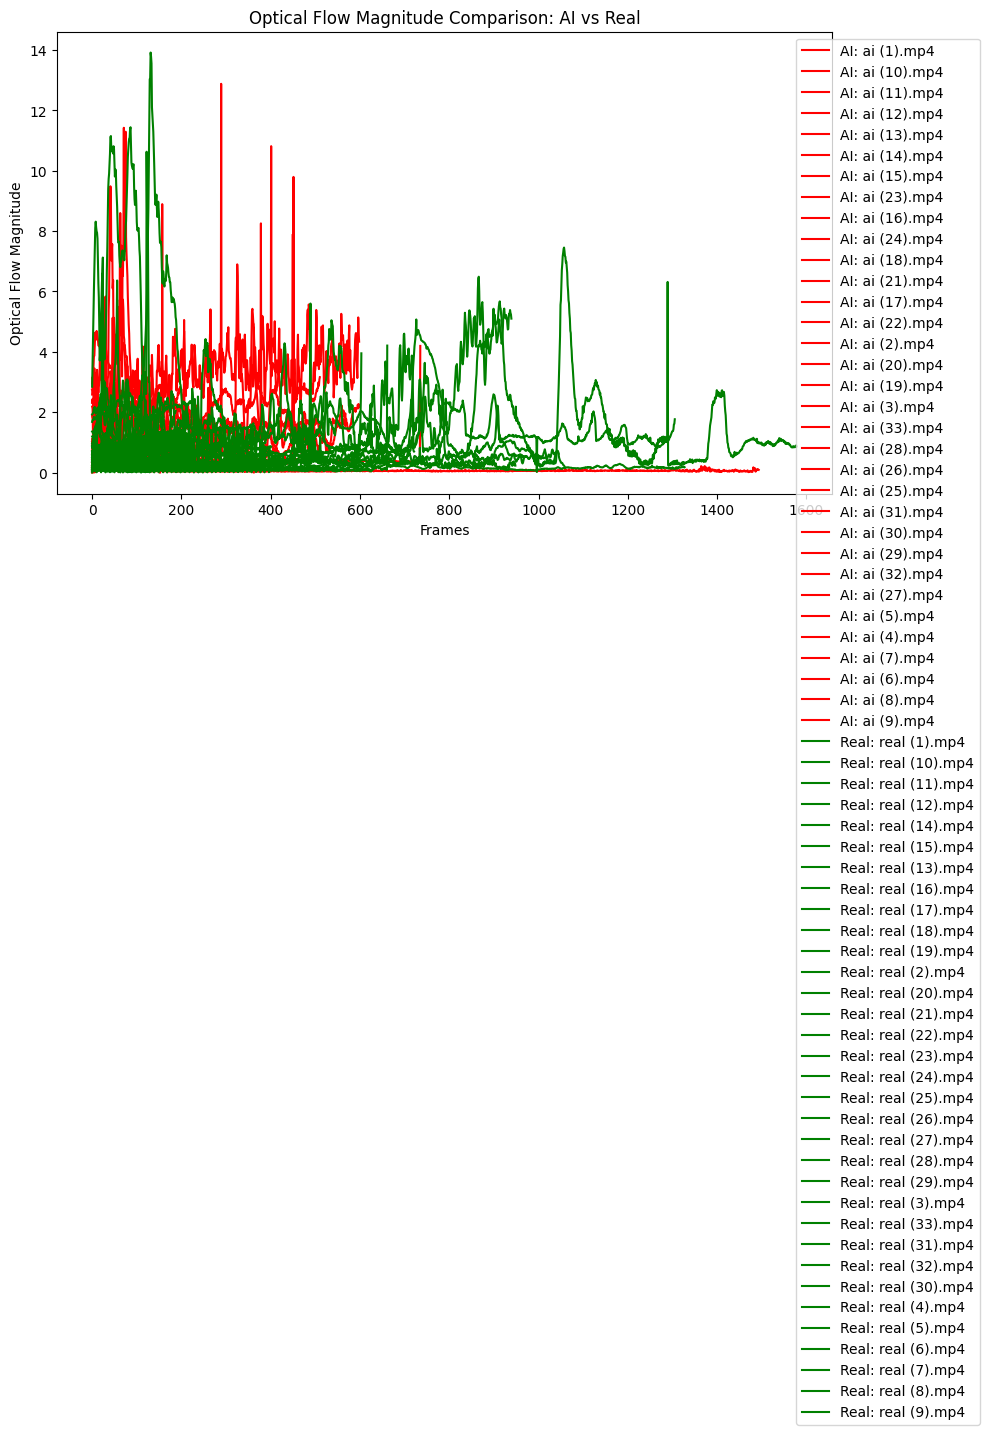

In [ ]:
# Main directory containing both 'ai' and 'real' folders
base_directory = "/content/drive/MyDrive/datasets/real-ai-dataset"

# Get video paths for AI and Real
ai_video_paths, real_video_paths = get_video_paths(base_directory)

# Combine both lists
all_video_paths = ai_video_paths + real_video_paths

# Compute optical flows for all videos
optical_flows = compute_optical_flow_for_videos(all_video_paths)

# Plot the optical flows using the video paths
plot_optical_flows(optical_flows, ai_video_paths, real_video_paths)


In [ ]:
import numpy as np
import os

# Define the save path
save_dir = "/content/drive/MyDrive/datasets/extracted_features"
os.makedirs(save_dir, exist_ok=True)  # Create the folder if it doesn't exist

save_path = os.path.join(save_dir, "optical_flows_medium.npy")

# Save the extracted optical flow data
np.save(save_path, optical_flows)
print(f"Optical flow data saved to: {save_path}")

Optical flow data saved to: /content/drive/MyDrive/datasets/extracted_features/optical_flows_medium.npy


In [ ]:
# Load the saved optical flow data
optical_flows = np.load(save_path, allow_pickle=True).item()
print("Optical flow data loaded successfully!")


Optical flow data loaded successfully!


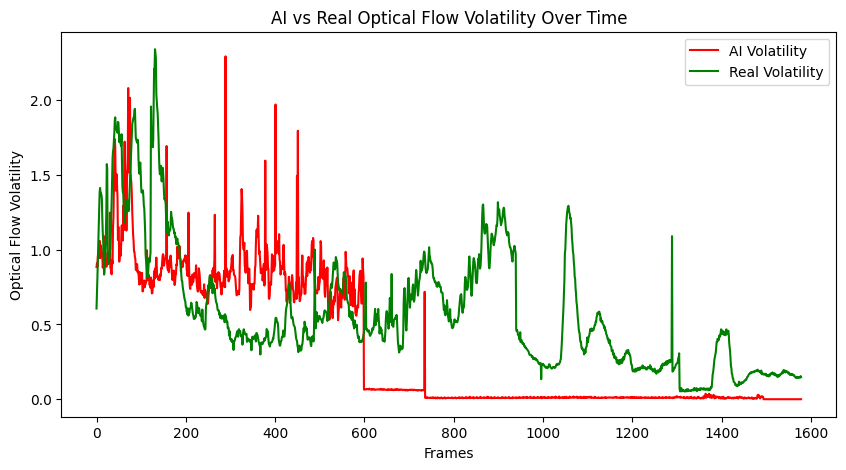

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ai_vs_real_volatility(optical_flows, ai_video_paths, real_video_paths):
    # Separate AI and Real optical flows
    ai_optical_flows = [optical_flows[path] for path in ai_video_paths if path in optical_flows]
    real_optical_flows = [optical_flows[path] for path in real_video_paths if path in optical_flows]

    # Ensure there's data to process
    if not ai_optical_flows or not real_optical_flows:
        print("❌ Not enough AI or Real data for volatility comparison.")
        return

    max_length = max(max(map(len, ai_optical_flows)), max(map(len, real_optical_flows)))

    # Pad sequences instead of trimming
    ai_optical_flows = np.array([np.pad(flow, (0, max_length - len(flow)), mode='constant') for flow in ai_optical_flows])
    real_optical_flows = np.array([np.pad(flow, (0, max_length - len(flow)), mode='constant') for flow in real_optical_flows])

    # Compute frame-wise standard deviation (volatility)
    ai_volatility = np.std(ai_optical_flows, axis=0)
    real_volatility = np.std(real_optical_flows, axis=0)

    # Plot AI vs Real volatility
    plt.figure(figsize=(10, 5))
    plt.plot(ai_volatility, label="AI Volatility", color="red")
    plt.plot(real_volatility, label="Real Volatility", color="green")

    plt.xlabel("Frames")
    plt.ylabel("Optical Flow Volatility")
    plt.title("AI vs Real Optical Flow Volatility Over Time")
    plt.legend()
    plt.show()

plot_ai_vs_real_volatility(optical_flows, ai_video_paths, real_video_paths)

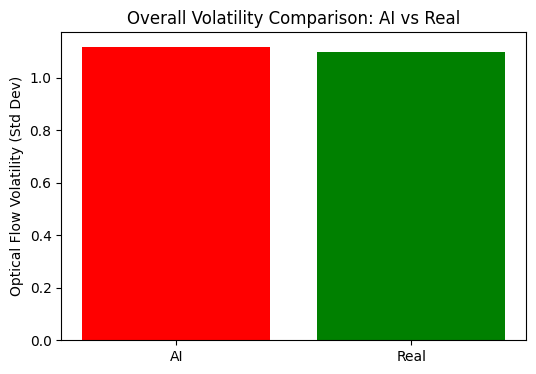

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract optical flow values correctly
ai_optical_flows = [optical_flows[path] for path in ai_video_paths if path in optical_flows]
real_optical_flows = [optical_flows[path] for path in real_video_paths if path in optical_flows]

# Ensure non-empty data before computing standard deviation
if ai_optical_flows and real_optical_flows:
    ai_volatility = np.std(np.concatenate(ai_optical_flows))
    real_volatility = np.std(np.concatenate(real_optical_flows))

    # Plot bar chart
    plt.figure(figsize=(6, 4))
    plt.bar(["AI", "Real"], [ai_volatility, real_volatility], color=['red', 'green'])
    plt.ylabel("Optical Flow Volatility (Std Dev)")
    plt.title("Overall Volatility Comparison: AI vs Real")
    plt.show()
else:
    print("❌ Error: One of the lists is empty. Check if AI or Real video paths have corresponding optical flows.")


In [ ]:
import xgboost as xgb
import numpy as np

# Load extracted features
ai_features = np.load("extracted_features/ai_features.npy", allow_pickle=True)
real_features = np.load("extracted_features/real_features.npy", allow_pickle=True)

# Convert to structured dataset
X = np.array([np.hstack((f["optical_flow"], f["frame_difference"], f["fft"], f["edge_density"])) for f in ai_features + real_features])
y = np.array([f["label"] for f in ai_features + real_features])

# Train model
model = xgb.XGBClassifier()
model.fit(X, y)
